In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error # <-- IMPORTAR MÉTRICAS
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsforecast.models import AutoETS
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import ttest_1samp
import seaborn as sns
import statsmodels.api as sm
# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from utils.calculations import process_df

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)

Carregar Banco de Dados.

In [16]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Filtrar viajens com destino ao Rio de Janeiro

In [17]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)
df_rj.tail()

date  arrivals
295 2024-08-01   91504.0
296 2024-09-01  116003.0
297 2024-10-01  130985.0
298 2024-11-01  145148.0
299 2024-12-01  176121.0

Criar banco de dados para análise temporal

In [18]:
df_rj_unico = df_rj.set_index('date').copy()
data_series = df_rj_unico['arrivals']
data_series

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Decomposição STL

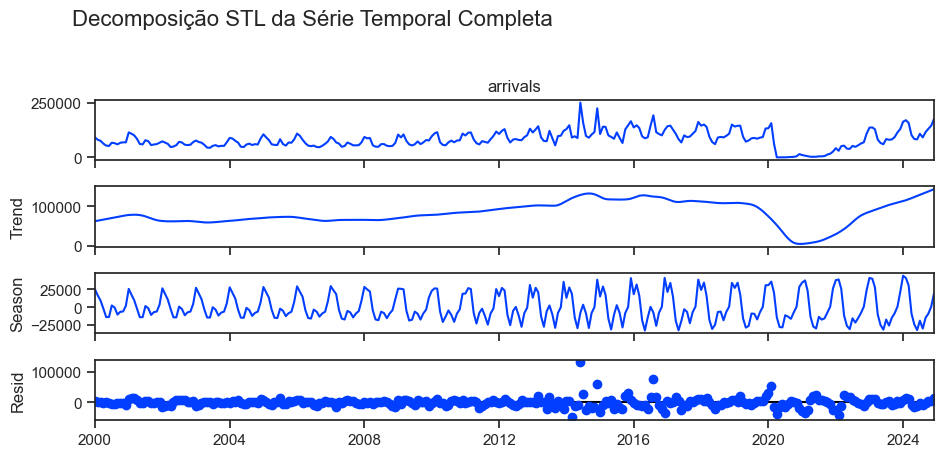

In [19]:
# Realiza a decomposição STL na série temporal completa

stl_total = STL(data_series, period=12, seasonal=13)
result_total = stl_total.fit()

# Plota os componentes da decomposição (tendência, sazonalidade, resíduo)
fig = result_total.plot()
fig.suptitle('Decomposição STL da Série Temporal Completa', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1.5, 0.95]) # Ajusta o layout para evitar sobreposição do título
plt.show()

Definir Período da covid.

In [20]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2023-05-01'   # Último dia do período a ser imputado
dados_pre_covid = data_series.loc[:PRE_COVID_END].copy()

Projetar Componente Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [21]:
stl = STL(dados_pre_covid, period=12, seasonal=13).fit()

ultimo_ano_sazonal = stl.seasonal[-12:]
indice_gap_covid = data_series.loc[COVID_START:COVID_END].index
n_meses_gap = len(indice_gap_covid)

n_repeticoes = int(np.ceil(n_meses_gap / 12))
valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]

sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap_covid)


segmento_tendencia_recente = stl.trend.dropna().iloc[-12:]

x = np.arange(len(segmento_tendencia_recente))
y = segmento_tendencia_recente.values
coefs = np.polyfit(x, y, 1) # Retorna [slope, intercept]
slope = coefs[0]

ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
x_projecao = np.arange(1, n_meses_gap + 1)
valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia

tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap_covid)


valores_imputados = tendencia_imputada + sazonal_imputado
data_series_imputada = data_series.copy()
data_series_imputada.loc[COVID_START:COVID_END] = valores_imputados

Projetar Média das Componentes Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [22]:
# Calcula a média da sazonalidade para cada mês do ano a partir do período pré-COVID
media_sazonal_mensal = stl.seasonal.groupby(stl.seasonal.index.month).mean()

# Mapeia a média sazonal de cada mês para o período de gap da COVID
sazonalidade_imputada_media = pd.Series(
    indice_gap_covid.month.map(media_sazonal_mensal), 
    index=indice_gap_covid
)

# Calcula a média do componente de tendência do período pré-COVID
media_tendencia = stl.trend.dropna().mean()

# Cria uma série constante com a média da tendência para o período de gap
tendencia_imputada_media = pd.Series(media_tendencia, index=indice_gap_covid)

# Soma os componentes de tendência e sazonalidade para obter os valores imputados
valores_imputados_media = tendencia_imputada_media + sazonalidade_imputada_media

# Cria uma nova série temporal e preenche o período da COVID com os valores imputados
data_series_imputada_media = data_series.copy()
data_series_imputada_media.loc[COVID_START:COVID_END] = valores_imputados_media

Imputação pelo AutoETS

In [23]:
# Prepara o DataFrame de treino (pré-COVID) no formato esperado pelo StatsForecast
df_pre_covid_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': dados_pre_covid.index,
    'y': dados_pre_covid.values
})

# Inicializa e treina o modelo AutoETS com os dados pré-COVID
sf_ets = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
sf_ets.fit(df=df_pre_covid_sf)

# Faz a previsão para o período do gap da COVID
# O horizonte (h) é o número de meses a serem imputados
forecast_ets = sf_ets.forecast(df=df_pre_covid_sf,h=n_meses_gap)

# Cria uma Série com os valores previstos, usando o índice do período da COVID
valores_imputados_ets = pd.Series(forecast_ets['AutoETS'].values, index=indice_gap_covid)

# Cria uma cópia da série original e substitui o período da COVID pelos valores imputados
data_series_imputada_ets = data_series.copy()
data_series_imputada_ets.loc[COVID_START:COVID_END] = valores_imputados_ets

Plot da Comparação das Imputações com o Período Original.

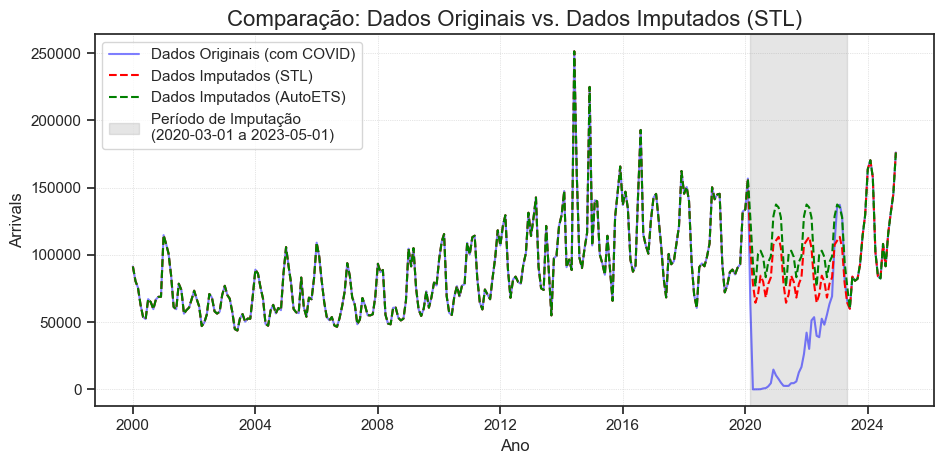

In [24]:
plt.plot(data_series.index, data_series, label='Dados Originais (com COVID)', 
         color='blue', alpha=0.5)

# Plota os novos dados imputados
plt.plot(data_series_imputada_media.index, data_series_imputada_media, 
         label='Dados Imputados (STL)', 
         color='red', linestyle='--')

plt.plot(data_series_imputada_ets.index, data_series_imputada_ets, 
         label='Dados Imputados (AutoETS)', 
         color='green', linestyle='--')

# Destaca a área que foi imputada
plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
            color='gray', alpha=0.2, label=f'Período de Imputação\n({COVID_START} a {COVID_END})')

plt.title('Comparação: Dados Originais vs. Dados Imputados (STL)', fontsize=16)
plt.ylabel(data_series.name.capitalize() if data_series.name else 'Valores')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout(rect=[0,0,1.5,1])
plt.show()

ETS Python

Modelo Selecionado:  ETS(M,N,M)

RMSE (Treino): 17149.85
MAPE (Treino): 11.36%
MAE (Treino): 10304.73

RMSE (2024): 33564.43
MAPE (2024): 20.64%
MAE (2024): 28659.12


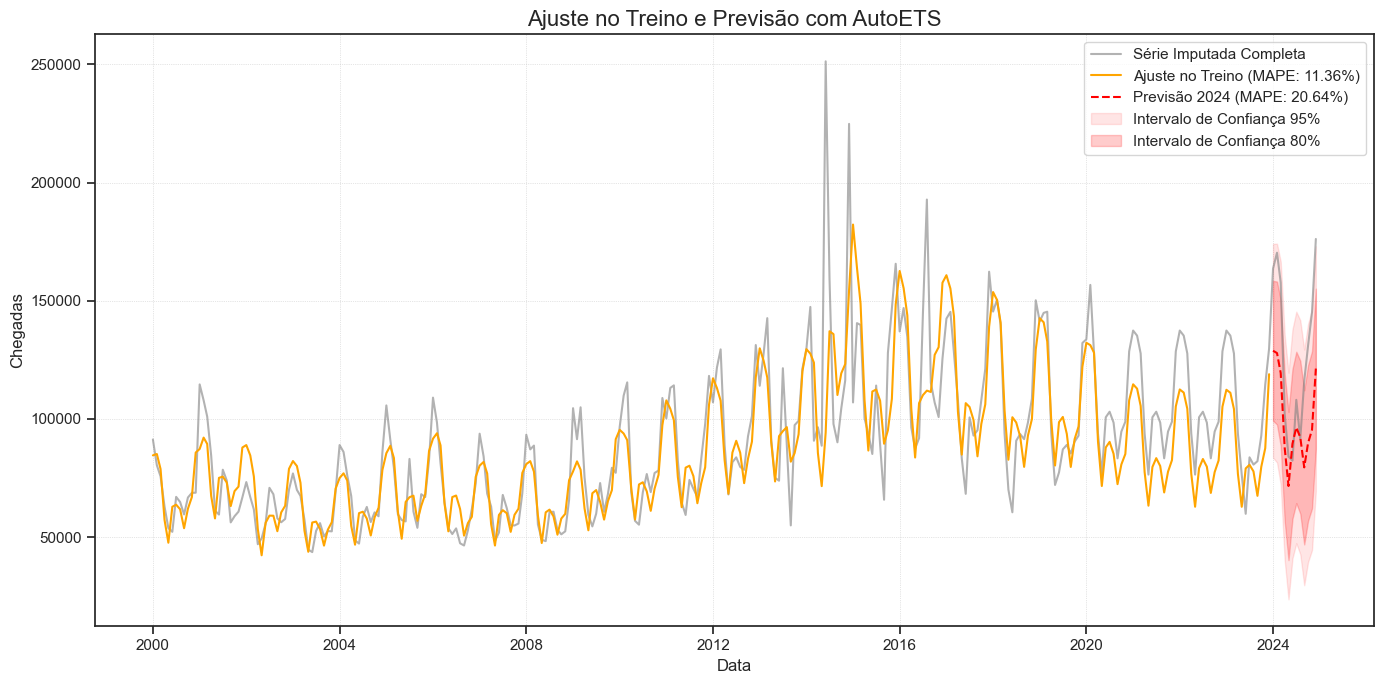

In [ ]:
# Treino até 2023-12-31 e teste em 2024, treino ETS via AutoETS (statsforecast) e previsão
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'

# Série de treino e teste a partir da série já imputada
train_series = data_series_imputada_media.loc[:train_end].copy()
test_series = data_series_imputada_media.loc[test_start:test_end].copy()

# Prepara DataFrame no formato esperado pelo StatsForecast (unique_id, ds, y)
df_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': train_series.index,
    'y': train_series.values
})

# Inicializa o objeto StatsForecast com AutoETS
sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)

sf.fit(df=df_sf)

# Chamada correta: passar o DataFrame como argumento para forecast()
forecasts = sf.forecast(df=df_sf, h=12, level=[80,95], fitted=True)

# Identifica a coluna de previsão (pode variar de nome conforme versão)
pred_col = [c for c in forecasts.columns if c not in ('unique_id', 'ds')][0]

# Series de previsão alinhada com as datas do horizonte
pred_index = pd.to_datetime(forecasts['ds'])
y_pred_teste = forecasts[pred_col].values

# Valores s (verdadeiros) para 2024 alinhados com o índice de previsão
y_true_teste = test_series.reindex(pred_index).values

# Métricas
rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

# Extrai as previsões in-sample (ajuste no treino)
fitted_values_df = sf.forecast_fitted_values()

# Alinha os valores verdadeiros do treino com as previsões
y_true_treino = df_sf['y'].values
y_pred_treino = fitted_values_df['AutoETS'].values

# Métricas para o período de treino
rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

print("Modelo Selecionado: ", sf.fitted_[0][0].model_['method'])

print(f"\nRMSE (Treino): {rmse_treino:.2f}")
print(f"MAPE (Treino): {mape_treino:.2f}%")
print(f"MAE (Treino): {mae_treino:.2f}")

print(f"\nRMSE (2024): {rmse_val:.2f}")
print(f"MAPE (2024): {mape_val:.2f}%")
print(f"MAE (2024): {mae_val:.2f}")

# Plot
plt.figure(figsize=(14, 7))

# Plot da série completa imputada
plt.plot(data_series_imputada_media.index, data_series_imputada_media.values, 
         label='Série Imputada Completa', color='gray', alpha=0.6)

# Plot dos valores ajustados no treino
plt.plot(fitted_values_df['ds'], fitted_values_df['AutoETS'].values, 
         label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')

# Plot da previsão para o período de teste
plt.plot(pred_index, y_pred_teste, 
         label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

# Intervalos de confiança
plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'], 
                 color='red', alpha=0.1, label='Intervalo de Confiança 95%')
plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'], 
                 color='red', alpha=0.2, label='Intervalo de Confiança 80%')

plt.title('Ajuste no Treino e Previsão com AutoETS', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Chegadas')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


IMPORTANTE

'method' extrai o método utilizado pelo AutoETS - (sf.fitted_[0][0].model_['method'])

'arma' acessa quais os parametros do modelo foram utilizados pelo AutoARIMA - (sf_arima_residuos.fitted_[0][0].model_['arma'])

'residuals' são os resíduos padronizados (innovation residuals) - (sf.fitted_[0][0].model_['residuals'])

'actual_residuals' são os resíduos na escala original (y - y_hat); - (sf.fitted_[0][0].model_['actual_residuals'])

Análise dos resíduos

modelo ETS(M,N,M)
--- Análise de Resíduos ---

1. Teste T para Média Zero:
   Estatística t: 0.5629
   p-valor: 0.5740
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0019
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.01).

3. Teste de Jarque-Bera (Normalidade):
   Estatística: 8538.5027
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.1415
   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).


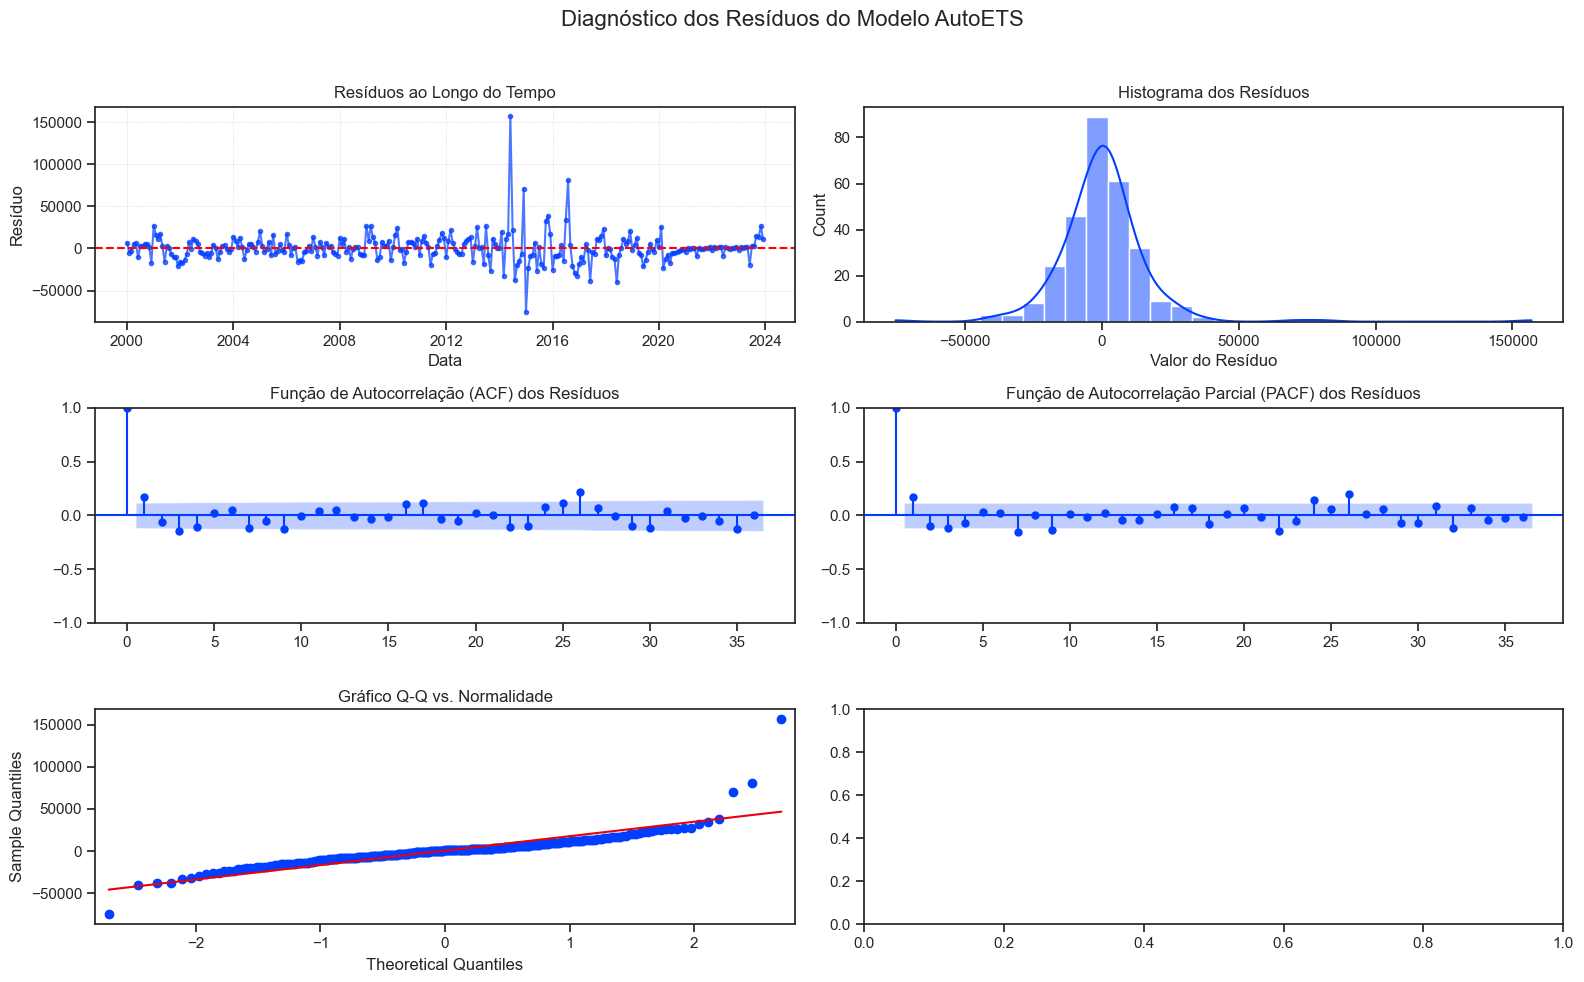

In [26]:
# --- Residual Diagnostics (Training Set) ---
print(f"modelo",sf.fitted_[0][0].model_['method'])

print("--- Análise de Resíduos ---")

residuos = y_true_treino - y_pred_treino

# 1. Teste T para Média Zero
print("\n1. Teste T para Média Zero:")
if len(residuos) > 1:
    t_stat, t_pvalue = ttest_1samp(residuos, 0)
    print(f"   Estatística t: {t_stat:.4f}")
    print(f"   p-valor: {t_pvalue:.4f}")
    if t_pvalue > 0.05:
        print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).")
    else:
        print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero (p < 0.05).")
        if residuos.mean() > 0:
            print("   → O modelo tende a SUBESTIMAR os valores reais.")
        else:
            print("   → O modelo tende a SUPERESTIMAR os valores reais.")
else:
    print("   Não foi possível realizar o Teste T (dados insuficientes).")


# 2. Teste de Ljung-Box para Autocorrelação
print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
if len(residuos) > 24:
    lb_test = acorr_ljungbox(residuos, lags=[24], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   p-valor: {lb_pvalue:.4f}")
    if lb_pvalue > 0.01:
        print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.01).")
    else:
        print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.01).")
else:
    print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

# 3. Teste de Jarque-Bera para Normalidade
print("\n3. Teste de Jarque-Bera (Normalidade):")
if len(residuos) > 1:
    jb_stat, jb_pvalue = stats.jarque_bera(residuos)
    print(f"   Estatística: {jb_stat:.4f}")
    print(f"   p-valor: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos (p > 0.05).")
    else:
        print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Jarque-Bera (dados insuficientes).")

# 4. Teste ARCH para Heterocedasticidade
print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
try:
    arch_test = het_arch(residuos, nlags=12)
    arch_pvalue = arch_test[1]
    print(f"   p-valor: {arch_pvalue:.4f}")
    if arch_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).")
    else:
        print("   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).")
except Exception as e:
    print(f"   Não foi possível realizar o Teste ARCH: {e}")


# --- Plots de Diagnóstico ---
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
fig.suptitle('Diagnóstico dos Resíduos do Modelo AutoETS', fontsize=16)

# Plot 1: Resíduos ao longo do tempo
axes[0, 0].plot(train_series.index, residuos, marker='o', linestyle='-', markersize=3, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo')
axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

# Plot 2: Histograma dos resíduos
sns.histplot(residuos, kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Histograma dos Resíduos')
axes[0, 1].set_xlabel('Valor do Resíduo')

# Plot 3: Gráfico Q-Q (Quantil-Quantil)
sm.qqplot(residuos, line='s', ax=axes[2, 0])
axes[2, 0].set_title('Gráfico Q-Q vs. Normalidade')

# Plot 4: Gráfico de Autocorrelação (ACF)
sm.graphics.tsa.plot_acf(residuos, ax=axes[1, 0], lags=36)
axes[1, 0].set_title('Função de Autocorrelação (ACF) dos Resíduos')

# Plot 5: Gráfico de Autocorrelação Parcial (PACF)
sm.graphics.tsa.plot_pacf(residuos, ax=axes[1, 1], lags=36)
axes[1, 1].set_title('Função de Autocorrelação Parcial (PACF) dos Resíduos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

O modelo ETS para o total. não passa no teste de Ljung-Box, logo não há autocorrelação entre os resíduos e os modelos ETS não foram úteis para modelar, então inovaremos com o modelo Hibrido (ETS + ARIMA nos resíduos).

--- Construindo Modelo Híbrido (ETS + ARIMA nos Resíduos) ---

--- Comparação de Performance no Período de Teste (2024) ---
AutoETS       -> RMSE: 33564.43, MAPE: 20.64%, MAE: 28659.12
Híbrido (ETS+ARIMA) -> RMSE: 35079.44, MAPE: 21.67%, MAE: 30113.45


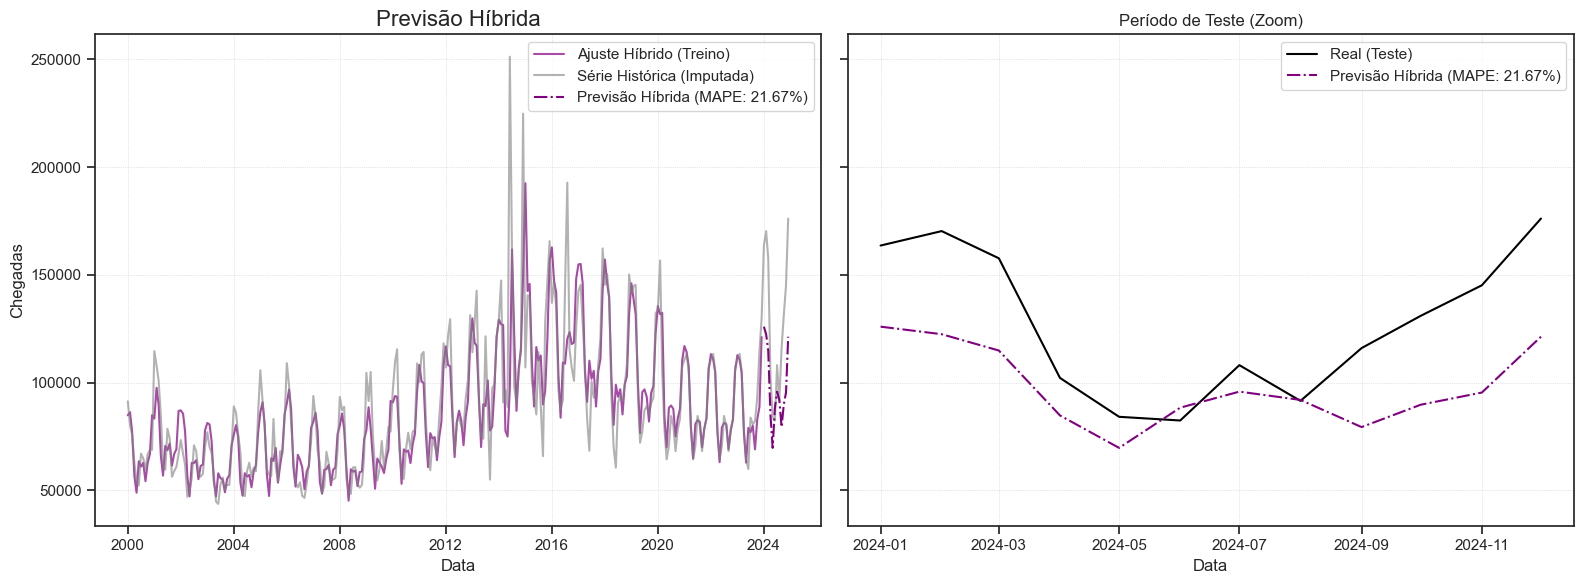

Arquivo salvo: forecasts_comparison.csv (linhas: 300)


In [28]:
# --- Modelo Híbrido: ETS + ARIMA nos Resíduos ---
print("--- Construindo Modelo Híbrido (ETS + ARIMA nos Resíduos) ---")

# 1. Preparar DataFrame com os resíduos do modelo AutoETS anterior
df_residuos = pd.DataFrame({
    'unique_id': 'rj_residuos',
    'ds': train_series.index,
    'y': residuos
})

# 2. Treinar um modelo AutoARIMA nos resíduos
# O objetivo é capturar qualquer padrão remanescente nos resíduos do ETS
sf_arima_residuos = StatsForecast(
    models=[AutoARIMA(season_length=12)], 
    freq='MS', 
    n_jobs=-1
)
sf_arima_residuos.fit(df=df_residuos)

# 3. Fazer a previsão dos resíduos para o período de teste (h=12)
forecast_residuos = sf_arima_residuos.forecast(df=df_residuos, h=12, fitted=True)


# Opcional: Criar a previsão do ARIMA para o conjunto de treino (fitted values)
fitted_residuos = sf_arima_residuos.forecast_fitted_values()

y_pred_treino_hibrido = fitted_residuos['AutoARIMA'].values + y_pred_treino


# 4. Criar a previsão do modelo híbrido
# Previsão Híbrida = Previsão do ETS + Previsão dos Resíduos
y_pred_teste_hibrido = y_pred_teste + forecast_residuos['AutoARIMA'].values

# 5. Calcular as métricas de erro para o modelo híbrido
rmse_hibrido = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste_hibrido))
mape_hibrido = mean_absolute_percentage_error(y_true_teste, y_pred_teste_hibrido) * 100
mae_hibrido = mean_absolute_error(y_true_teste, y_pred_teste_hibrido)

print("\n--- Comparação de Performance no Período de Teste (2024) ---")
print(f"AutoETS       -> RMSE: {rmse_val:.2f}, MAPE: {mape_val:.2f}%, MAE: {mae_val:.2f}")
print(f"Híbrido (ETS+ARIMA) -> RMSE: {rmse_hibrido:.2f}, MAPE: {mape_hibrido:.2f}%, MAE: {mae_hibrido:.2f}")


# 6. Plotar os resultados para comparação
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Mantém o eixo ativo no subgráfico da esquerda para os próximos plt.plot() do notebook
plt.sca(axs[0])

# Preenche o subgráfico da direita com apenas o período de teste (valores reais + previsões)
try:
    axs[1].plot(pred_index, y_true_teste, label='Real (Teste)', color='black')
except Exception:
    # se y_true_teste não estiver disponível, tenta y_true_test_check ou ignora
    try:
        axs[1].plot(pred_index, y_true_test_check[:len(pred_index)], label='Real (Teste)', color='black')
    except Exception:
        pass

# Plota previsões no painel da direita
axs[1].plot(pred_index, y_pred_teste_hibrido, label=f'Previsão Híbrida (MAPE: {mape_hibrido:.2f}%)', color='purple', linestyle='-.')

axs[1].set_title('Período de Teste (Zoom)', fontsize=12)
axs[1].set_xlabel('Data')
axs[1].grid(True, which='both', linestyle=':', linewidth=0.5)
axs[1].legend()

# Plot do ajuste no treino do Modelo Híbrido
plt.plot(train_series.index, y_pred_treino_hibrido, 
         label='Ajuste Híbrido (Treino)', color='purple', alpha=0.7)

# Plot da série completa imputada
plt.plot(data_series_imputada_media.index, data_series_imputada_media.values, 
         label='Série Histórica (Imputada)', color='gray', alpha=0.6)

# Plot da previsão do modelo híbrido
plt.plot(pred_index, y_pred_teste_hibrido, 
         label=f'Previsão Híbrida (MAPE: {mape_hibrido:.2f}%)', color='purple', linestyle='-.')

plt.title('Previsão Híbrida', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Chegadas')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Exportar CSV com comparativo (toda a série) ---
full_index = pd.to_datetime(data_series_imputada_media.index)
actual = data_series_imputada_media.reindex(full_index).values

# Séries de previsão iniciais (vazias)
ets_forecast_series = pd.Series(index=full_index, dtype=float)
hybrid_forecast_series = pd.Series(index=full_index, dtype=float)

# Preencher previsões in-sample (treino)
ets_train_dates = pd.to_datetime(fitted_values_df['ds'])
ets_forecast_series.loc[ets_train_dates] = fitted_values_df['AutoETS'].values

# Se existir, use as datas dos resíduos ajustados para o híbrido; fallback para fitted_values_df
try:
    hybrid_train_dates = pd.to_datetime(fitted_residuos['ds'])
except Exception:
    hybrid_train_dates = ets_train_dates

# y_pred_treino_hibrido já foi calculado anteriormente no notebook
hybrid_forecast_series.loc[hybrid_train_dates] = y_pred_treino_hibrido

# Preencher previsões out-of-sample (teste)
ets_forecast_series.loc[pred_index] = y_pred_teste
hybrid_forecast_series.loc[pred_index] = y_pred_teste_hibrido

# Extrair nomes dos modelos (quando disponível)
try:
    ets_model_name = sf.fitted_[0][0].model_.get('method', 'AutoETS')
except Exception:
    ets_model_name = 'AutoETS'

try:
    arima_model_name = sf_arima_residuos.fitted_[0][0].model_.get('arma', 'AutoARIMA')
except Exception:
    arima_model_name = 'AutoARIMA(resid)'

# Montar DataFrames para cada modelo
# Garantir que todos os vetores tenham o mesmo comprimento (len(full_index))
n = len(full_index)

# Forçar arrays 1D e alinhamento de comprimento
actual = data_series_imputada_media.reindex(full_index).values
ets_vals = ets_forecast_series.values
hybrid_vals = hybrid_forecast_series.values

df_ets_out = pd.DataFrame({
    'date': full_index,
    'continent': ['South America'] * n,
    'actual': actual,
    'forecast': ets_vals,
    'ets_model': [ets_model_name] * n,
    'arima_model': [None] * n,
    'model_type': ['ETS'] * n
})

df_hybrid_out = pd.DataFrame({
    'date': full_index,
    'continent': ['South America'] * n,
    'actual': actual,
    'forecast': hybrid_vals,
    'ets_model': [ets_model_name] * n,
    'arima_model': [arima_model_name] * n,
    'model_type': ['HYBRID'] * n
})

# Concatena, calcula erros e salva CSV
df_out = pd.concat([df_hybrid_out], ignore_index=True)
df_out['error'] = df_out['actual'] - df_out['forecast']
df_out['abs_error'] = df_out['error'].abs()
df_out['pct_error'] = np.where(df_out['actual'] != 0, df_out['error'] / df_out['actual'] * 100, np.nan)

# Ordenar por data e model_type para facilitar leitura
df_out = df_out.sort_values(['date', 'model_type']).reset_index(drop=True)



# Salva CSV
output_filename = "forecasts_comparison.csv"
df_out.to_csv(output_filename, index=False)
print(f"Arquivo salvo: {output_filename} (linhas: {len(df_out)})")

Modelo ARIMA (2, 1, 0, 0, 1, 0, 0)

--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---

1. Teste T para Média Zero:
   Estatística t: 0.6973
   p-valor: 0.4862
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.2990
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.01).

3. Teste de Jarque-Bera (Normalidade):
   Estatística: 9929.5540
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0112
   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).


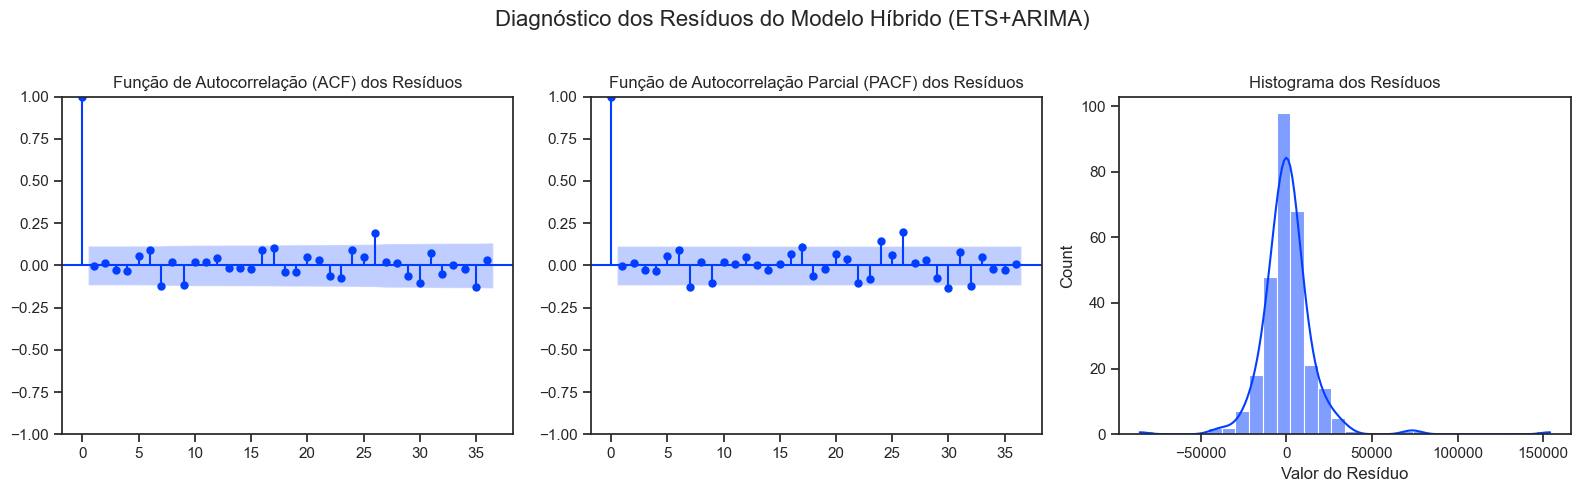

In [14]:
print("Modelo ARIMA", sf_arima_residuos.fitted_[0][0].model_['arma'])

print("\n--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---")

residuos_hibrido_treino = y_true_treino - y_pred_treino_hibrido

# 1. Teste T para Média Zero
print("\n1. Teste T para Média Zero:")
if len(residuos_hibrido_treino) > 1:
    t_stat, t_pvalue = ttest_1samp(residuos_hibrido_treino, 0)
    print(f"   Estatística t: {t_stat:.4f}")
    print(f"   p-valor: {t_pvalue:.4f}")
    if t_pvalue > 0.05:
        print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).")
    else:
        print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero (p < 0.05).")
        if sf.fitted_[0][0].model_['residuals'].mean() > 0:
            print("   → O modelo tende a SUBESTIMAR os valores reais.")
        else:
            print("   → O modelo tende a SUPERESTIMAR os valores reais.")
else:
    print("   Não foi possível realizar o Teste T (dados insuficientes).")


# 2. Teste de Ljung-Box para Autocorrelação
print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
if len(residuos_hibrido_treino) > 24:
    lb_test = acorr_ljungbox(residuos_hibrido_treino, lags=[24], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   p-valor: {lb_pvalue:.4f}")
    if lb_pvalue > 0.01:
        print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.01).")
    else:
        print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.01).")
else:
    print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

# 3. Teste de Jarque-Bera para Normalidade
print("\n3. Teste de Jarque-Bera (Normalidade):")
if len(residuos_hibrido_treino) > 1:
    jb_stat, jb_pvalue = stats.jarque_bera(residuos_hibrido_treino)
    print(f"   Estatística: {jb_stat:.4f}")
    print(f"   p-valor: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos (p > 0.05).")
    else:
        print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Jarque-Bera (dados insuficientes).")

# 4. Teste ARCH para Heterocedasticidade
print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
try:
    arch_test = het_arch(residuos_hibrido_treino, nlags=12)
    arch_pvalue = arch_test[1]
    print(f"   p-valor: {arch_pvalue:.4f}")
    if arch_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).")
    else:
        print("   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).")
except Exception as e:
    print(f"   Não foi possível realizar o Teste ARCH: {e}")


# --- Plots de Diagnóstico ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Diagnóstico dos Resíduos do Modelo Híbrido (ETS+ARIMA)', fontsize=16)

# Plot 2: Histograma dos resíduos
sns.histplot(residuos_hibrido_treino, kde=True, ax=axes[2], bins=30)
axes[2].set_title('Histograma dos Resíduos')
axes[2].set_xlabel('Valor do Resíduo')

# Plot 4: Gráfico de Autocorrelação (ACF)
sm.graphics.tsa.plot_acf(residuos_hibrido_treino, ax=axes[0], lags=36)
axes[0].set_title('Função de Autocorrelação (ACF) dos Resíduos')

# Plot 5: Gráfico de Autocorrelação Parcial (PACF)
sm.graphics.tsa.plot_pacf(residuos_hibrido_treino, ax=axes[1], lags=36)
axes[1].set_title('Função de Autocorrelação Parcial (PACF) dos Resíduos')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Plot padronizado

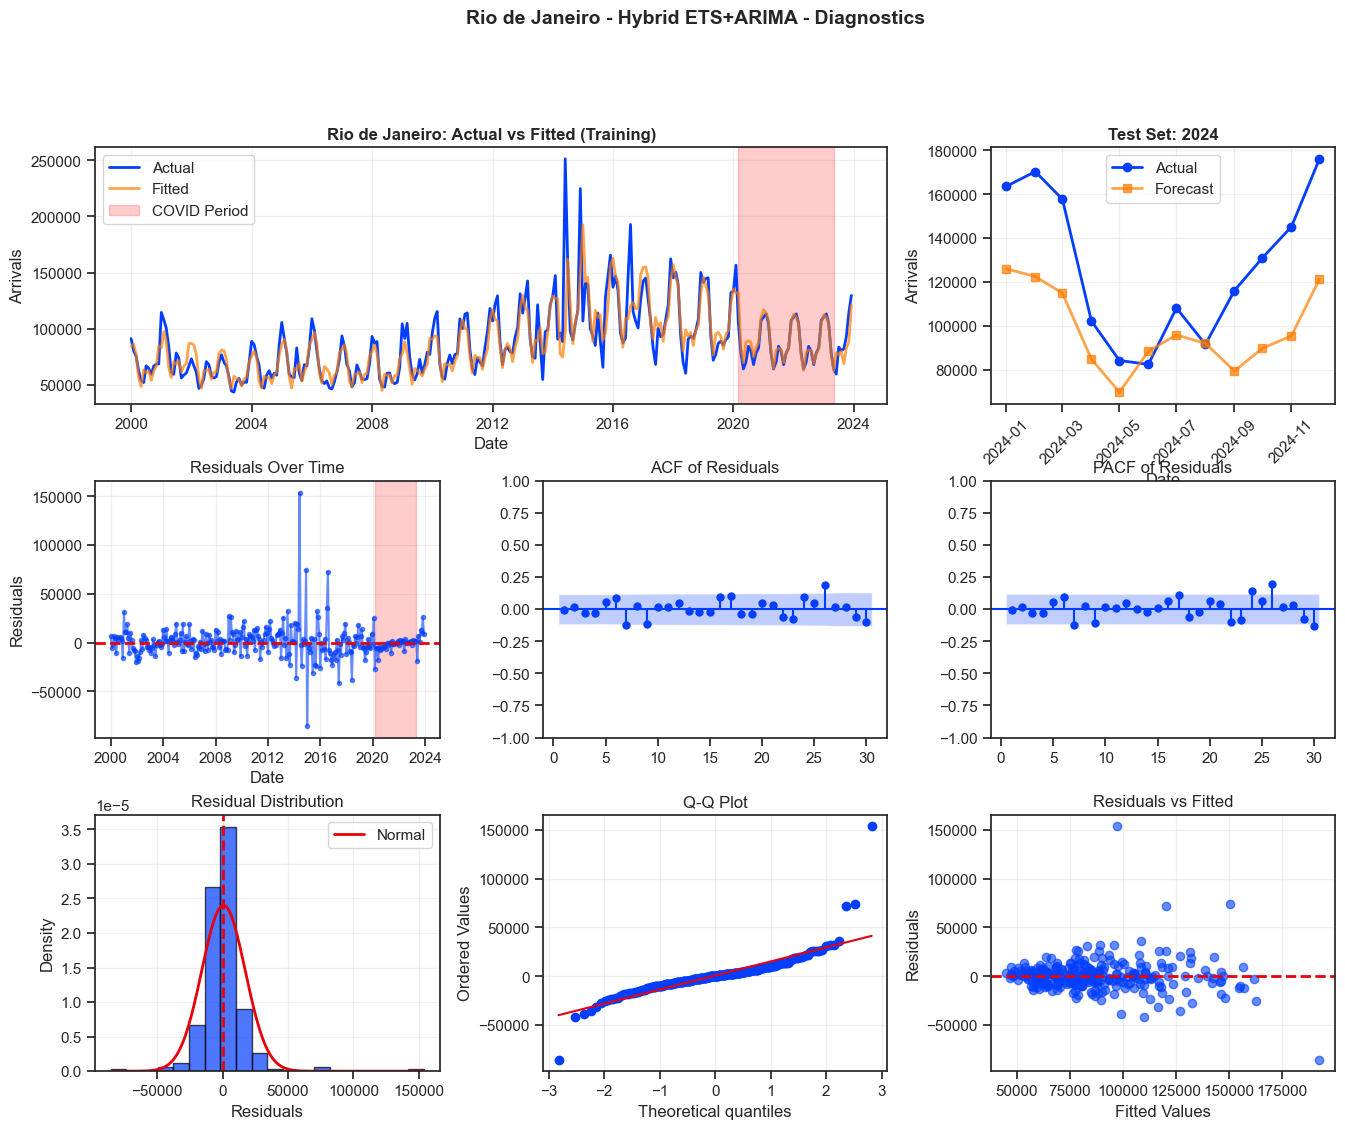

In [15]:
# Diagnostics plot (usar variáveis já existentes no notebook)
# Garante alinhamento seguro entre arrays/series antes de plotar

# Mapear variáveis existentes para os nomes esperados pelo plot
y_train = train_series.copy()          # série de treino (pandas Series)
y_test = test_series.copy()            # série de teste (pandas Series)
covid_start = pd.to_datetime(COVID_START)
covid_end = pd.to_datetime(COVID_END)
continent = "Rio de Janeiro"           # rótulo para os títulos (ajuste se desejar)
model_name = "Hybrid ETS+ARIMA"       # texto descritivo para o título

# Fitted (treino) - pode vir do array y_pred_treino_hibrido
# Assegura que o comprimento e índice batam com y_train
if len(y_pred_treino_hibrido) == len(y_train):
    fitted = pd.Series(y_pred_treino_hibrido, index=y_train.index)
else:
    # alinha pelo tamanho mínimo como fallback
    n = min(len(y_pred_treino_hibrido), len(y_train))
    fitted = pd.Series(y_pred_treino_hibrido[:n], index=y_train.index[:n])
    y_train = y_train.loc[y_train.index[:n]]

# Forecast (teste) - usa pred_index e y_pred_teste_hibrido quando disponíveis
forecast = pd.Series(y_pred_teste_hibrido, index=pd.to_datetime(pred_index))

# Residuals (treino)
residuals = y_train.values - fitted.values
residuals = pd.Series(residuals, index=y_train.index)

# Ajustes de título/ordens (se não existir best_order/best_seasonal_order usa placeholders)
try:
    best_order = best_order
    best_seasonal_order = best_seasonal_order
    model_title = f'{continent} - {model_name} - SARIMA{best_order}x{best_seasonal_order}'
except Exception:
    model_title = f'{continent} - {model_name} - Diagnostics'

# Plot diagnostics
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Fitted vs Actual (Training)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2)
ax1.plot(fitted.index, fitted.values, label='Fitted', linewidth=2, alpha=0.7)
ax1.axvspan(covid_start, covid_end, alpha=0.2, color='red', label='COVID Period')
ax1.set_title(f'{continent}: Actual vs Fitted (Training)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Arrivals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast vs Actual (Test)
ax2 = fig.add_subplot(gs[0, 2])
ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, marker='o')
ax2.plot(forecast.index, forecast.values, label='Forecast', linewidth=2, alpha=0.7, marker='s')
ax2.set_title('Test Set: 2024', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Arrivals')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Residuals over time
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(residuals.index, residuals.values, marker='o', markersize=3, alpha=0.6)
ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax3.axvspan(covid_start, covid_end, alpha=0.2, color='red')
ax3.set_title('Residuals Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residuals')
ax3.grid(True, alpha=0.3)

# Plot 4: ACF of Residuals
ax4 = fig.add_subplot(gs[1, 1])
sm.graphics.tsa.plot_acf(residuals.dropna(), lags=30, ax=ax4, zero=False)
ax4.set_title('ACF of Residuals')

# Plot 5: PACF of Residuals
ax5 = fig.add_subplot(gs[1, 2])
sm.graphics.tsa.plot_pacf(residuals.dropna(), lags=30, ax=ax5, zero=False, method='ywm')
ax5.set_title('PACF of Residuals')

# Plot 6: Histogram of Residuals
ax6 = fig.add_subplot(gs[2, 0])
resid_vals = residuals.dropna().values
ax6.hist(resid_vals, bins=20, alpha=0.7, edgecolor='black', density=True)
ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
# Normal distribution overlay
mu, sigma = np.mean(resid_vals), np.std(resid_vals)
x_pdf = np.linspace(resid_vals.min(), resid_vals.max(), 200)
ax6.plot(x_pdf, stats.norm.pdf(x_pdf, mu, sigma), 'r-', linewidth=2, label='Normal')
ax6.set_title('Residual Distribution')
ax6.set_xlabel('Residuals')
ax6.set_ylabel('Density')
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Q-Q Plot
ax7 = fig.add_subplot(gs[2, 1])
stats.probplot(resid_vals, dist="norm", plot=ax7)
ax7.set_title('Q-Q Plot')
ax7.grid(True, alpha=0.3)

# Plot 8: Residuals vs Fitted
ax8 = fig.add_subplot(gs[2, 2])
ax8.scatter(fitted.loc[residuals.index], residuals.values, alpha=0.6)
ax8.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax8.set_xlabel('Fitted Values')
ax8.set_ylabel('Residuals')
ax8.set_title('Residuals vs Fitted')
ax8.grid(True, alpha=0.3)

plt.suptitle(model_title, fontsize=14, fontweight='bold', y=0.995)
plt.show()

Concatena os continentes

In [16]:
df_rj_continente = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id"], value_cols="arrivals", agg_func="sum")
df_rj_continente.tail()

date         continent  continent_id  arrivals
2095 2024-12-01  america_do_norte             3   29679.0
2096 2024-12-01    america_do_sul             4   99840.0
2097 2024-12-01              asia             5    2651.0
2098 2024-12-01            europa             6   39981.0
2099 2024-12-01           oceania             7    1623.0

Separa os continentes

In [17]:
# Pivota o dataframe para que cada continente seja uma coluna, com a data como índice
df_continentes_pivot = df_rj_continente.pivot(
    index='date', 
    columns='continent', 
    values='arrivals'
)

# Cria um dicionário onde cada chave é o nome de um continente e o valor é a série temporal correspondente
series_por_continente = {
    continente: df_continentes_pivot[continente] for continente in df_continentes_pivot.columns
}

# Exibe as primeiras 5 linhas do dataframe pivotado para verificação
print("DataFrame Pivotado (cada coluna é uma série temporal):")
print(df_continentes_pivot.head())

# Exemplo de como acessar uma série temporal específica (ex: Europa)
print("\nExemplo de acesso à série da Europa:")
print(series_por_continente['europa'].head())

DataFrame Pivotado (cada coluna é uma série temporal):
continent   africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

continent   america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  

Exemplo de acesso à série da Europa:
date
2000-01-01    41142.0
2000-02-01    36330.0
2000-03-01

Imputando período COVID/Continente

            africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

            america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  


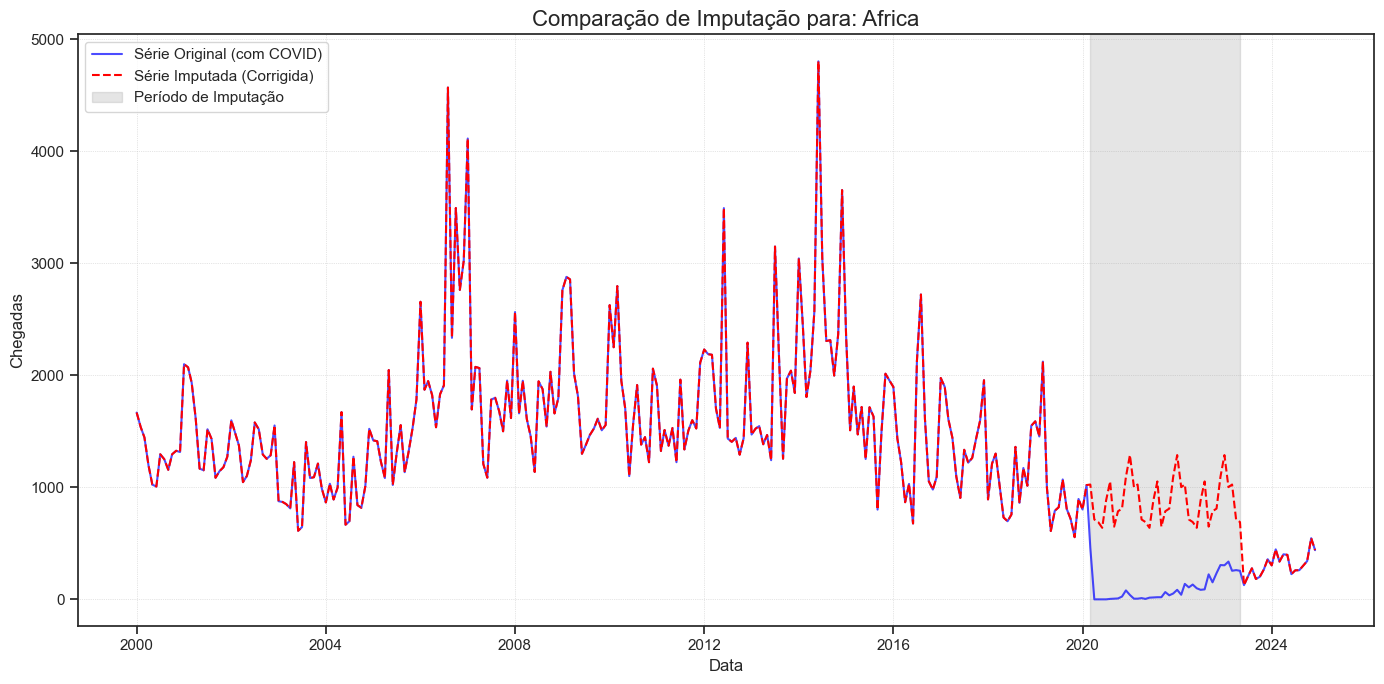

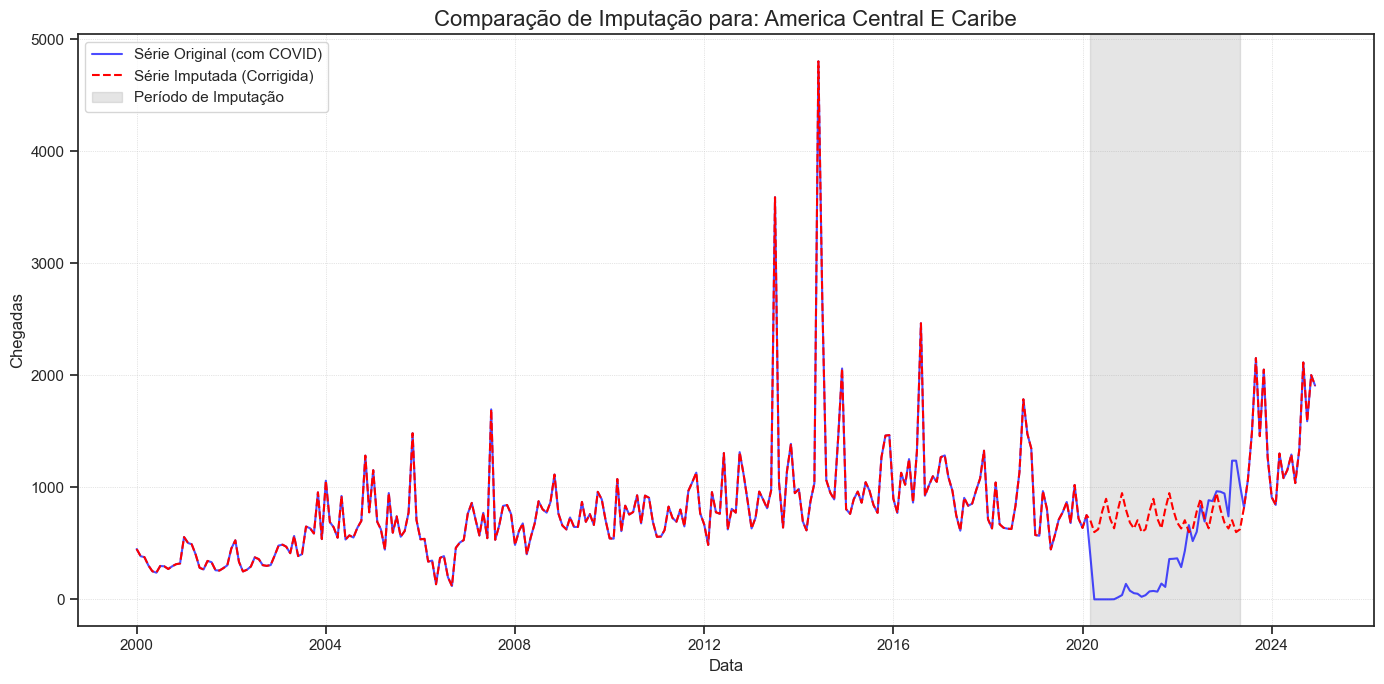

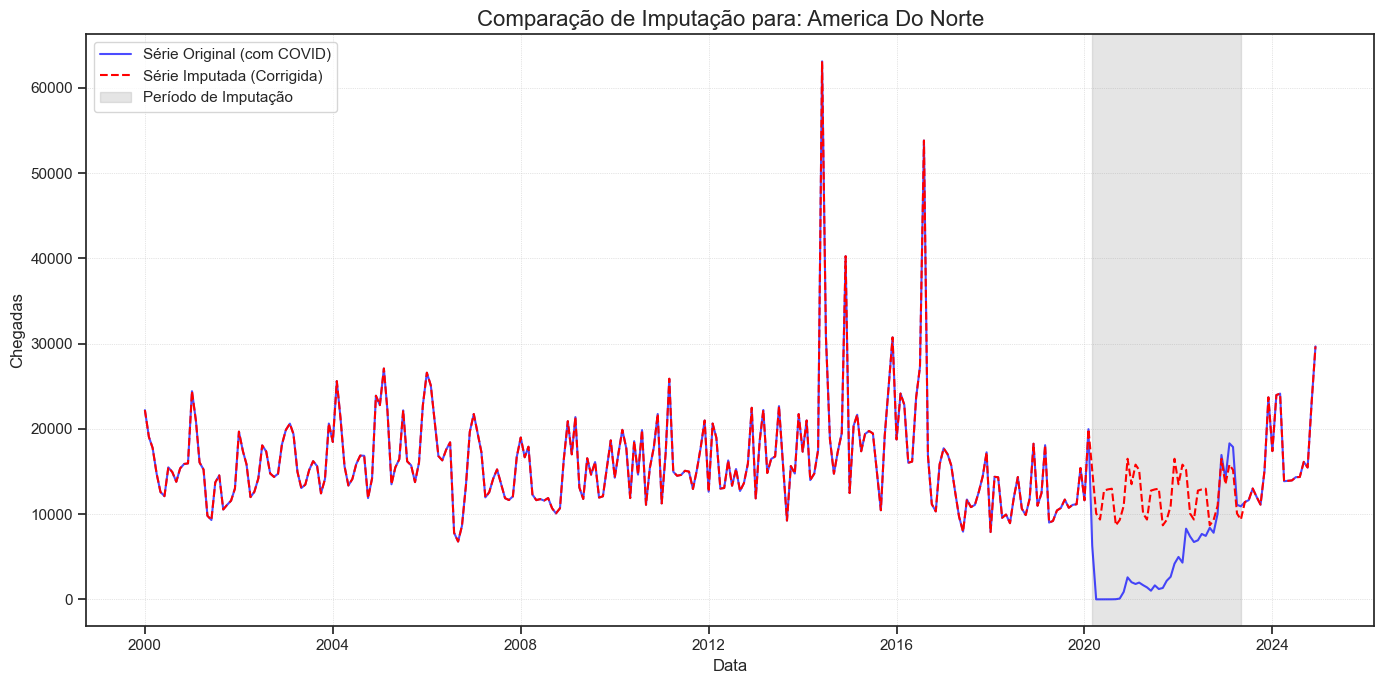

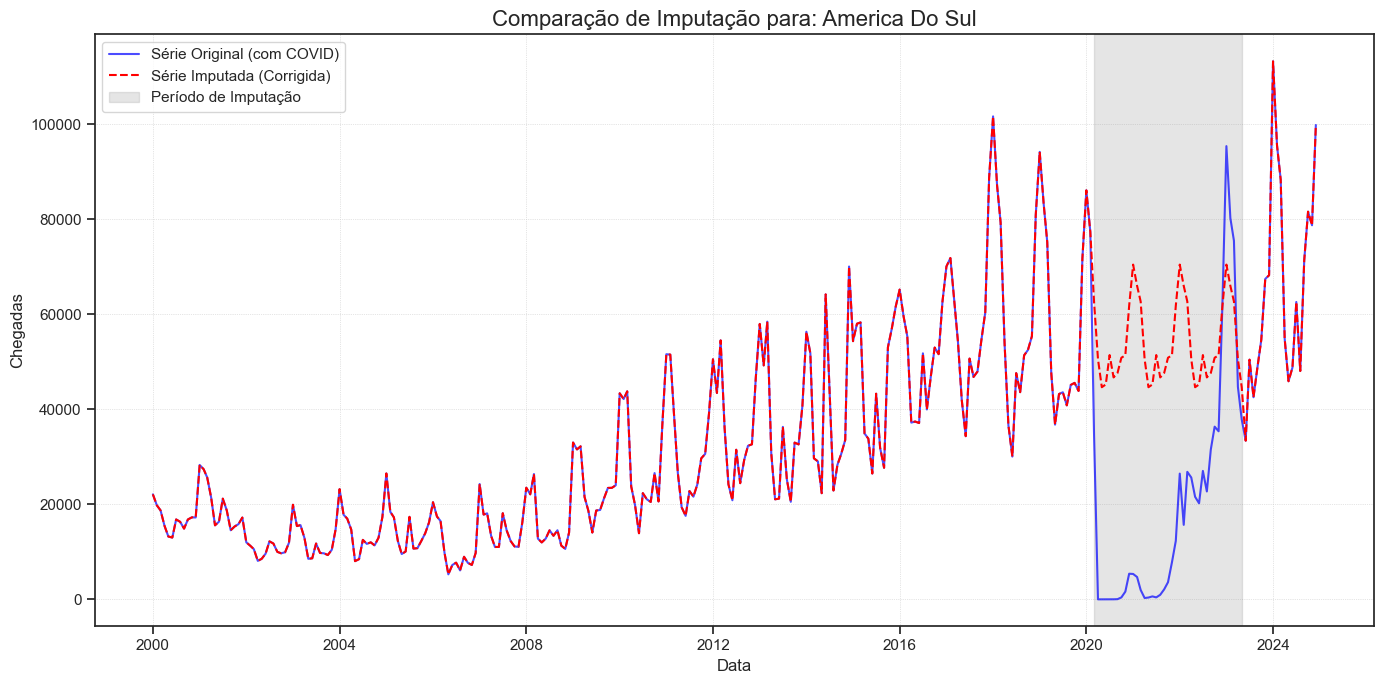

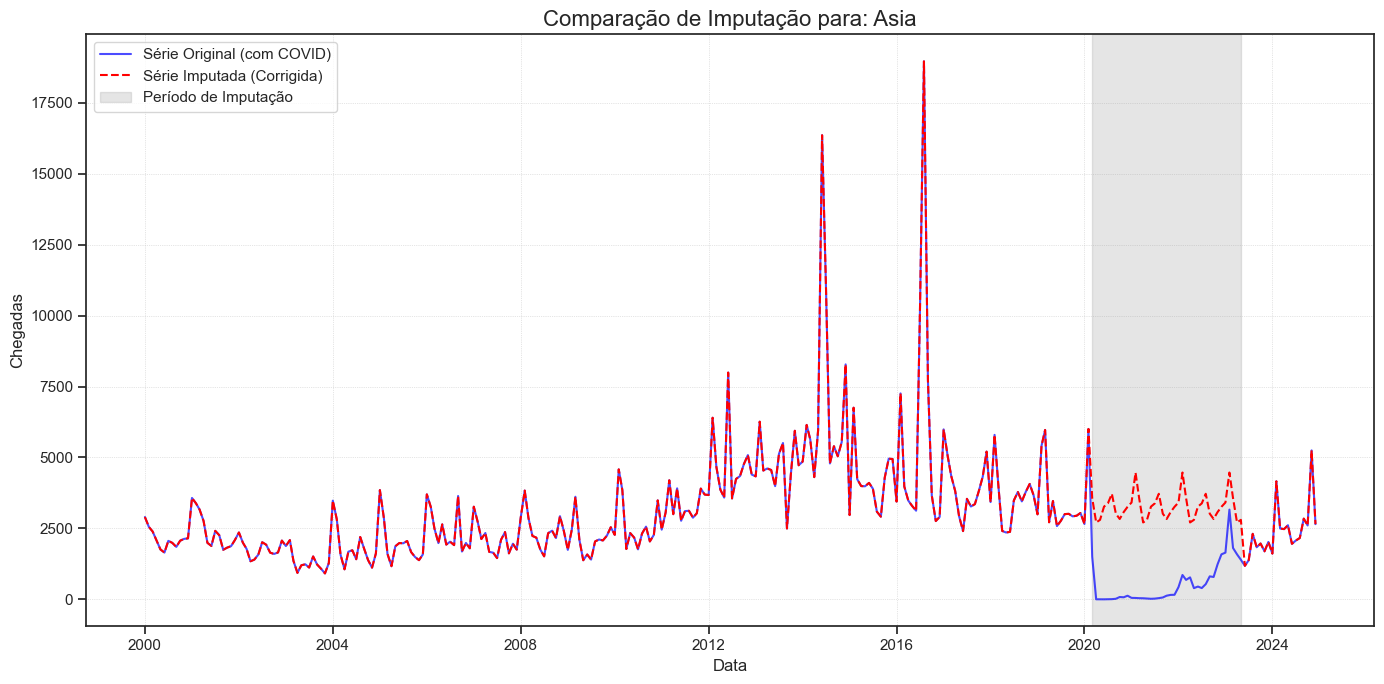

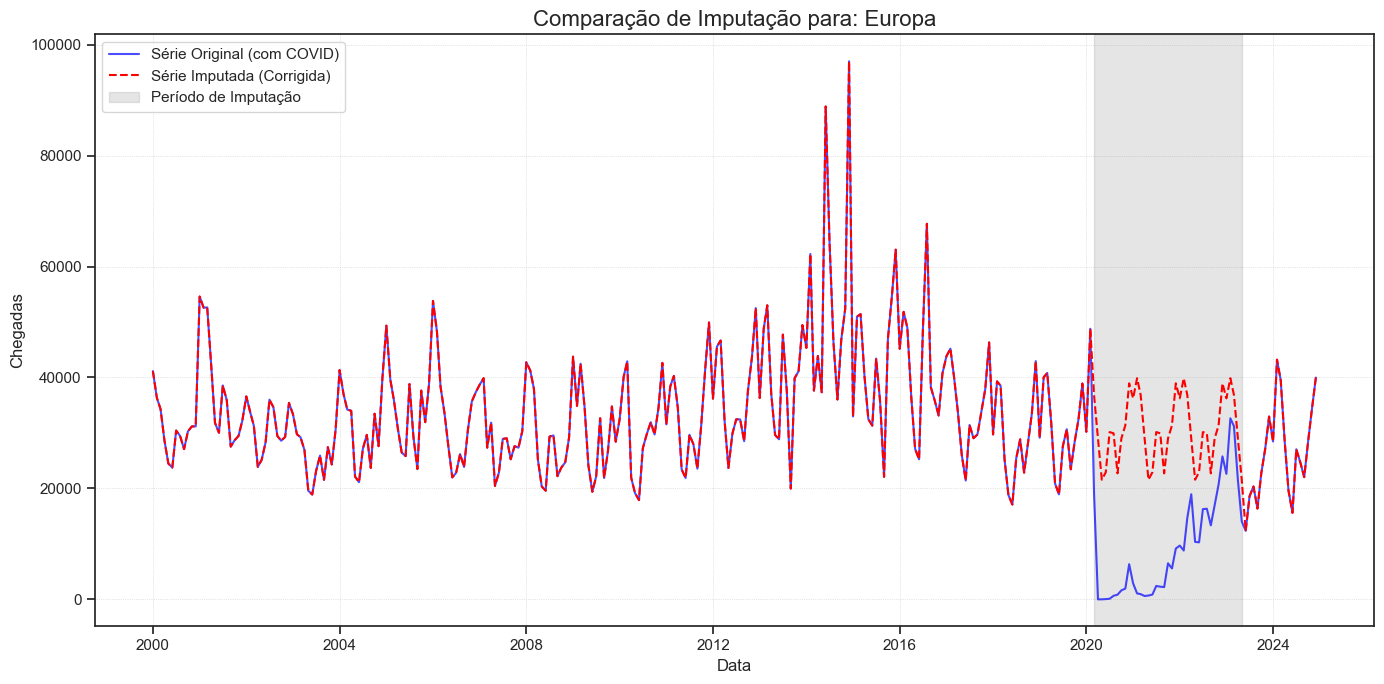

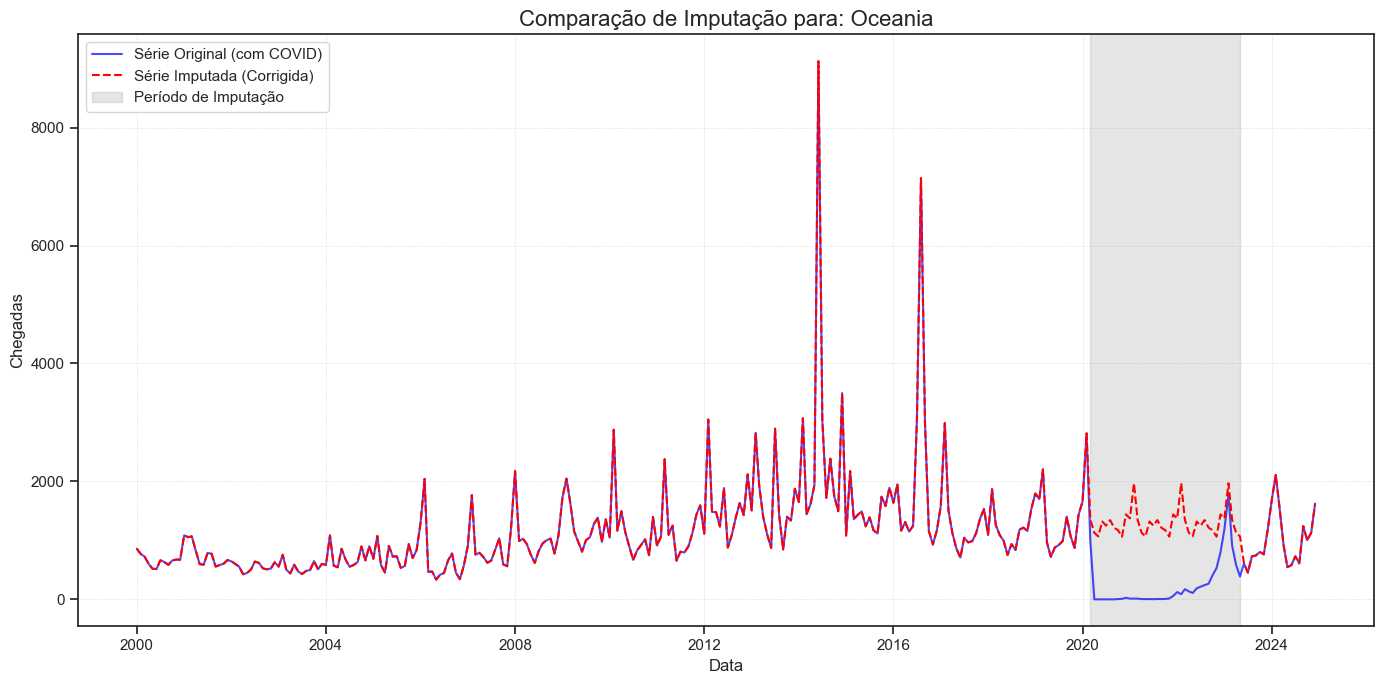

In [18]:
# Imputação do período COVID para cada continente (mesma lógica usada anteriormente)
imputed_continent_series = {}

for continente, serie in series_por_continente.items():
    s = serie.copy()
    # intervalo do gap segundo a série (preserva índice exato)
    indice_gap = s.loc[COVID_START:COVID_END].index
    n_meses_gap = len(indice_gap)
    if n_meses_gap == 0:
        imputed_continent_series[continente] = s
        continue

    # usa apenas pré-COVID para ajustar STL
    pre_covid = s.loc[:PRE_COVID_END].dropna()
    try:
        stl_c = STL(pre_covid, period=12, seasonal=13).fit()

        # --- Componente Sazonal: Média da sazonalidade por mês ---
        # Agrupa a sazonalidade por mês e calcula a média
        sazonalidade_media_mensal = stl_c.seasonal.groupby(stl_c.seasonal.index.month).mean()
        # Mapeia os meses do gap para a sazonalidade média correspondente
        meses_gap = indice_gap.month
        valores_sazonais_projetados = meses_gap.map(sazonalidade_media_mensal).values
        sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap)

        # --- Componente Tendência: Média da tendência dos últimos 12 meses ---
        # Calcula a média dos últimos 12 valores da tendência e a usa como projeção constante
        media_tendencia_recente = stl_c.trend.dropna().iloc[-12:].mean()
        tendencia_imputada = pd.Series(media_tendencia_recente, index=indice_gap)

        # soma tendência + sazonal para obter imputação
        valores_imputados = tendencia_imputada + sazonal_imputado

        s_imputada = s.copy()
        s_imputada.loc[COVID_START:COVID_END] = valores_imputados
        imputed_continent_series[continente] = s_imputada

    except Exception as e:
        # se falhar, mantém a série original e informa
        print(f"Erro ao imputar {continente}: {e}")
        imputed_continent_series[continente] = s

# Monta DataFrame pivotado com séries imputadas (mesmo formato de df_continentes_pivot)
df_continentes_pivot_imputado = pd.DataFrame(imputed_continent_series).sort_index()
df_continentes_pivot_imputado.index.name = 'date'

# Converte para formato longo (ds, unique_id, y) compatível com Y_df_h
Y_df_h_imputado = (
    df_continentes_pivot_imputado
    .reset_index()
    .melt(id_vars='date', var_name='unique_id', value_name='y')
    .rename(columns={'date': 'ds'})
)

# Saída rápida para verificação
print(df_continentes_pivot_imputado.head())

# Plot da comparação para cada continente
for continente, serie_imputada in imputed_continent_series.items():
    serie_original = series_por_continente[continente]
    
    plt.figure(figsize=(14, 7))
    
    # Plota a série original
    plt.plot(serie_original.index, serie_original.values, 
             label='Série Original (com COVID)', color='blue', alpha=0.7)
    
    # Plota a série imputada
    plt.plot(serie_imputada.index, serie_imputada.values, 
             label='Série Imputada (Corrigida)', color='red', linestyle='--')
    
    # Destaca o período de imputação
    plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
                color='gray', alpha=0.2, label=f'Período de Imputação')
    
    # Configurações do gráfico
    plt.title(f'Comparação de Imputação para: {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Chegadas', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()


ETS Continente


--- AFRICA ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 468.15
MAPE (Treino): 22.78%
MAE (Treino): 303.44
RMSE (2024): 124.57
MAPE (2024): 26.91%
MAE (2024): 103.54


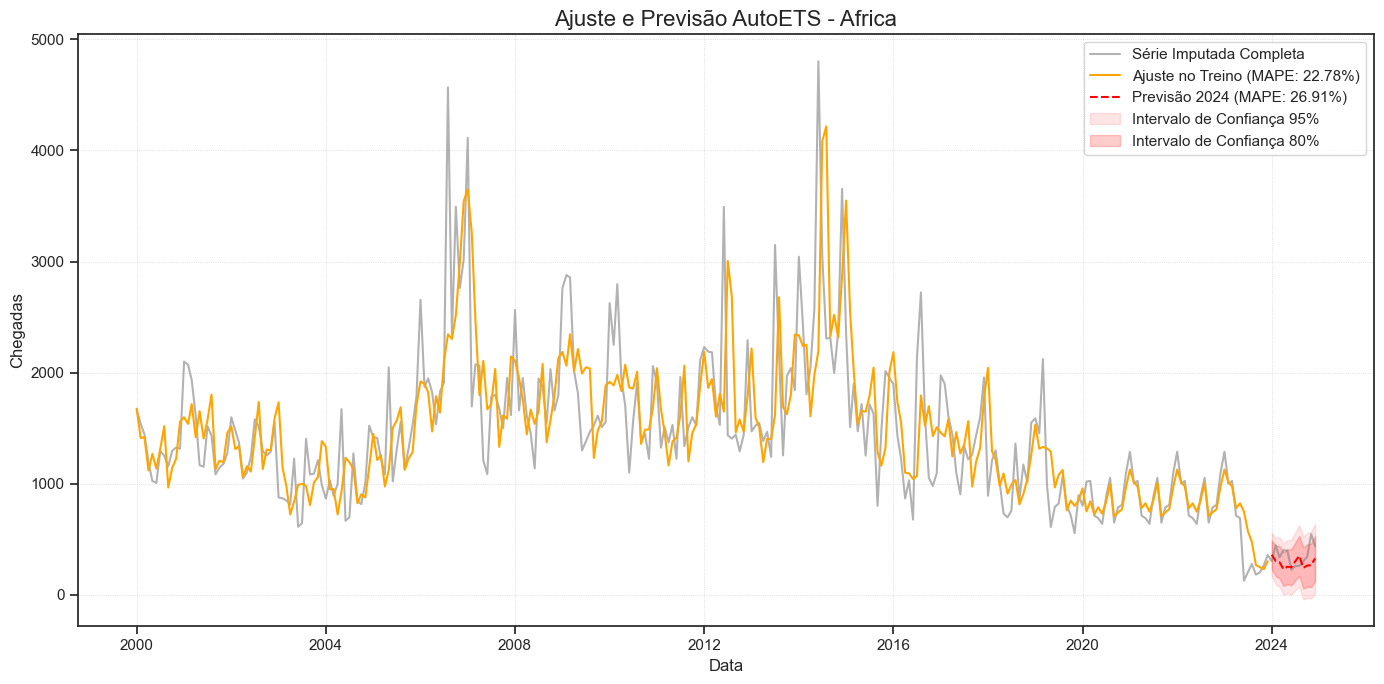


--- AMERICA_CENTRAL_E_CARIBE ---
Modelo Selecionado:  ETS(M,A,M)
RMSE (Treino): 377.77
MAPE (Treino): 31.26%
MAE (Treino): 225.35
RMSE (2024): 450.88
MAPE (2024): 26.89%
MAE (2024): 379.34


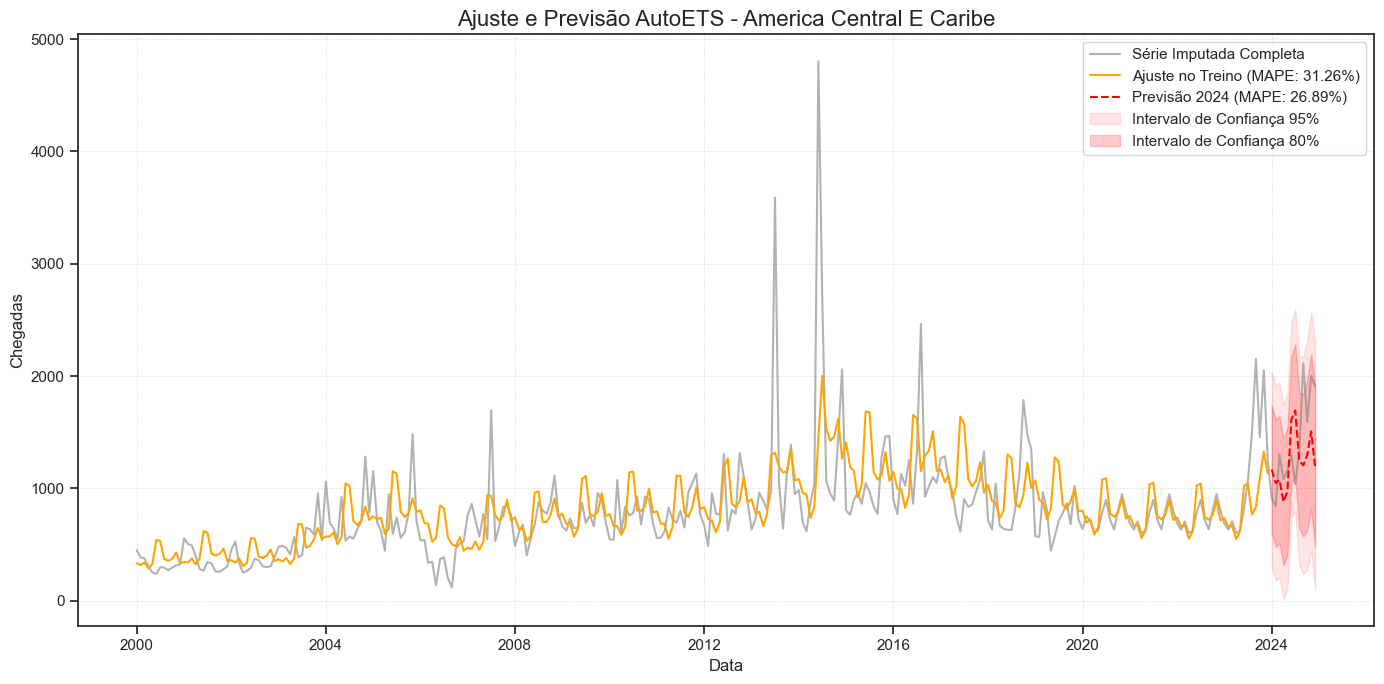


--- AMERICA_DO_NORTE ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 4735.77
MAPE (Treino): 17.52%
MAE (Treino): 2720.35
RMSE (2024): 6161.04
MAPE (2024): 24.87%
MAE (2024): 5015.30


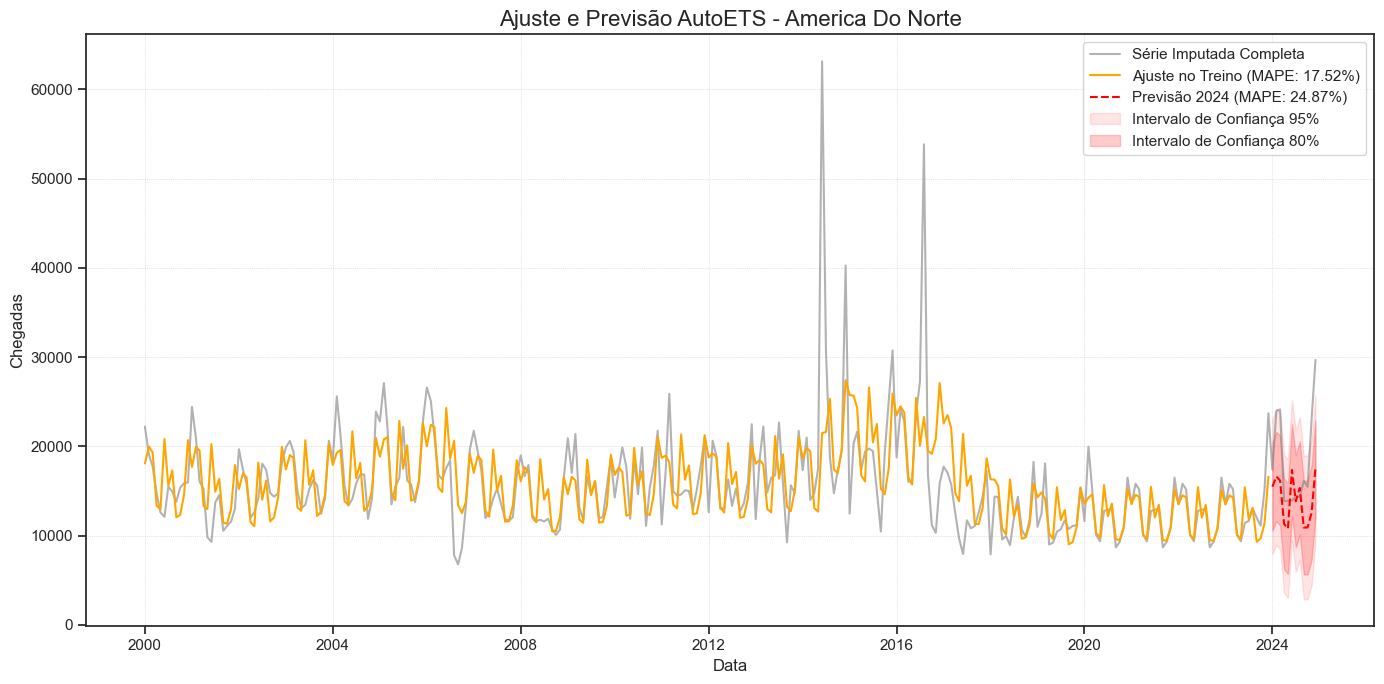


--- AMERICA_DO_SUL ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 6242.70
MAPE (Treino): 13.95%
MAE (Treino): 4154.89
RMSE (2024): 16910.41
MAPE (2024): 15.51%
MAE (2024): 13011.71


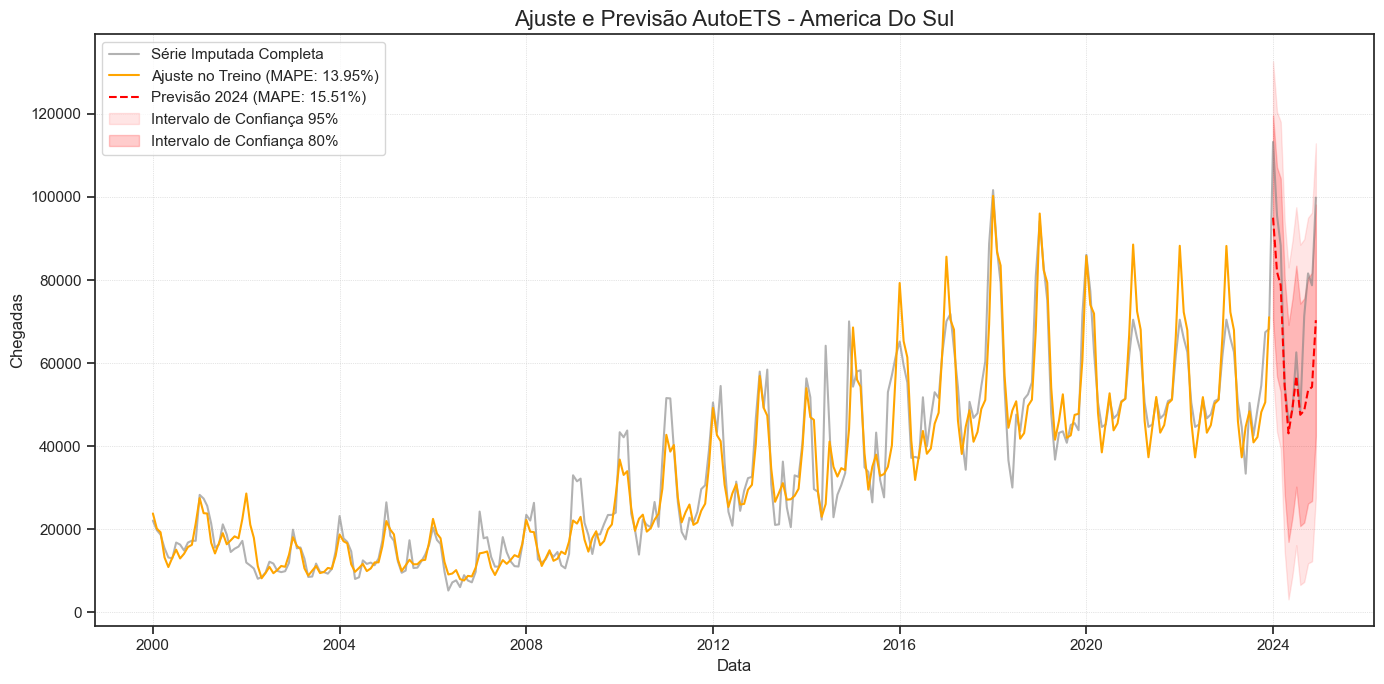


--- ASIA ---
Modelo Selecionado:  ETS(M,N,A)
RMSE (Treino): 1464.69
MAPE (Treino): 21.14%
MAE (Treino): 728.31
RMSE (2024): 1258.71
MAPE (2024): 29.18%
MAE (2024): 884.76


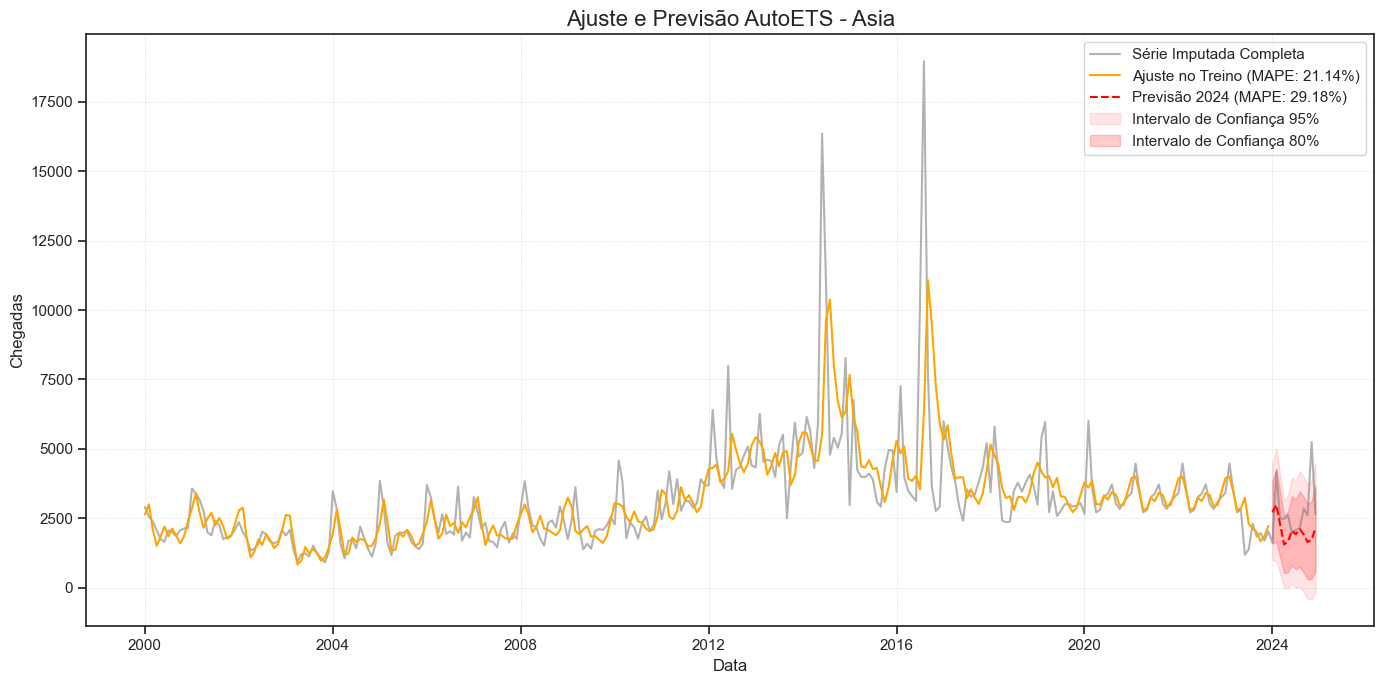


--- EUROPA ---
Modelo Selecionado:  ETS(M,N,A)
RMSE (Treino): 7046.33
MAPE (Treino): 12.81%
MAE (Treino): 4415.80
RMSE (2024): 5663.36
MAPE (2024): 16.22%
MAE (2024): 4950.67


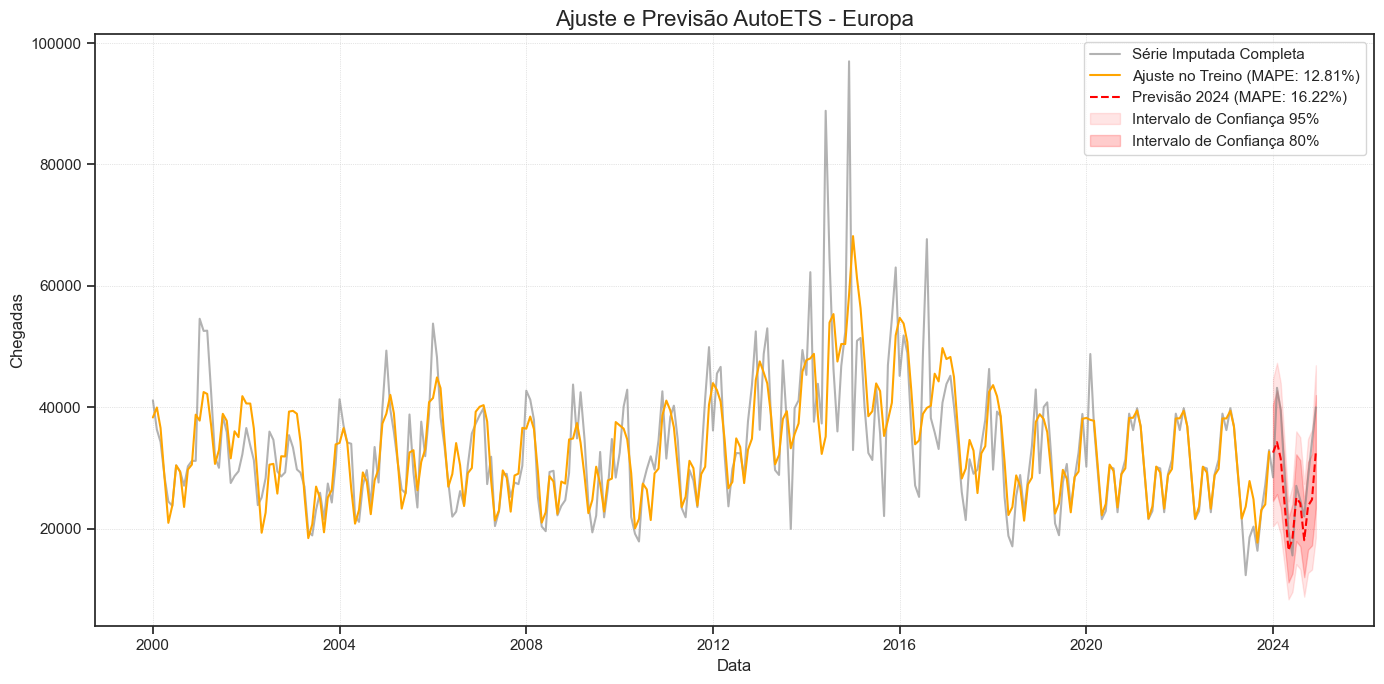


--- OCEANIA ---
Modelo Selecionado:  ETS(M,N,M)
RMSE (Treino): 677.20
MAPE (Treino): 30.10%
MAE (Treino): 353.12
RMSE (2024): 469.27
MAPE (2024): 42.24%
MAE (2024): 421.32


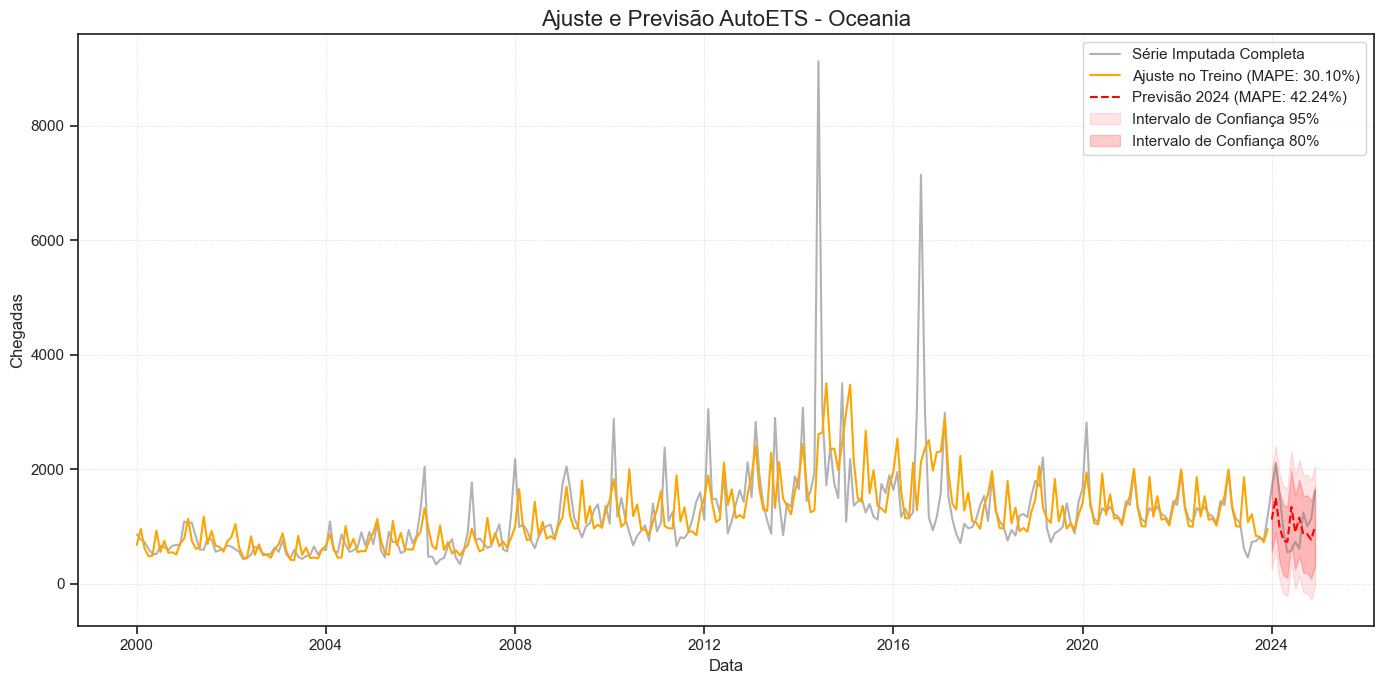

In [19]:
# Treino e teste AutoETS por continente

train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'
h = 12

for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n--- {continente.upper()} ---")
    # Dados de treino (imputados) e teste (originais) para o continente
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] >= test_start)
    ].copy()

    # Série original (não imputada) para o período de teste
    test_series = series_por_continente[continente].loc[test_start:test_end]
    y_true_teste = test_series.values

    # Treina modelo
    sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf.fit(df=train_df)

    # Previsão para horizonte de teste
    forecasts = sf.forecast(df=train_df, h=h, level=[80,95], fitted=True)
    pred_index = pd.to_datetime(forecasts['ds'])
    y_pred_teste = forecasts['AutoETS'].values

    # Métricas teste
    rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
    mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
    mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

    # Ajuste no treino
    fitted_values_df = sf.forecast_fitted_values()
    y_true_treino = train_df['y'].values
    y_pred_treino = fitted_values_df['AutoETS'].values

    rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
    mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
    mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

    print("Modelo Selecionado: ", sf.fitted_[0][0].model_['method'])
    print(f"RMSE (Treino): {rmse_treino:.2f}")
    print(f"MAPE (Treino): {mape_treino:.2f}%")
    print(f"MAE (Treino): {mae_treino:.2f}")
    print(f"RMSE (2024): {rmse_val:.2f}")
    print(f"MAPE (2024): {mape_val:.2f}%")
    print(f"MAE (2024): {mae_val:.2f}")

    # Plot
    plt.figure(figsize=(14, 7))
    # Série histórica imputada
    plt.plot(imputed_continent_series[continente].index, imputed_continent_series[continente].values,
             label='Série Imputada Completa', color='gray', alpha=0.6)
    # Ajuste no treino
    plt.plot(fitted_values_df['ds'], y_pred_treino,
             label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')
    # Previsão teste
    plt.plot(pred_index, y_pred_teste,
             label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

    # Intervalos de confiança
    plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'],
                     color='red', alpha=0.1, label='Intervalo de Confiança 95%')
    plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'],
                     color='red', alpha=0.2, label='Intervalo de Confiança 80%')
    plt.title(f'Ajuste e Previsão AutoETS - {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Chegadas')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()
# ...existing code...

In [20]:
print("\n--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---")

error_options = ['A', 'M']
trend_options = ['N', 'A', 'M']
seasonal_options = ['N', 'A', 'M']
damped_options = [False, True]
h = 12

# Para cada continente
for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n>>> {continente.upper()} <<<")
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_series = series_por_continente[continente].loc[test_start:test_end]
    all_model_results = []

    for error in error_options:
        for trend in trend_options:
            for seasonal in seasonal_options:
                damped_iterable = damped_options if trend in ['A', 'M'] else [False]
                for damped in damped_iterable:
                    model_str = f"{error}{trend}{seasonal}"
                    model_name = f"ETS({model_str}, damped={damped})"
                    try:
                        sf_model = StatsForecast(
                            models=[AutoETS(season_length=12, model=model_str, damped=damped)],
                            freq='MS',
                            n_jobs=1
                        )
                        sf_model.fit(df=train_df)
                        forecast_df = sf_model.forecast(df=train_df, h=h, fitted=True)
                        y_pred_test = forecast_df['AutoETS'].values

                        if len(y_pred_test) == len(test_series.values):
                            mape_test = mean_absolute_percentage_error(test_series.values, y_pred_test) * 100
                            rmse_test = np.sqrt(mean_squared_error(test_series.values, y_pred_test))
                            mae_test = mean_absolute_error(test_series.values, y_pred_test)

                            fitted_df = sf_model.forecast_fitted_values()
                            y_pred_train = fitted_df['AutoETS'].values
                            y_true_train = train_df['y'].values

                            mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train) * 100
                            rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
                            mae_train = mean_absolute_error(y_true_train, y_pred_train)

                            residuals = y_true_train - y_pred_train

                            _, t_pvalue = ttest_1samp(residuals, 0)
                            lb_df = acorr_ljungbox(residuals, lags=[24], return_df=True)
                            lb_pvalue = lb_df['lb_pvalue'].iloc[0]
                            _, jb_pvalue = stats.jarque_bera(residuals)
                            arch_test = het_arch(residuals, nlags=12)
                            arch_pvalue = arch_test[1]

                            all_model_results.append({
                                'continent': continente,
                                'model': model_name,
                                'mape_test': mape_test,
                                'rmse_test': rmse_test,
                                'mae_test': mae_test,
                                'mape_train': mape_train,
                                'rmse_train': rmse_train,
                                'mae_train': mae_train,
                                't_test_pvalue': t_pvalue,
                                'ljung_box_pvalue': lb_pvalue,
                                'jarque_bera_pvalue': jb_pvalue,
                                'arch_pvalue': arch_pvalue
                            })
                        else:
                            all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})
                    except Exception as e:
                        all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})

    results_summary_df = pd.DataFrame(all_model_results)
    # Remove as linhas onde o modelo falhou (mape_test é infinito)
    results_summary_df = results_summary_df[results_summary_df['mape_test'] != float('inf')]
    print(results_summary_df.sort_values(by='rmse_test').reset_index(drop=True))


--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---

>>> AFRICA <<<
   continent                   model  mape_test   rmse_test    mae_test  \
0     africa  ETS(MAN, damped=False)  20.556707   97.010548   76.897935   
1     africa  ETS(MMN, damped=False)  20.621248  103.611581   79.898057   
2     africa  ETS(ANN, damped=False)  20.490070  103.716039   79.487424   
3     africa   ETS(AAN, damped=True)  20.493843  103.908444   79.578589   
4     africa  ETS(MNN, damped=False)  20.781719  105.579484   81.115442   
5     africa   ETS(MMN, damped=True)  20.837483  105.892608   81.406267   
6     africa   ETS(MAN, damped=True)  20.843169  105.938649   81.441767   
7     africa   ETS(MMM, damped=True)  27.975969  112.168205   96.432995   
8     africa  ETS(MMM, damped=False)  27.523703  112.893517   96.652981   
9     africa   ETS(MAM, damped=True)  25.879311  113.251020   95.279010   
10    africa  ETS(MAM, damped=False)  28.950525  123.309955  105.756444   
1


--- Análise de Resíduos do Modelo AutoETS por Continente ---

==================== Africa ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.6868
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0432
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0001
   ✗ FALHA: Heterocedasticidade detectada.


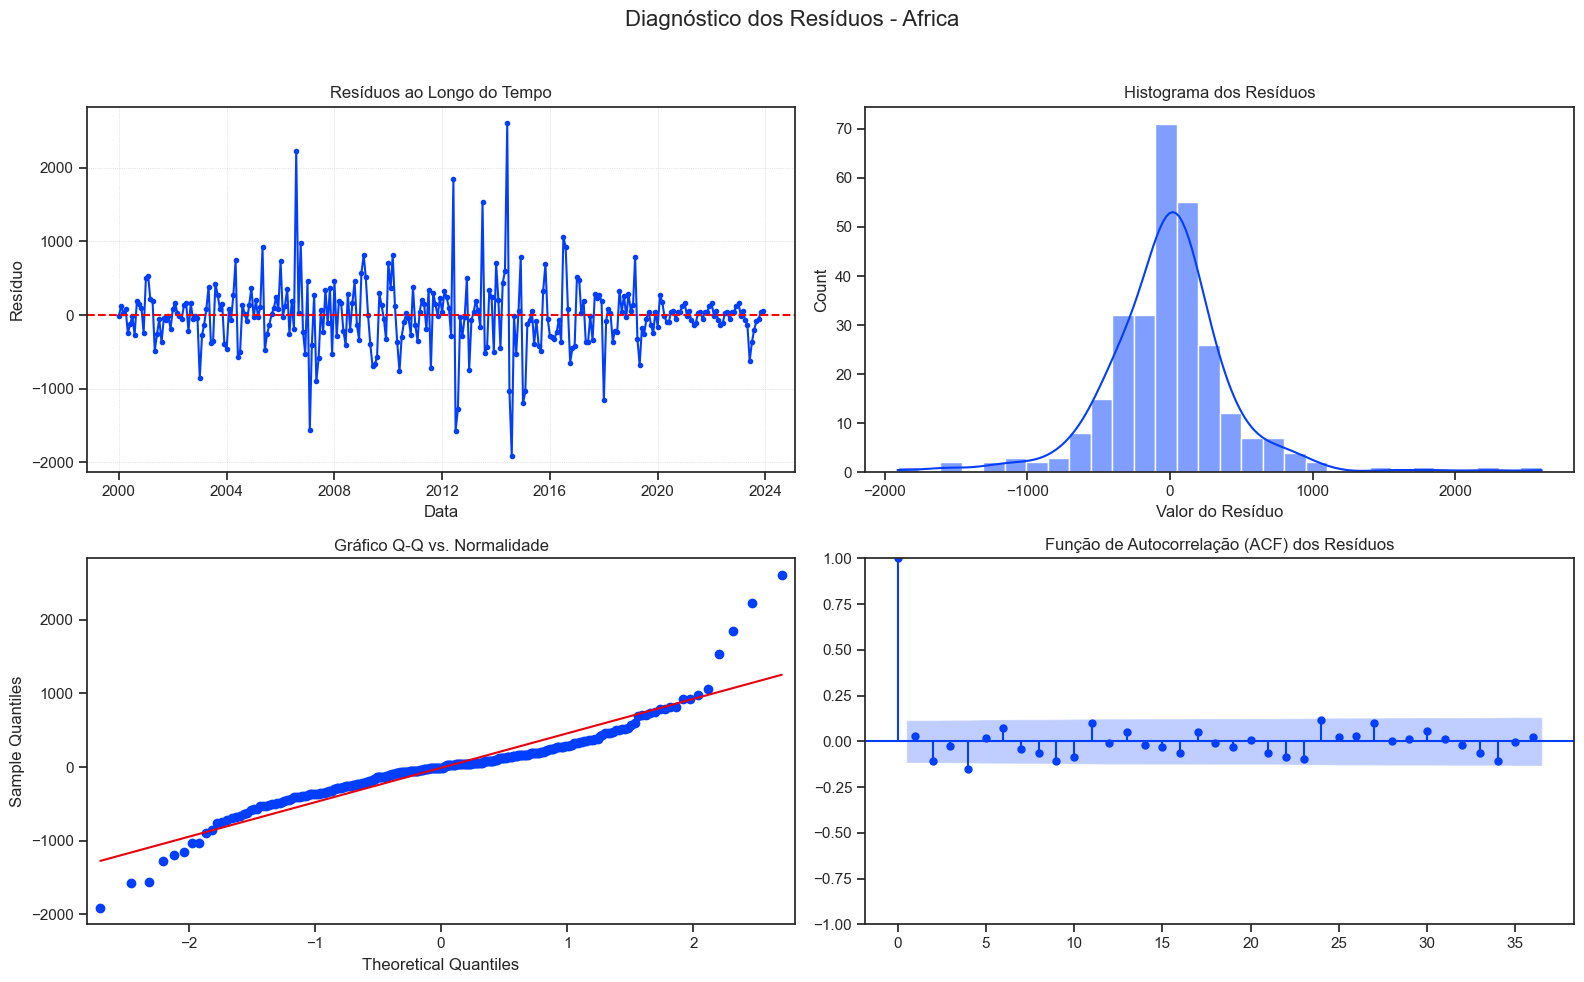


==================== America Central E Caribe ====================
Modelo Selecionado: ETS(M,A,M)

1. Teste T para Média Zero:
   p-valor: 0.2460
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0006
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0003
   ✗ FALHA: Heterocedasticidade detectada.


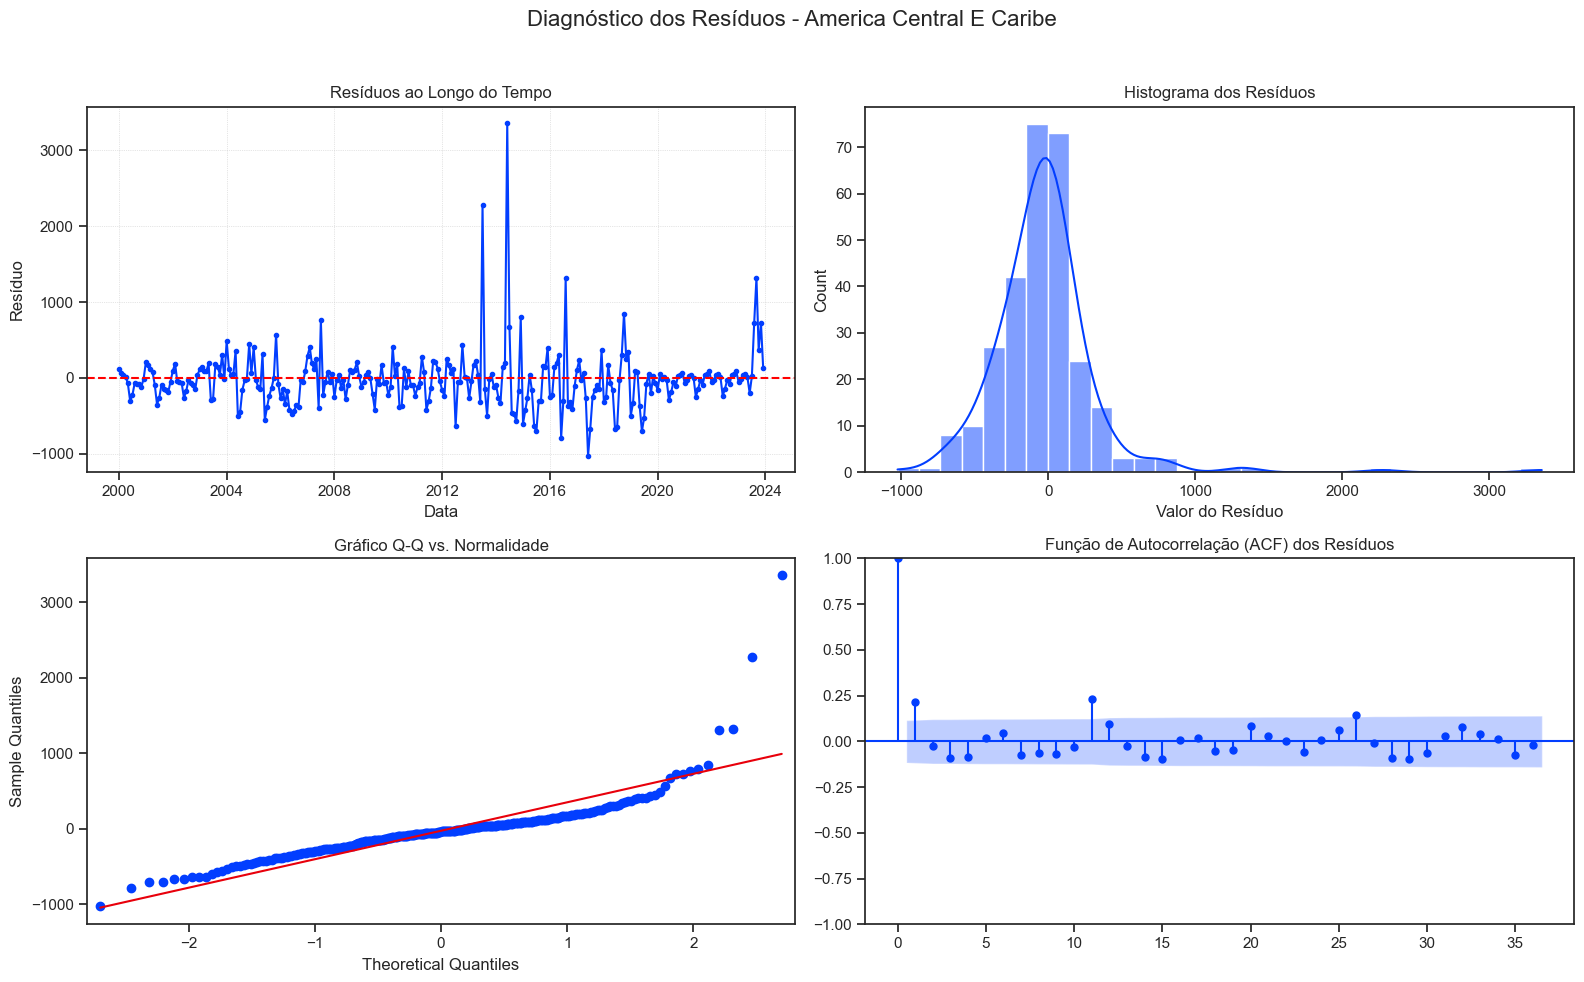


==================== America Do Norte ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.5974
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0638
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9851
   ✓ PASSA: Não há evidência de heterocedasticidade.


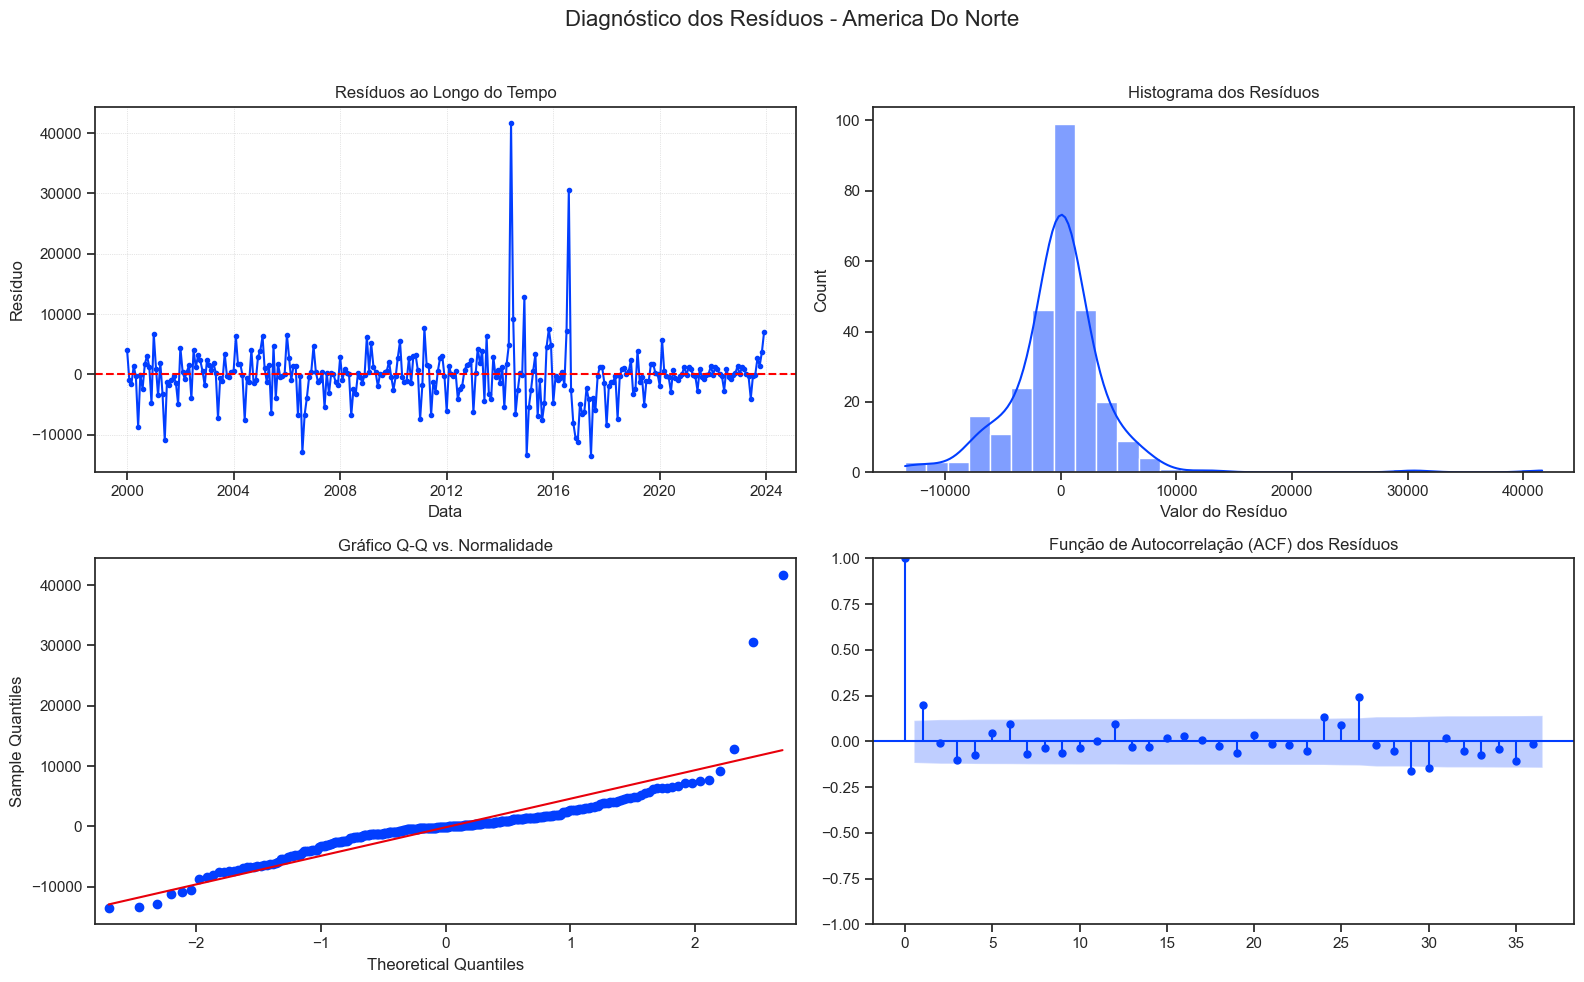


==================== America Do Sul ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.1748
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0000
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0075
   ✗ FALHA: Heterocedasticidade detectada.


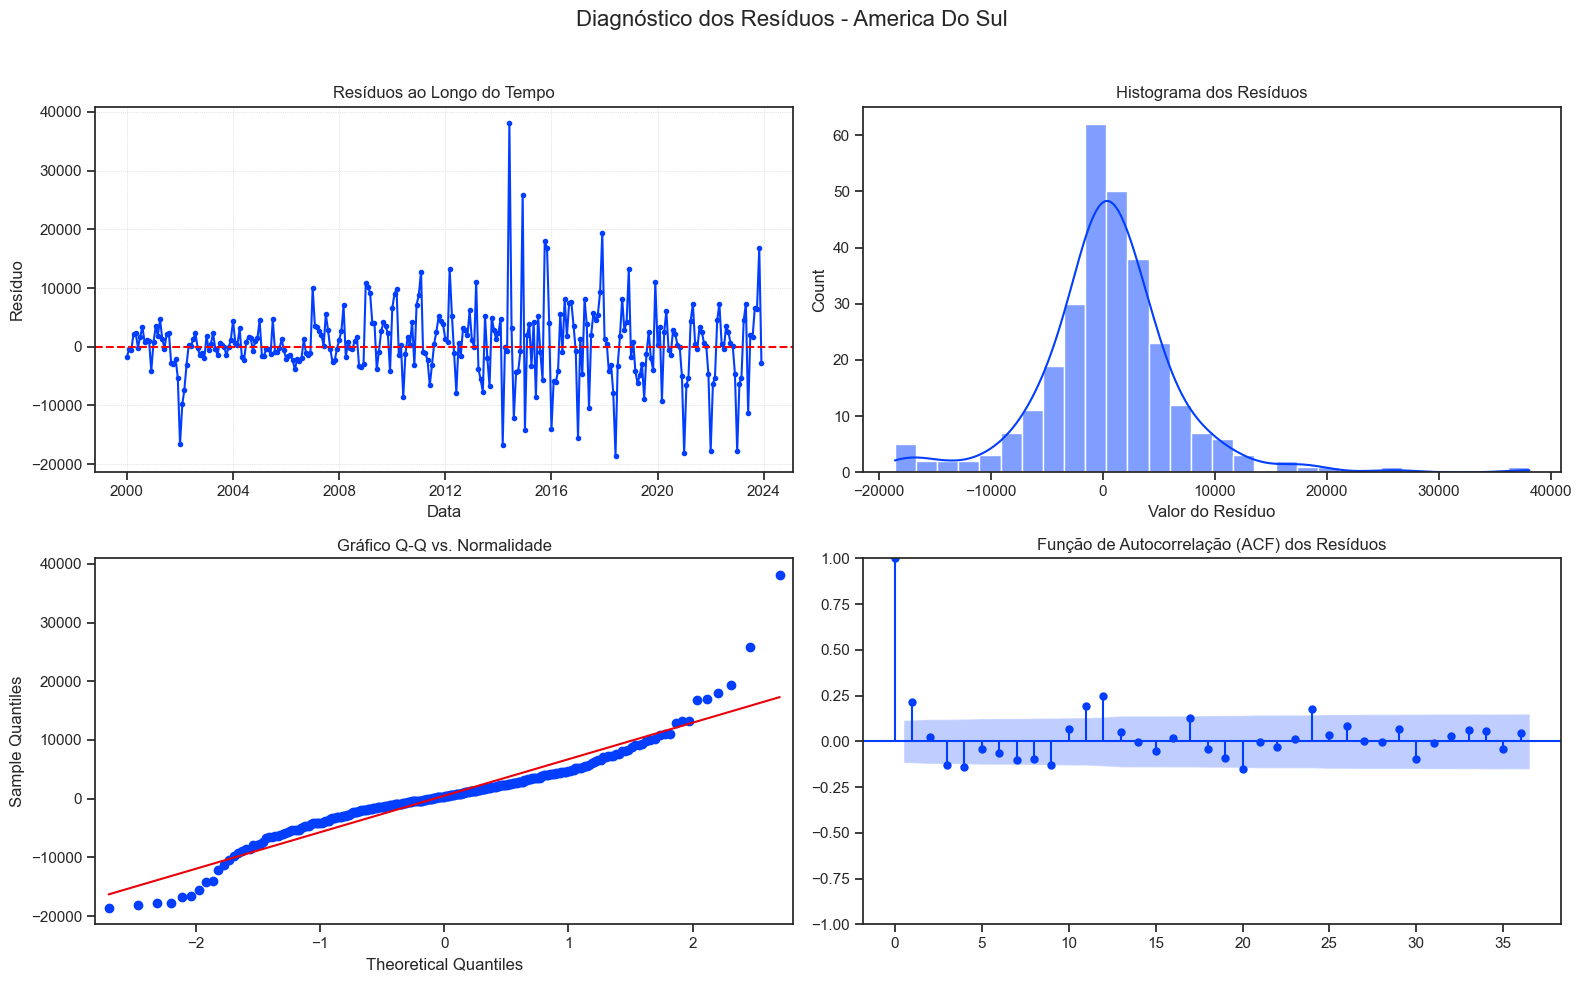


==================== Asia ====================
Modelo Selecionado: ETS(M,N,A)

1. Teste T para Média Zero:
   p-valor: 0.9931
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0000
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0249
   ✗ FALHA: Heterocedasticidade detectada.


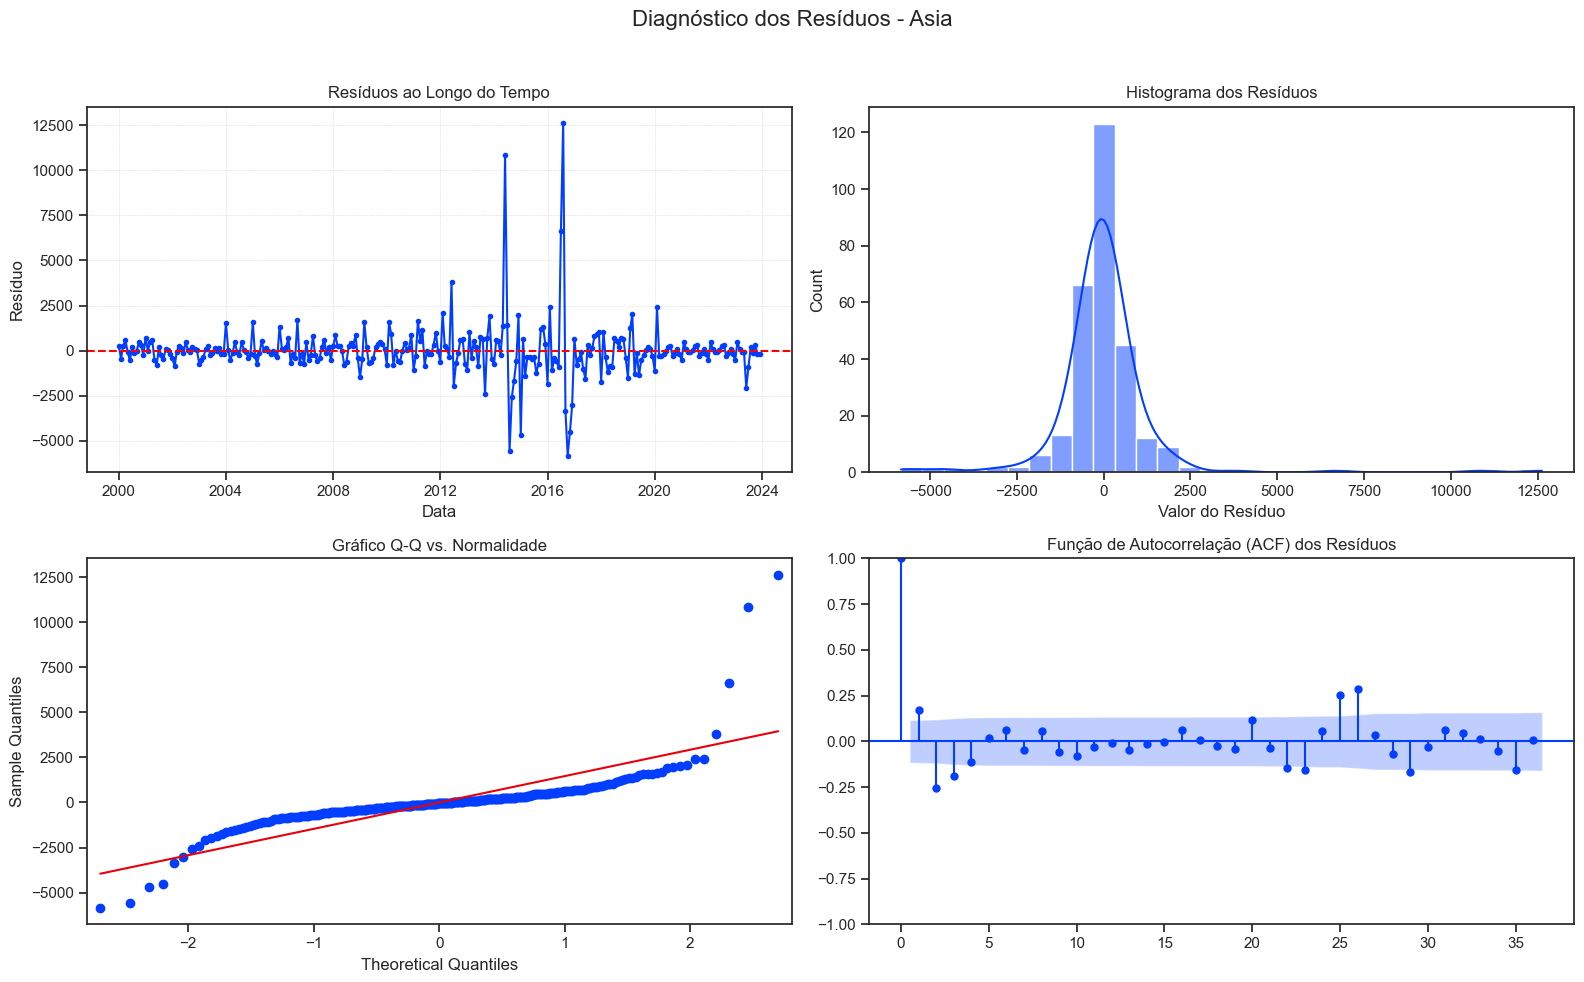


==================== Europa ====================
Modelo Selecionado: ETS(M,N,A)

1. Teste T para Média Zero:
   p-valor: 0.8471
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0002
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0000
   ✗ FALHA: Heterocedasticidade detectada.


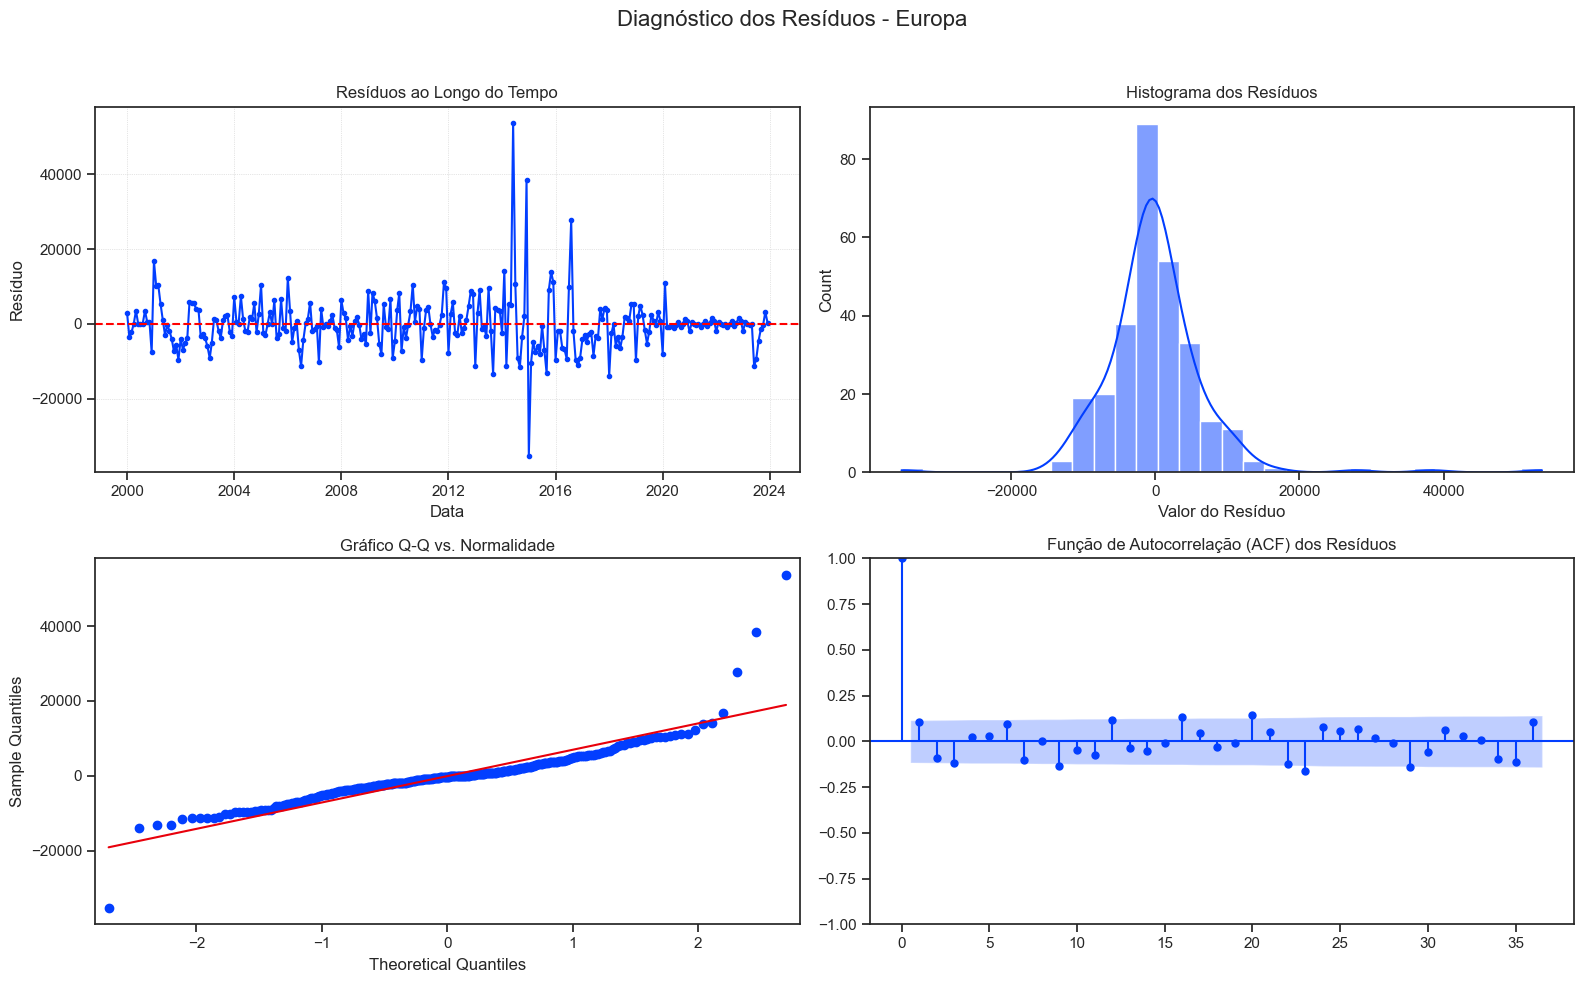


==================== Oceania ====================
Modelo Selecionado: ETS(M,N,M)

1. Teste T para Média Zero:
   p-valor: 0.7561
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.1547
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.9909
   ✓ PASSA: Não há evidência de heterocedasticidade.


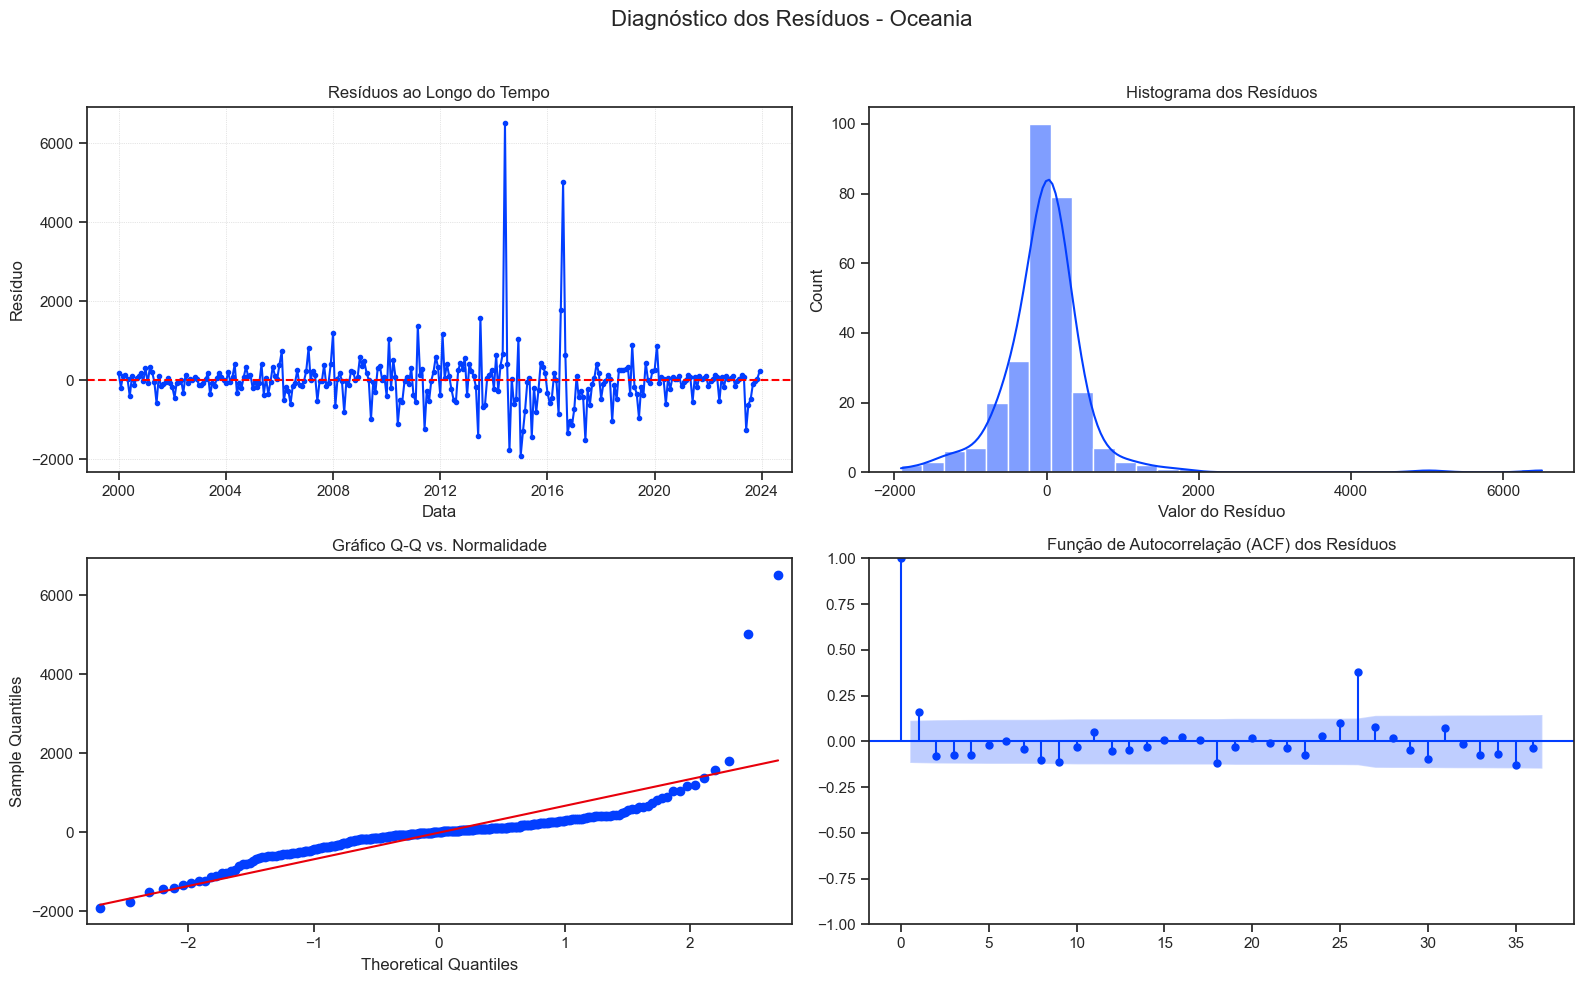

In [21]:
print("\n--- Análise de Resíduos do Modelo AutoETS por Continente ---")

# Definir os períodos de treino e teste
train_end = '2023-12-31'
test_start = '2024-01-01'

# Itera sobre cada continente para treinar um modelo e analisar seus resíduos
for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n{'='*20} {continente.replace('_', ' ').title()} {'='*20}")

    # Filtra os dados de treino para o continente atual
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()

    # Inicializa e treina o modelo AutoETS
    sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf.fit(df=train_df)
    sf.forecast(df=train_df, h=12, fitted=True)

    # Extrai os resíduos do modelo no período de treino
    # Resíduos = Valores Reais - Valores Ajustados (Fitted)
    y_true_treino = train_df['y'].values
    fitted_values_df = sf.forecast_fitted_values()
    y_pred_treino = fitted_values_df['AutoETS'].values

    residuos = y_true_treino - y_pred_treino

    print(f"Modelo Selecionado: {sf.fitted_[0][0].model_['method']}")
    
    # --- Testes Estatísticos nos Resíduos ---
    
    # 1. Teste T para Média Zero
    print("\n1. Teste T para Média Zero:")
    if len(residuos) > 1:
        t_stat, t_pvalue = ttest_1samp(residuos, 0)
        print(f"   p-valor: {t_pvalue:.4f}")
        if t_pvalue > 0.05:
            print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.")
        else:
            print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero.")
    else:
        print("   Não foi possível realizar o Teste T.")

    # 2. Teste de Ljung-Box para Autocorrelação
    print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
    if len(residuos) > 24:
        lb_test = acorr_ljungbox(residuos, lags=[24], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]
        print(f"   p-valor: {lb_pvalue:.4f}")
        if lb_pvalue > 0.01:
            print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.")
        else:
            print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.")
    else:
        print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

    # 3. Teste de Jarque-Bera para Normalidade
    print("\n3. Teste de Jarque-Bera (Normalidade):")
    if len(residuos) > 1:
        jb_stat, jb_pvalue = stats.jarque_bera(residuos)
        print(f"   p-valor: {jb_pvalue:.4f}")
        if jb_pvalue > 0.05:
            print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos.")
        else:
            print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.")
    else:
        print("   Não foi possível realizar o Teste de Jarque-Bera.")

    # 4. Teste ARCH para Heterocedasticidade
    print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
    try:
        arch_test = het_arch(residuos, nlags=12)
        arch_pvalue = arch_test[1]
        print(f"   p-valor: {arch_pvalue:.4f}")
        if arch_pvalue > 0.05:
            print("   ✓ PASSA: Não há evidência de heterocedasticidade.")
        else:
            print("   ✗ FALHA: Heterocedasticidade detectada.")
    except Exception as e:
        print(f"   Não foi possível realizar o Teste ARCH: {e}")

    # --- Plots de Diagnóstico ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Diagnóstico dos Resíduos - {continente.replace("_", " ").title()}', fontsize=16)

    # Plot 1: Resíduos ao longo do tempo
    axes[0, 0].plot(train_df['ds'], residuos, marker='o', linestyle='-', markersize=3)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Resíduos ao Longo do Tempo')
    axes[0, 0].set_xlabel('Data')
    axes[0, 0].set_ylabel('Resíduo')
    axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Plot 2: Histograma dos resíduos
    sns.histplot(residuos, kde=True, ax=axes[0, 1], bins=30)
    axes[0, 1].set_title('Histograma dos Resíduos')
    axes[0, 1].set_xlabel('Valor do Resíduo')

    # Plot 3: Gráfico Q-Q (Quantil-Quantil)
    sm.qqplot(residuos, line='s', ax=axes[1, 0])
    axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

    # Plot 4: Gráfico de Autocorrelação (ACF)
    sm.graphics.tsa.plot_acf(residuos, ax=axes[1, 1], lags=36)
    axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

--- Verificando Autocorrelação nos Resíduos do AutoETS por Continente ---
✓ Africa: Sem autocorrelação significativa (p-valor=0.0432).
RMSE teste: 124.57
MAPE teste: 26.91%
MAE teste: 103.54
CSV salvo (ETS): forecast_ets_africa.csv (linhas: 300)
✗ America_Central_E_Caribe: Autocorrelação detectada (p-valor=0.0006). Adicionando ao modelo híbrido.
✓ America_Do_Norte: Sem autocorrelação significativa (p-valor=0.0638).
RMSE teste: 6161.04
MAPE teste: 24.87%
MAE teste: 5015.30
CSV salvo (ETS): forecast_ets_america_do_norte.csv (linhas: 300)
✗ America_Do_Sul: Autocorrelação detectada (p-valor=0.0000). Adicionando ao modelo híbrido.
✗ Asia: Autocorrelação detectada (p-valor=0.0000). Adicionando ao modelo híbrido.
✗ Europa: Autocorrelação detectada (p-valor=0.0002). Adicionando ao modelo híbrido.
✓ Oceania: Sem autocorrelação significativa (p-valor=0.1547).
RMSE teste: 469.27
MAPE teste: 42.24%
MAE teste: 421.32
CSV salvo (ETS): forecast_ets_oceania.csv (linhas: 300)

--- Construindo Modelos H

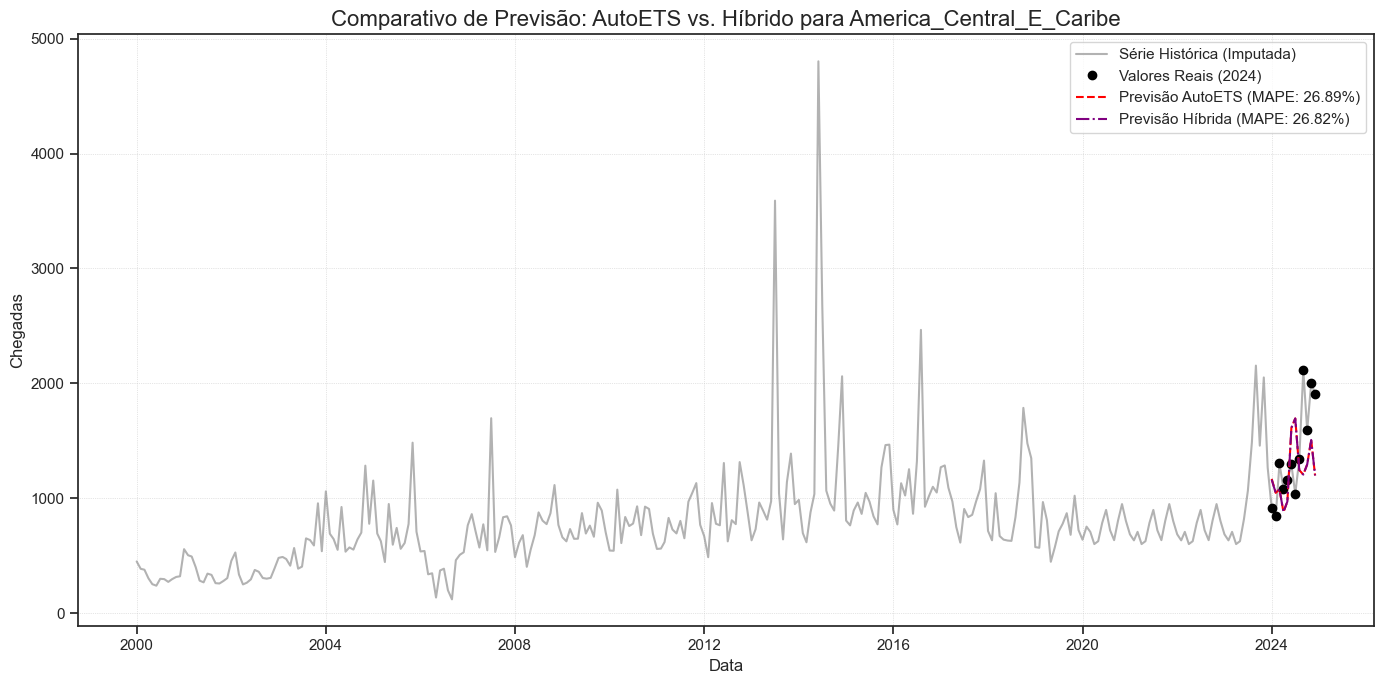


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ETS: ETS(M,A,M) Modelo ARIMA nos Resíduos: (0, 1, 0, 0, 1, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.3332
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0489
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0001
   ✗ FALHA: Heterocedasticidade detectada.
Exportação separada do AutoETS ignorada; será exportado somente o modelo Híbrido.
CSV salvo: forecast_models_america_central_e_caribe.csv (linhas: 300)


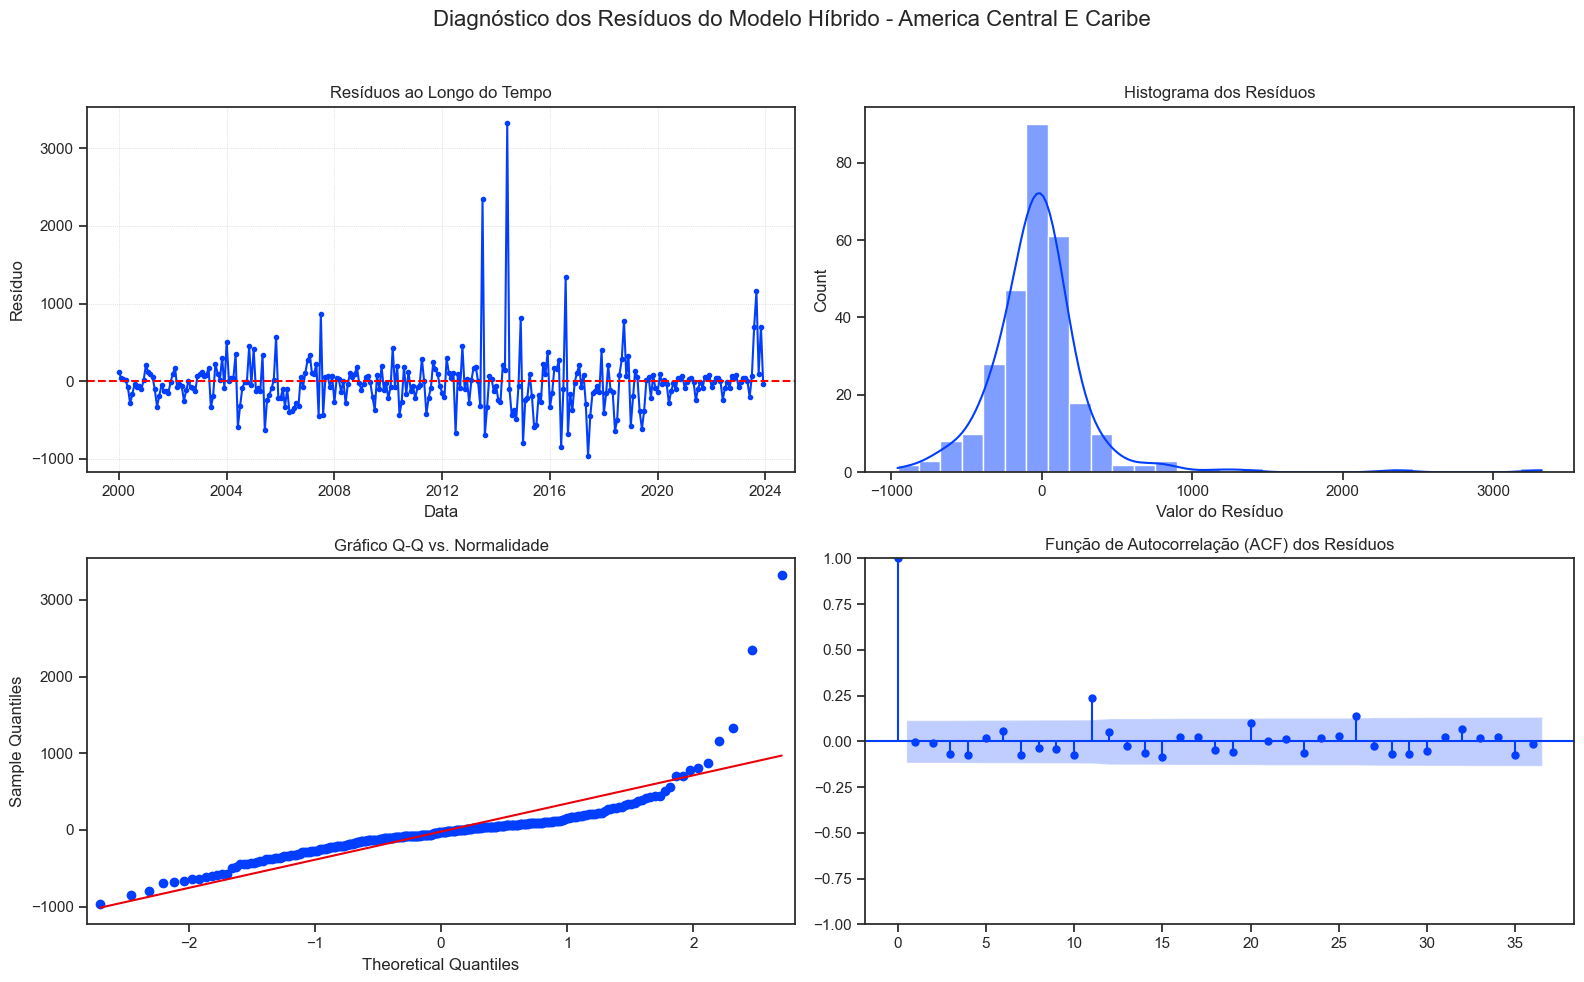


==================== Modelo Híbrido para: America_Do_Sul ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS          -> RMSE: 16910.41, MAPE: 15.51%
Híbrido (ETS+ARIMA) -> RMSE: 17860.45, MAPE: 16.13%, MAE: 13916.63


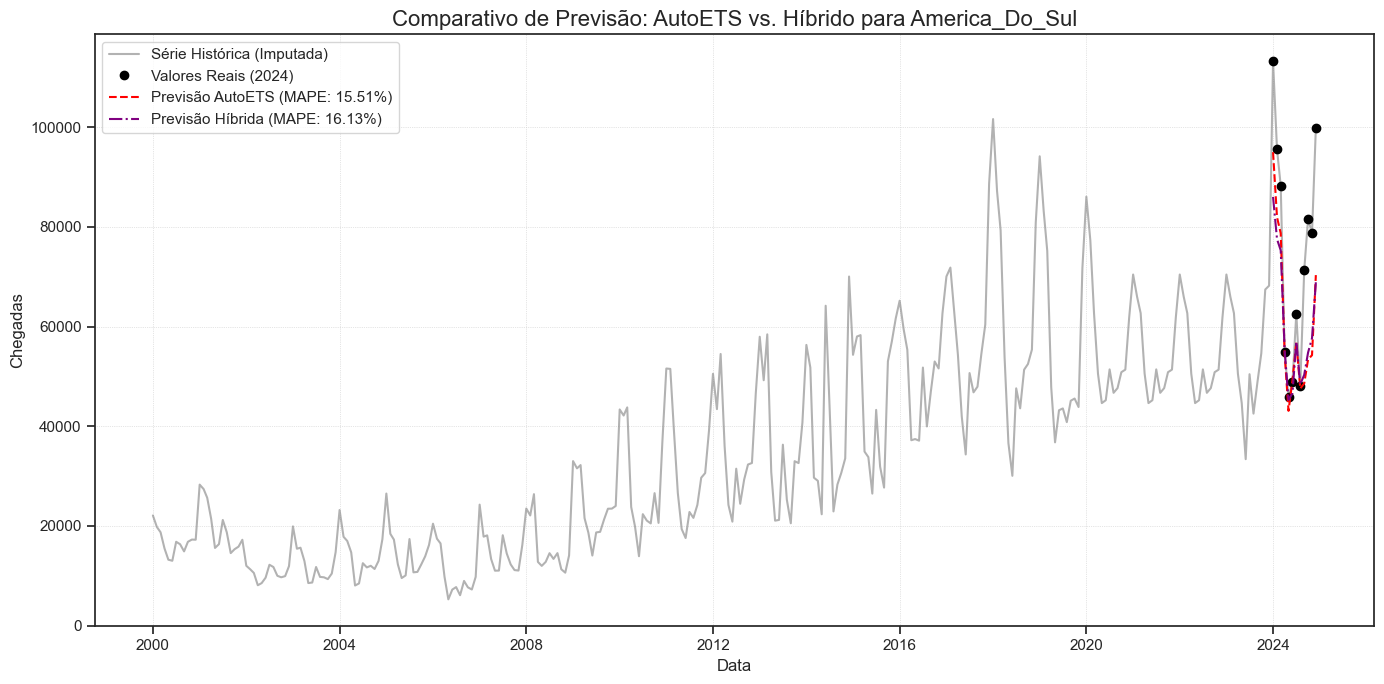


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ETS: ETS(M,N,M) Modelo ARIMA nos Resíduos: (2, 1, 2, 0, 12, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.2970
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0468
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0009
   ✗ FALHA: Heterocedasticidade detectada.
Exportação separada do AutoETS ignorada; será exportado somente o modelo Híbrido.
CSV salvo: forecast_models_america_do_sul.csv (linhas: 300)


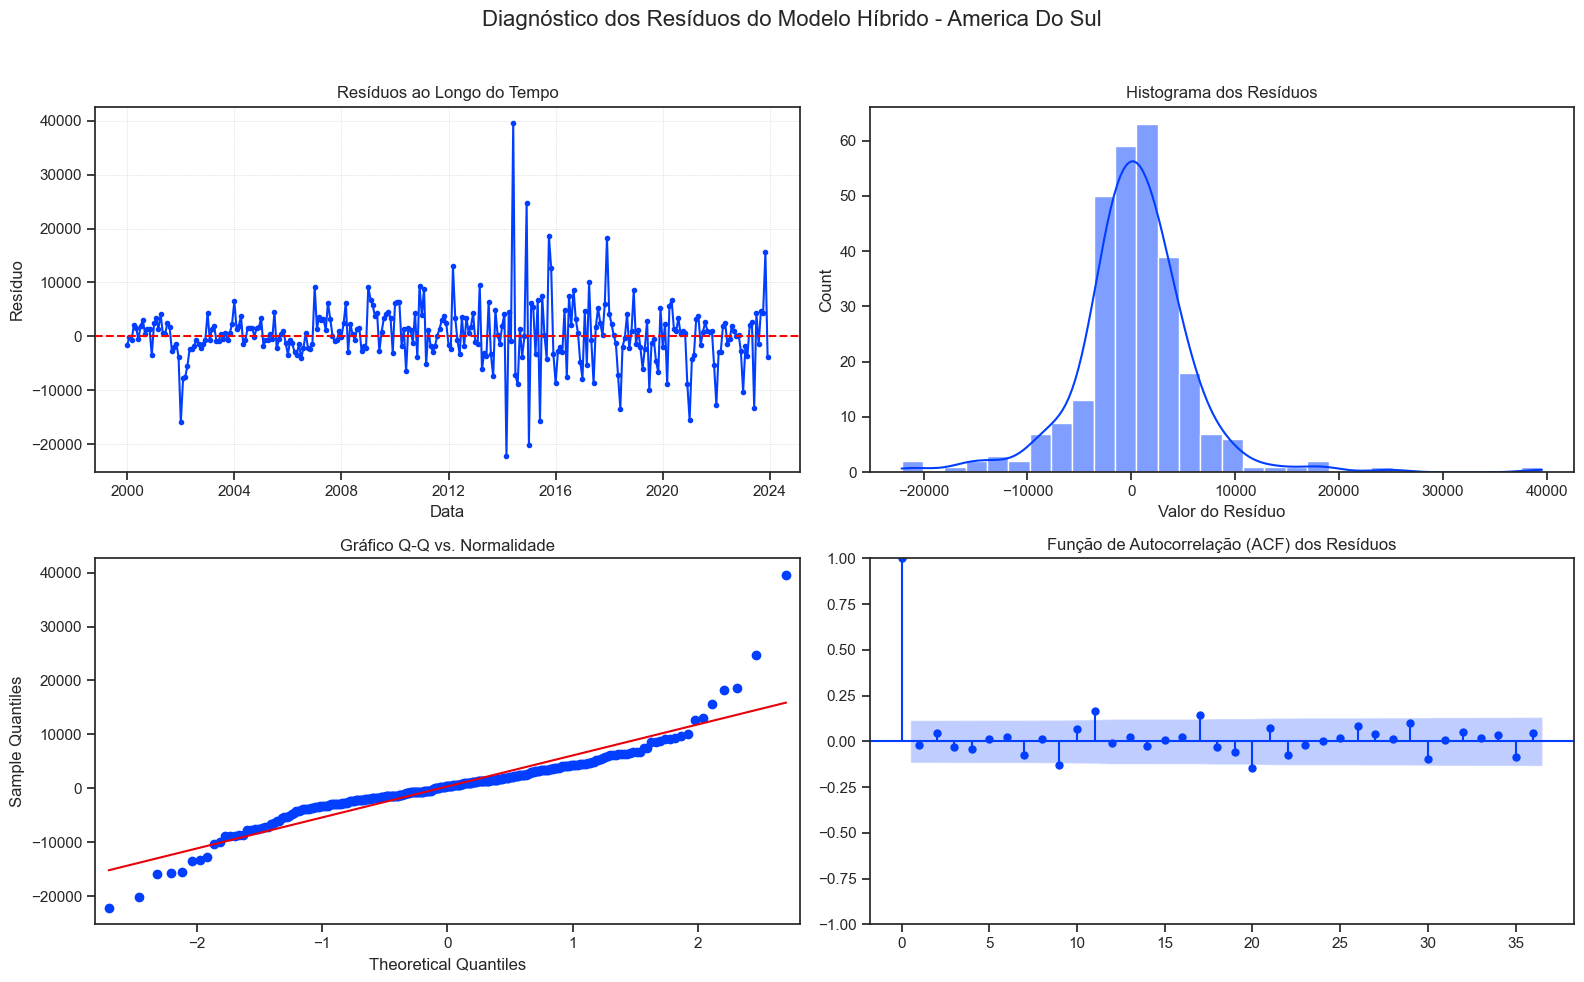


==================== Modelo Híbrido para: Asia ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS          -> RMSE: 1258.71, MAPE: 29.18%
Híbrido (ETS+ARIMA) -> RMSE: 1248.92, MAPE: 28.74%, MAE: 843.99


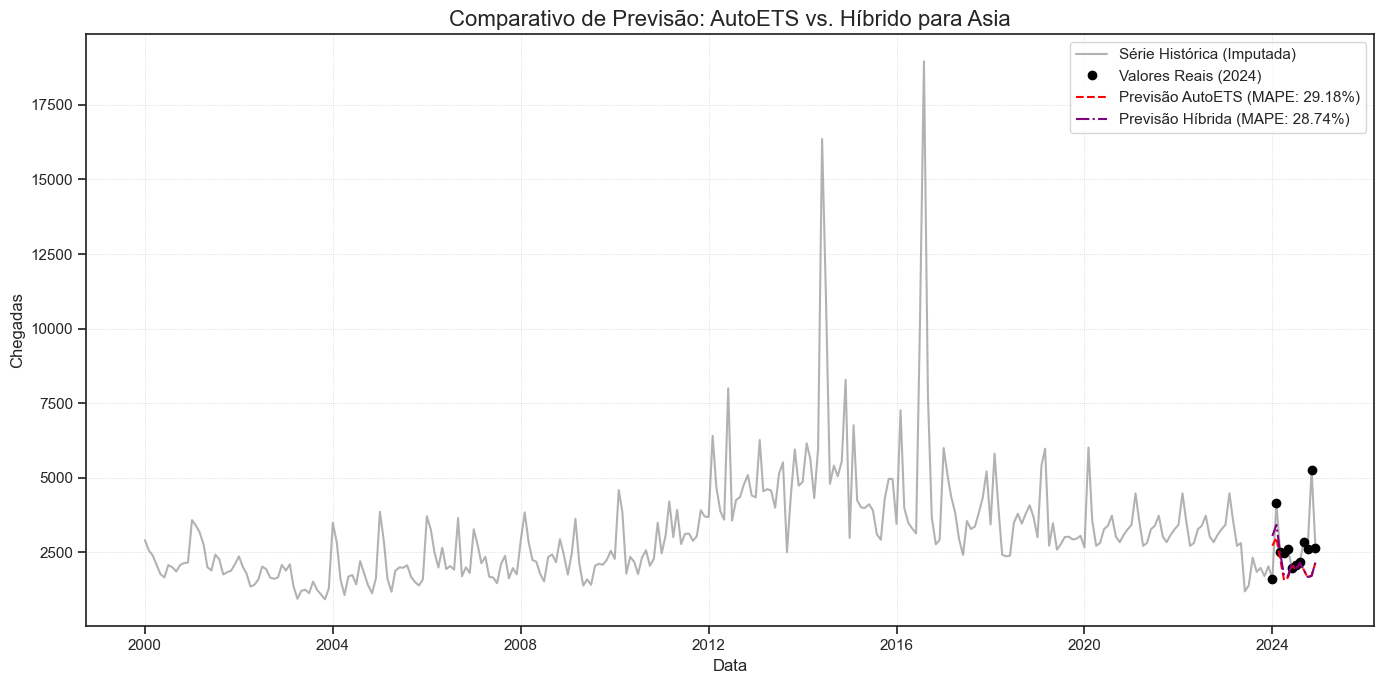


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ETS: ETS(M,N,A) Modelo ARIMA nos Resíduos: (2, 3, 0, 0, 1, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.8652
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.6620
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0979
   ✓ PASSA: Não há evidência de heterocedasticidade.
Exportação separada do AutoETS ignorada; será exportado somente o modelo Híbrido.
CSV salvo: forecast_models_asia.csv (linhas: 300)


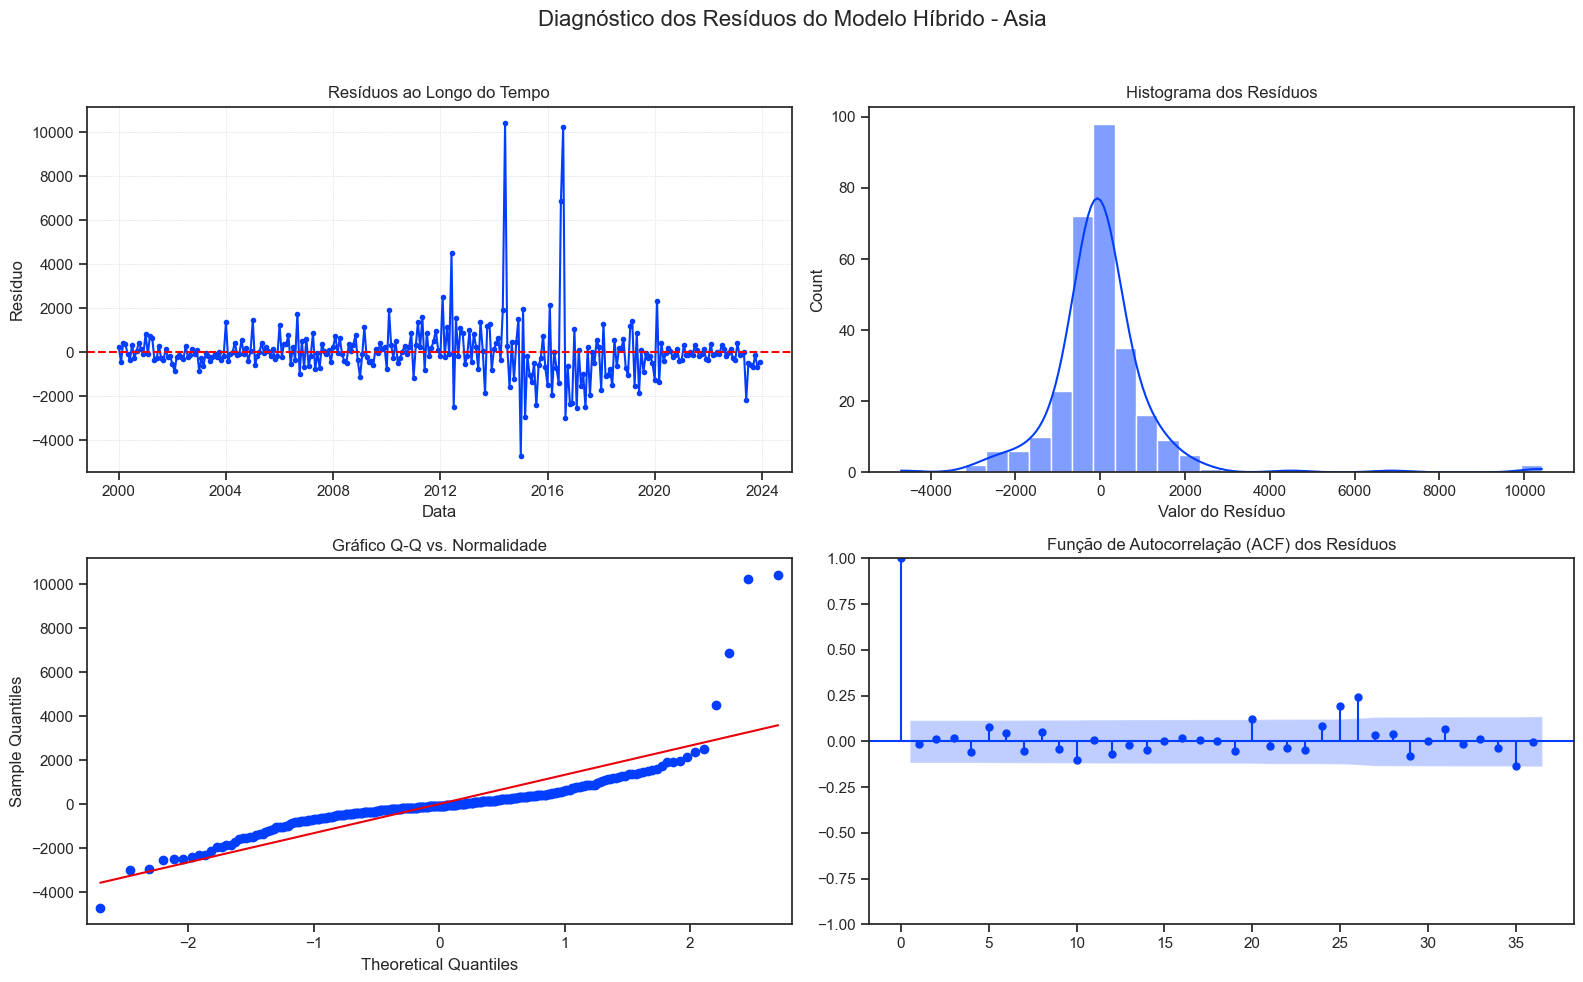


==================== Modelo Híbrido para: Europa ====================

--- Comparação de Performance no Teste (2024) ---
AutoETS          -> RMSE: 5663.36, MAPE: 16.22%
Híbrido (ETS+ARIMA) -> RMSE: 5508.58, MAPE: 15.05%, MAE: 4727.29


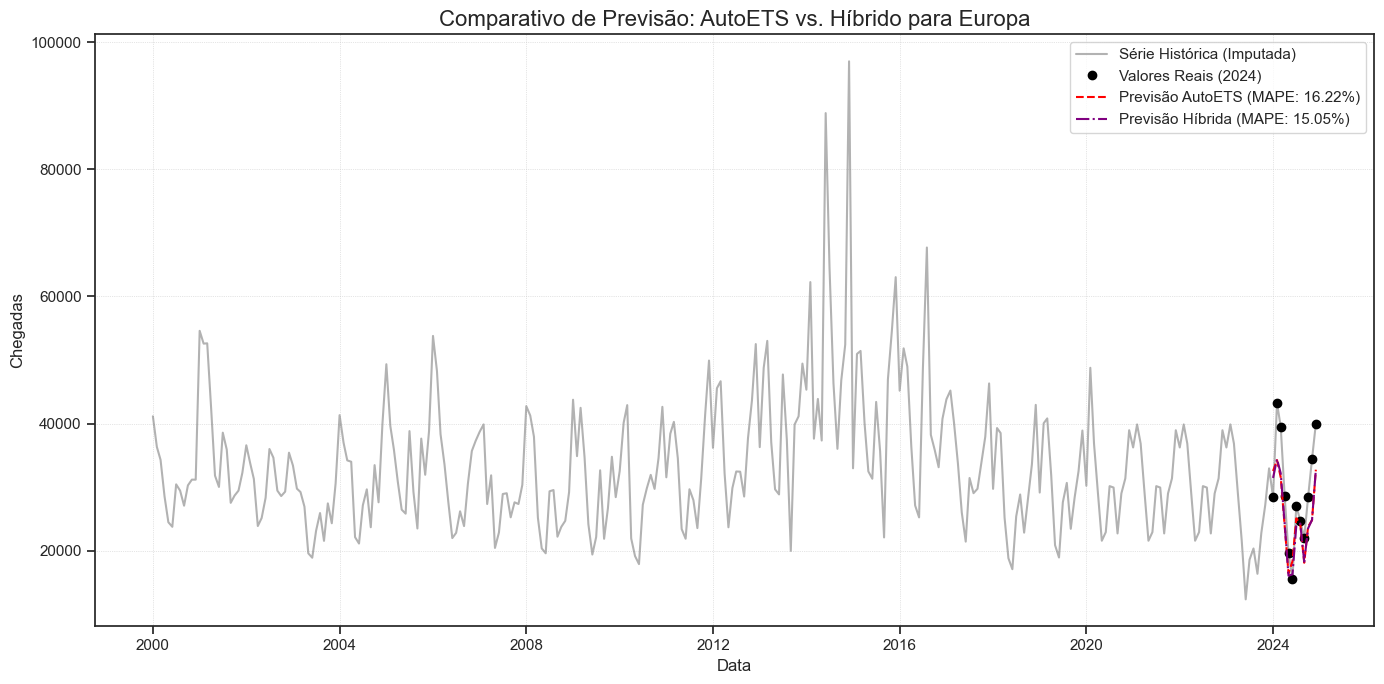


--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---
Modelo ETS: ETS(M,N,A) Modelo ARIMA nos Resíduos: (2, 2, 2, 0, 12, 0, 0)

1. Teste T para Média Zero:
   p-valor: 0.8374
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0880
   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.

3. Teste de Jarque-Bera (Normalidade):
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.0000
   ✗ FALHA: Heterocedasticidade detectada.
Exportação separada do AutoETS ignorada; será exportado somente o modelo Híbrido.
CSV salvo: forecast_models_europa.csv (linhas: 300)


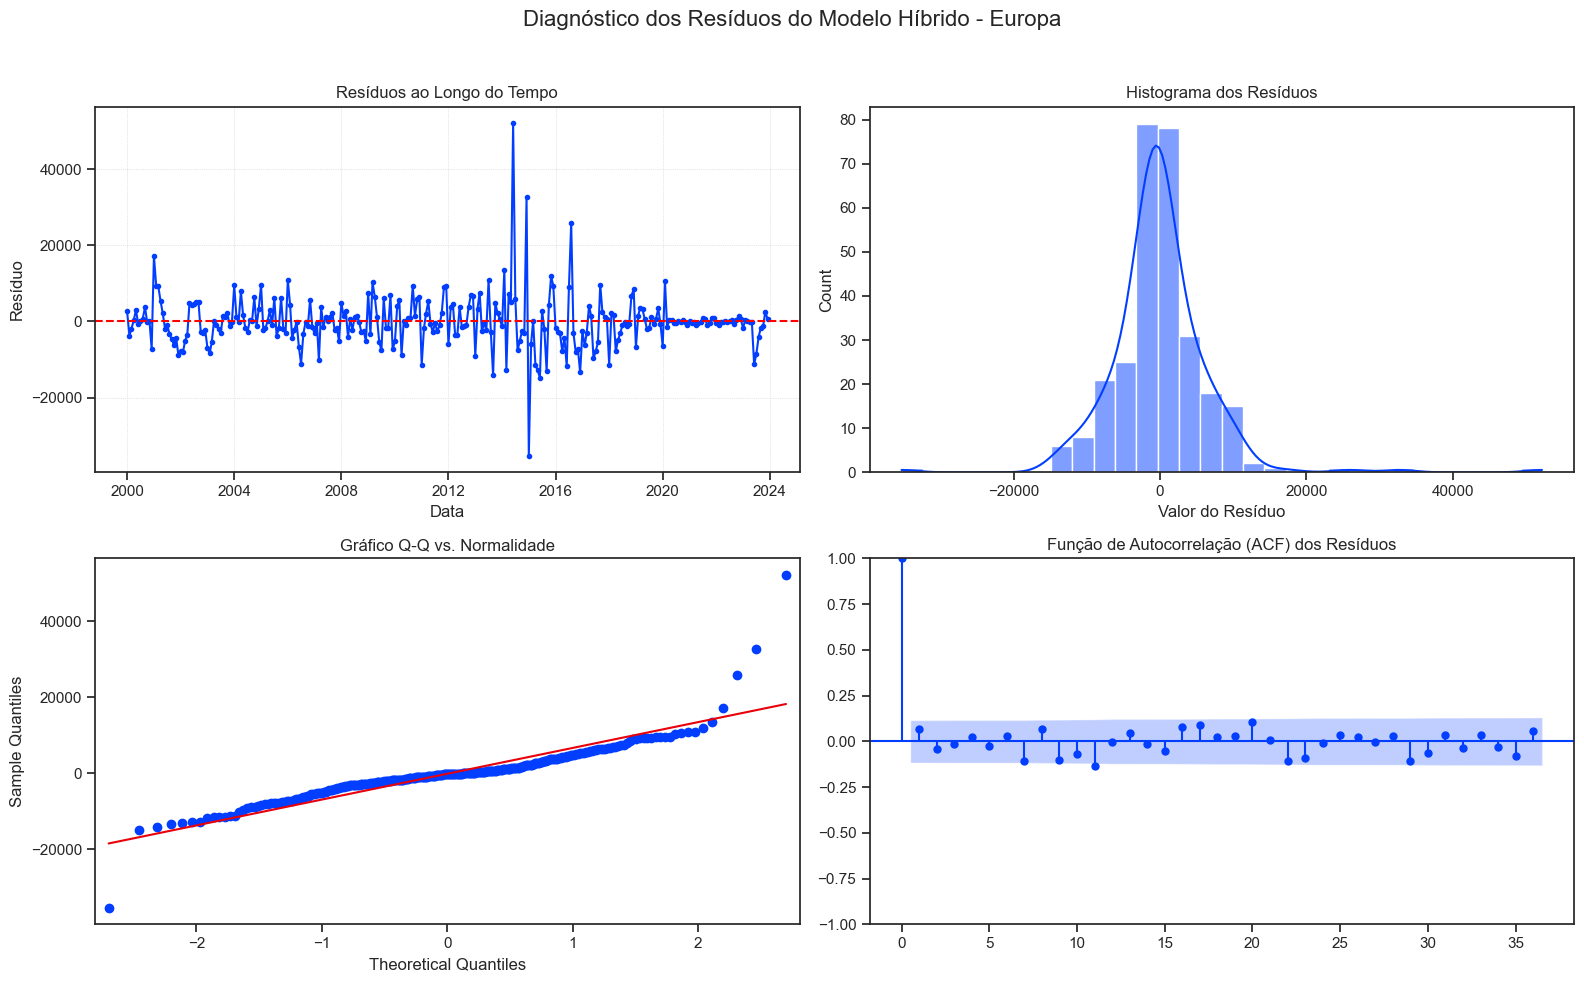

In [22]:
# --- NOTA: Variáveis de Exemplo (Substitua pelos seus dados reais) ---
# O código abaixo assume que as seguintes variáveis JÁ EXISTEM no seu ambiente:
#
# Y_df_h_imputado: DataFrame no formato StatsForecast (unique_id, ds, y)
# train_end: Data de corte para treino (ex: pd.to_datetime('2023-12-31'))
# test_start: Data de início do teste (ex: pd.to_datetime('2024-01-01'))
# test_end: Data de fim do teste (ex: pd.to_datetime('2024-12-31'))
# series_por_continente: Dicionário de Series (ex: {'asia': pd.Series(...)})
# imputed_continent_series: Dicionário de Series (usado no plot)
#
# Certifique-se de que elas estejam carregadas antes de rodar.
# ---------------------------------------------------------------------


# --- Identificação dos Continentes com Autocorrelação nos Resíduos ---

print("--- Verificando Autocorrelação nos Resíduos do AutoETS por Continente ---")

continents_for_hybrid = []
# Itera sobre cada continente para verificar o teste de Ljung-Box
for continente in Y_df_h_imputado['unique_id'].unique():
    # Filtra os dados de treino
    train_df_check = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()

    teste_df_check = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] >= test_start) &
        (Y_df_h_imputado['ds'] <= test_end)
    ].copy()

    # Checagem de dados suficientes para o teste
    if train_df_check.empty or len(train_df_check) <= 24:
        print(f"- {continente.title()}: Dados insuficientes para o teste de Ljung-Box.")
        continue

    # Treina o modelo AutoETS para obter os resíduos
    sf_ets_check = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf_ets_check.fit(df=train_df_check)
    
    # Executa forecast com fitted=True para popular os valores ajustados internamente.
    # Aqui usamos h=1 (um passo à frente) apenas para garantir que os fitted values
    # estejam disponíveis para forecast_fitted_values().
    sf_ets_check.forecast(df=train_df_check, h=12, fitted=True)
    forecast_df = sf_ets_check.forecast(df=train_df_check, h=12, fitted=True)

    # Obter valores ajustados (fitted)
    fitted_values_df = sf_ets_check.forecast_fitted_values()
    y_pred_test = forecast_df['AutoETS'].values
    # Merge para alinhar dados reais e ajustados
    merged_df = pd.merge(train_df_check, fitted_values_df, on=['unique_id', 'ds'], how='inner')
    
    # Calcular resíduos e remover NaNs (comuns no início)
    residuos = (merged_df['y_y'] - merged_df['AutoETS']).dropna()

    # Realiza o teste de Ljung-Box
    if len(residuos) > 24:
        lb_test = acorr_ljungbox(residuos, lags=[24], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]
        
        # Se o p-valor for menor que 0.01, há autocorrelação
        if lb_pvalue < 0.01:
            print(f"✗ {continente.title()}: Autocorrelação detectada (p-valor={lb_pvalue:.4f}). Adicionando ao modelo híbrido.")
            continents_for_hybrid.append(continente)
        else:
            print(f"✓ {continente.title()}: Sem autocorrelação significativa (p-valor={lb_pvalue:.4f}).")
            print(f"RMSE teste: {np.sqrt(mean_squared_error(teste_df_check['y'], y_pred_test)):.2f}")
            print(f"MAPE teste: {mean_absolute_percentage_error(teste_df_check['y'], y_pred_test) * 100:.2f}%")
            print(f"MAE teste: {mean_absolute_error(teste_df_check['y'], y_pred_test):.2f}")
                    # Exportar previsão AutoETS para este continente (CSV)
            try:
                # Obter série de teste e definir horizonte
                test_series_check = series_por_continente[continente].loc[test_start:test_end]
                y_true_test_check = test_series_check.values
                h_check = len(y_true_test_check) if len(y_true_test_check) > 0 else 12

                # Fazer forecast futuro com o modelo já ajustado (sf_ets_check)
                forecast_ets_check = sf_ets_check.forecast(df=train_df_check, h=h_check, fitted=True)
                y_pred_ets_check = forecast_ets_check['AutoETS'].values

                # Datas de forecast
                # Construir datas e séries para todo o período (treino ajustado + horizonte de previsão)
                # Datas/valores do treino alinhado (merged_df contém 'ds', 'y_y', 'AutoETS')
                dates_train = pd.to_datetime(merged_df['ds']).reset_index(drop=True)
                actual_train = merged_df['y_y'].values
                fitted_train = merged_df['AutoETS'].values

                # Datas e valores do horizonte de previsão (futuro)
                dates_forecast = pd.to_datetime(forecast_ets_check['ds']).reset_index(drop=True)
                forecast_vals = y_pred_ets_check

                # Concatenar datas (treino + forecast)
                dates_check = pd.concat([dates_train, dates_forecast]).reset_index(drop=True)

                # Concatenar valores reais (treino alinhado + teste). Se não houver dados de teste, preenche com NaN.
                if isinstance(y_true_test_check, np.ndarray) and len(y_true_test_check) > 0:
                    actual_check = np.concatenate([actual_train, y_true_test_check])
                else:
                    actual_check = np.concatenate([actual_train, np.full(len(dates_forecast), np.nan)])

                # Concatenar previsões (fitted no treino + forecast no futuro)
                forecast_check = np.concatenate([fitted_train, forecast_vals])

                # Sobrescrever as variáveis usadas logo abaixo para exportar o período completo
                y_true_test_check = actual_check
                y_pred_ets_check = forecast_check

                # Construir DataFrame de saída (apenas ETS)
                df_ets_out_check = pd.DataFrame({
                    'date': dates_check,
                    'continent': continente,
                    'actual': y_true_test_check,
                    'forecast': y_pred_ets_check,
                })
                df_ets_out_check['error'] = df_ets_out_check['forecast'] - df_ets_out_check['actual']
                df_ets_out_check['abs_error'] = df_ets_out_check['error'].abs()
                df_ets_out_check['pct_error'] = np.where(
                    df_ets_out_check['actual'] != 0,
                    df_ets_out_check['error'] / df_ets_out_check['actual'] * 100,
                    np.nan
                )
                df_ets_out_check['ets_model'] = sf_ets_check.fitted_[0][0].model_['method']
                df_ets_out_check['model_type'] = 'AutoETS'

                csv_filename_check = f'forecast_ets_{continente}.csv'
                df_ets_out_check.to_csv(csv_filename_check, index=False)
                print(f"CSV salvo (ETS): {csv_filename_check} (linhas: {len(df_ets_out_check)})")

                # Acumular no results_all se desejar consolidar depois
                if 'results_all' not in globals():
                    results_all = []
                results_all.append(df_ets_out_check)

            except Exception as e:
                print(f"Erro ao exportar CSV ETS para {continente}: {e}")
    else:
        print(f"- {continente.title()}: Dados insuficientes para o teste após ajuste do modelo.")


# --- Construção do Modelo Híbrido para os Continentes Selecionados ---

print("\n--- Construindo Modelos Híbridos (ETS+ARIMA) ---")

if not continents_for_hybrid:
    print("Nenhum continente apresentou autocorrelação nos resíduos. Modelo híbrido não é necessário.")
else:
    for continente in continents_for_hybrid:
        print(f"\n{'='*20} Modelo Híbrido para: {continente.title()} {'='*20}")

        # 1. Preparar os dados de treino e teste
        train_df = Y_df_h_imputado[
            (Y_df_h_imputado['unique_id'] == continente) & 
            (Y_df_h_imputado['ds'] <= train_end)
        ].copy()
        
        test_series = series_por_continente[continente].loc[test_start:test_end]
        y_true_teste = test_series.values

        # 2. Treinar o modelo AutoETS base
        sf_ets = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
        sf_ets.fit(df=train_df)
        
        # Previsão (Futuro)
        forecast_ets = sf_ets.forecast(df=train_df, h=12, fitted=True)
        y_pred_ets = forecast_ets['AutoETS'].values

        # Valores Ajustados (Passado/Treino)
        fitted_values_ets_df = sf_ets.forecast_fitted_values()
        
        # Garantir alinhamento entre dados reais e ajustados via merge pelo 'ds'
        df_analise_ets = pd.merge(train_df, fitted_values_ets_df, on=['unique_id', 'ds'], how='inner')
        
        y_true_treino_aligned = df_analise_ets['y_y'].values
        y_pred_treino_ets = df_analise_ets['AutoETS'].values
        
        # Cálculo dos resíduos do ETS (Treino)
        residuos_ets = y_true_treino_aligned - y_pred_treino_ets

        # Métricas do modelo ETS original (Teste)
        mape_ets = mean_absolute_percentage_error(y_true_teste, y_pred_ets) * 100
        rmse_ets = np.sqrt(mean_squared_error(y_true_teste, y_pred_ets))

        # DataFrame com os resíduos do ETS para treinar o ARIMA
        df_residuos = pd.DataFrame({
            'unique_id': f'{continente}_residuos',
            'ds': df_analise_ets['ds'], # Usar o ds alinhado
            'y': residuos_ets
        }).dropna() # Importante: remover NaNs gerados pelo modelo no início

        # 3. Treinar AutoARIMA nos resíduos
        sf_arima_residuos = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS', n_jobs=1)
        sf_arima_residuos.fit(df=df_residuos)
        
        # Previsão dos resíduos (Futuro)
        forecast_residuos = sf_arima_residuos.forecast(df=df_residuos, h=12, fitted=True)

        # 4. Criar a previsão híbrida (Futuro)
        y_pred_hibrido = y_pred_ets + forecast_residuos['AutoARIMA'].values

        # 5. Calcular métricas para o modelo híbrido (Teste)
        mape_hibrido = mean_absolute_percentage_error(y_true_teste, y_pred_hibrido) * 100
        rmse_hibrido = np.sqrt(mean_squared_error(y_true_teste, y_pred_hibrido))
        mae_hibrido = mean_absolute_error(y_true_teste, y_pred_hibrido)

        print("\n--- Comparação de Performance no Teste (2024) ---")
        print(f"AutoETS          -> RMSE: {rmse_ets:.2f}, MAPE: {mape_ets:.2f}%")
        print(f"Híbrido (ETS+ARIMA) -> RMSE: {rmse_hibrido:.2f}, MAPE: {mape_hibrido:.2f}%, MAE: {mae_hibrido:.2f}")

        # 6. Plotar os resultados
        plt.figure(figsize=(14, 7))
        # Use 'imputed_continent_series' se for a série completa, ou 'train_df' para apenas o treino
        plt.plot(imputed_continent_series[continente], label='Série Histórica (Imputada)', color='gray', alpha=0.6)
        plt.plot(test_series.index, test_series.values, label='Valores Reais (2024)', color='black', marker='o', linestyle='None')
        plt.plot(forecast_ets['ds'], y_pred_ets, label=f'Previsão AutoETS (MAPE: {mape_ets:.2f}%)', color='red', linestyle='--')
        plt.plot(forecast_ets['ds'], y_pred_hibrido, label=f'Previsão Híbrida (MAPE: {mape_hibrido:.2f}%)', color='purple', linestyle='-.')
        
        plt.title(f'Comparativo de Previsão: AutoETS vs. Híbrido para {continente.title()}', fontsize=16)
        plt.xlabel('Data')
        plt.ylabel('Chegadas')
        plt.legend()
        plt.grid(True, which='both', linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # --- Análise de Resíduos do Modelo Híbrido ---
        print("\n--- Análise de Resíduos do Modelo Híbrido (ETS+ARIMA) ---")
        
        # Obter fitted values do ARIMA nos resíduos (Treino)
        fitted_values_arima_res = sf_arima_residuos.forecast_fitted_values()
        
        # Merge para garantir alinhamento entre ETS Fitted e ARIMA Residuals Fitted
        df_hibrido_check = pd.merge(
            df_analise_ets, # Contém 'ds', 'y' (real), 'AutoETS' (fitted ETS)
            fitted_values_arima_res[['ds', 'AutoARIMA']], 
            on='ds', 
            how='inner',
            suffixes=('', '_res')
        )
        
        # Cálculo do Fitted Híbrido: Fitted ETS + Fitted ARIMA dos Resíduos
        y_fitted_hibrido = df_hibrido_check['AutoETS'].values + df_hibrido_check['AutoARIMA'].values
        
        # Cálculo do Resíduo Final Híbrido: Real - Fitted Híbrido
        hybrid_residuals = df_hibrido_check['y_y'].values - y_fitted_hibrido
        
        # Remover NaNs dos resíduos finais antes dos testes (crítico para Ljung-Box)
        hybrid_residuals = hybrid_residuals[~np.isnan(hybrid_residuals)]

        # Tentar recuperar parâmetros do ARIMA (informativo)
        try:
            print(f"Modelo ETS:", sf_ets.fitted_[0][0].model_['method'],f"Modelo ARIMA nos Resíduos: {sf_arima_residuos.fitted_[0][0].model_['arma']}")
        except:
            print("Modelo ARIMA: Parâmetros não acessíveis diretamente.")

        # 1. Teste T para Média Zero
        print("\n1. Teste T para Média Zero:")
        if len(hybrid_residuals) > 1:
            t_stat, t_pvalue = ttest_1samp(hybrid_residuals, 0)
            print(f"   p-valor: {t_pvalue:.4f}")
            if t_pvalue > 0.05:
                print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero.")
            else:
                print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero.")
        else:
            print("   Não foi possível realizar o Teste T.")

        # 2. Teste de Ljung-Box para Autocorrelação
        print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
        if len(hybrid_residuals) > 24:
            lb_test = acorr_ljungbox(hybrid_residuals, lags=[24], return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[0]
            print(f"   p-valor: {lb_pvalue:.4f}")
            if lb_pvalue > 0.01:
                print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos.")
            else:
                print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos.")
        else:
            print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

        # 3. Teste de Jarque-Bera para Normalidade
        print("\n3. Teste de Jarque-Bera (Normalidade):")
        if len(hybrid_residuals) > 2: # JB precisa de mais dados
            jb_stat, jb_pvalue = stats.jarque_bera(hybrid_residuals)
            print(f"   p-valor: {jb_pvalue:.4f}")
            if jb_pvalue > 0.05:
                print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos.")
            else:
                print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos.")
        else:
            print("   Não foi possível realizar o Teste de Jarque-Bera.")

        # 4. Teste ARCH para Heterocedasticidade
        print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
        try:
            if len(hybrid_residuals) > 12:
                # Usar resíduos ao quadrado para het_arch, ou os próprios resíduos (depende da implementação)
                # A statsmodels.stats.diagnostic.het_arch espera os resíduos
                arch_test = het_arch(hybrid_residuals, nlags=12)
                arch_pvalue = arch_test[1] # p-valor do F-statistic
                print(f"   p-valor: {arch_pvalue:.4f}")
                if arch_pvalue > 0.05:
                    print("   ✓ PASSA: Não há evidência de heterocedasticidade.")
                else:
                    print("   ✗ FALHA: Heterocedasticidade detectada.")
            else:
                print("   Dados insuficientes para Teste ARCH.")
        except Exception as e:
            print(f"   Não foi possível realizar o Teste ARCH: {e}")

        # --- Plots de Diagnóstico do Modelo Híbrido ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'Diagnóstico dos Resíduos do Modelo Híbrido - {continente.replace("_", " ").title()}', fontsize=16)

        # Plot 1: Resíduos ao longo do tempo (usando o index de datas correspondente)
        datas_residuos = df_hibrido_check['ds'].iloc[-len(hybrid_residuals):]
        axes[0, 0].plot(datas_residuos, hybrid_residuals, marker='o', linestyle='-', markersize=3)
        axes[0, 0].axhline(0, color='red', linestyle='--')
        axes[0, 0].set_title('Resíduos ao Longo do Tempo')
        axes[0, 0].set_xlabel('Data')
        axes[0, 0].set_ylabel('Resíduo')
        axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

        # Plot 2: Histograma dos resíduos
        sns.histplot(hybrid_residuals, kde=True, ax=axes[0, 1], bins=30)
        axes[0, 1].set_title('Histograma dos Resíduos')
        axes[0, 1].set_xlabel('Valor do Resíduo')

        # Plot 3: Gráfico Q-Q (Quantil-Quantil)
        sm.qqplot(hybrid_residuals, line='s', ax=axes[1, 0])
        axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

        # Plot 4: Gráfico de Autocorrelação (ACF)
        # Garantir que 'lags' não seja maior que os dados disponíveis
        lags_acf = min(36, len(hybrid_residuals) // 2 - 1)
        if lags_acf > 0:
            sm.graphics.tsa.plot_acf(hybrid_residuals, ax=axes[1, 1], lags=lags_acf)
        axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        # --- Exportar resultados para CSV (ETS e Híbrido) ---
        # Tentar extrair descrições dos modelos (cai para nomes genéricos se não for possível)
        try:
            ets_model_info = sf_ets.fitted_[0][0].model_['method']
            ets_model_str = str(ets_model_info)
        except Exception:
            try:
                ets_model_str = repr(sf_ets.models[0])
            except Exception:
                ets_model_str = "AutoETS"

        try:
            arima_model_info = sf_arima_residuos.fitted_[0][0].model_['arma']
            # Preferir ordem/arma se existir, senão string completa
            if isinstance(arima_model_info, dict) and ('order' in arima_model_info or 'arma' in arima_model_info):
                arima_model_str = str(arima_model_info.get('order', arima_model_info.get('arma', arima_model_info)))
            else:
                arima_model_str = str(arima_model_info)
        except Exception:
            try:
                arima_model_str = repr(sf_arima_residuos.models[0])
            except Exception:
                arima_model_str = "AutoARIMA"

        # Datas de forecast (assumindo que forecast_ets['ds'] corresponde às mesmas datas dos y_pred_*)
        dates = pd.to_datetime(forecast_ets['ds']).reset_index(drop=True)

        # Construir DataFrame para AutoETS
        # Construir DataFrame para AutoETS cobrindo todo o período (treino ajustado + horizonte de previsão)
        dates_train = pd.to_datetime(df_analise_ets['ds']).reset_index(drop=True)
        actual_train = df_analise_ets['y_y'].values
        fitted_train = df_analise_ets['AutoETS'].values

        dates_forecast = pd.to_datetime(forecast_ets['ds']).reset_index(drop=True)
        forecast_vals = np.asarray(y_pred_ets)

        # Concatenar datas e valores (treino + forecast). Para os reais do horizonte usamos y_true_teste.
        dates_check = pd.concat([dates_train, dates_forecast]).reset_index(drop=True)
        actual_check = np.concatenate([actual_train, np.asarray(y_true_teste)])
        forecast_check = np.concatenate([fitted_train, forecast_vals])

        df_ets_out = pd.DataFrame({
            'date': dates_check,
            'continent': continente,
            'actual': actual_check,
            'forecast': forecast_check,
        })

        # Construir DataFrame para o Híbrido cobrindo todo o período (treino ajustado + horizonte de previsão)
        # Usar df_hibrido_check e y_fitted_hibrido (já calculados acima) para o período de treino híbrido
        dates_train_h = pd.to_datetime(df_hibrido_check['ds']).reset_index(drop=True)
        actual_train_h = df_hibrido_check['y_y'].values
        fitted_train_h = np.asarray(y_fitted_hibrido)

        dates_forecast_h = dates_forecast  # mesmas datas de forecast do ETS
        forecast_vals_h = np.asarray(y_pred_hibrido)

        dates_hybrid_full = pd.concat([dates_train_h, dates_forecast_h]).reset_index(drop=True)
        actual_hybrid_full = np.concatenate([actual_train_h, np.asarray(y_true_teste)])
        forecast_hybrid_full = np.concatenate([fitted_train_h, forecast_vals_h])

        df_hybrid_out = pd.DataFrame({
            'date': dates_hybrid_full,
            'continent': continente,
            'actual': actual_hybrid_full,
            'forecast': forecast_hybrid_full,
        })

        # Sobrescrever variáveis utilizadas mais abaixo para garantir que o bloco que cria df_hybrid_out
        # (mais abaixo no notebook) gere o mesmo período completo ao referenciar 'dates', 'y_true_teste' e 'y_pred_hibrido'
        dates = dates_hybrid_full
        y_true_teste = actual_hybrid_full
        y_pred_hibrido = forecast_hybrid_full
        df_ets_out['error'] = df_ets_out['forecast'] - df_ets_out['actual']
        df_ets_out['abs_error'] = df_ets_out['error'].abs()
        df_ets_out['pct_error'] = np.where(df_ets_out['actual'] != 0,
                           df_ets_out['error'] / df_ets_out['actual'] * 100,
                           np.nan)
        df_ets_out['ets_model'] = ets_model_str
        df_ets_out['arima_model'] = ""  # vazio para ETS puro
        df_ets_out['model_type'] = 'AutoETS'
        # Não exportar resultados separados do ETS — criar um DataFrame vazio para que apenas o Híbrido seja salvo
        df_ets_out = pd.DataFrame(columns=[
            'date', 'continent', 'actual', 'forecast', 'error', 'abs_error',
            'pct_error', 'ets_model', 'arima_model', 'model_type'
        ])
        print("Exportação separada do AutoETS ignorada; será exportado somente o modelo Híbrido.")
        # Construir DataFrame para Híbrido (ETS + ARIMA)
        df_hybrid_out = pd.DataFrame({
            'date': dates,
            'continent': continente,
            'actual': y_true_teste,
            'forecast': y_pred_hibrido,
        })
        df_hybrid_out['error'] = df_hybrid_out['forecast'] - df_hybrid_out['actual']
        df_hybrid_out['abs_error'] = df_hybrid_out['error'].abs()
        df_hybrid_out['pct_error'] = np.where(df_hybrid_out['actual'] != 0,
                              df_hybrid_out['error'] / df_hybrid_out['actual'] * 100,
                              np.nan)
        df_hybrid_out['ets_model'] = ets_model_str
        df_hybrid_out['arima_model'] = arima_model_str
        df_hybrid_out['model_type'] = 'Hybrid_ETS+ARIMA'

        # Unir e salvar CSV por continente
        df_out = pd.concat([df_hybrid_out], ignore_index=True)
        csv_filename = f'forecast_models_{continente}.csv'
        df_out.to_csv(csv_filename, index=False)
        print(f"CSV salvo: {csv_filename} (linhas: {len(df_out)})")

        # Também acumular resultados em uma lista global (opcional) para salvar um consolidado ao final
        if 'results_all' not in globals():
            results_all = []
        results_all.append(df_out)

        plt.show()


--- Diagnostics: africa ---
  Ljung-Box p-value (lag 12) for africa: 0.03186
  Não rejeita H0 (resíduos parecem ruído branco). Usando só AutoETS.


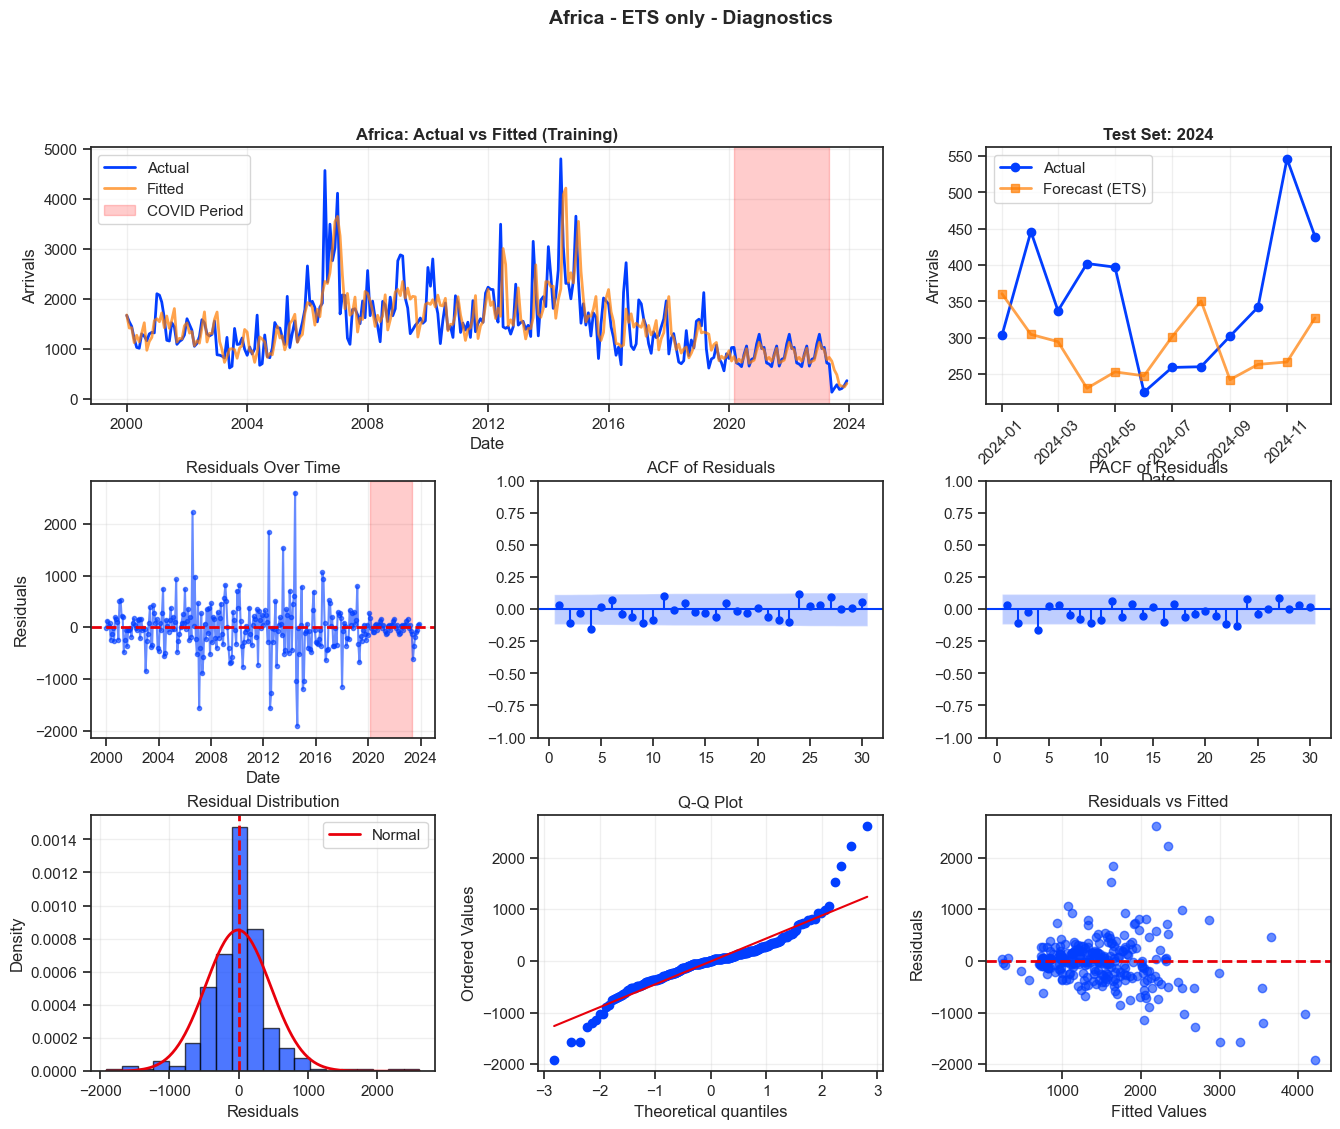


--- Diagnostics: america_central_e_caribe ---
  Ljung-Box p-value (lag 12) for america_central_e_caribe: 0.00003
  Rejeita H0 (alpha=0.01). Irá ajustar AutoARIMA nos resíduos.


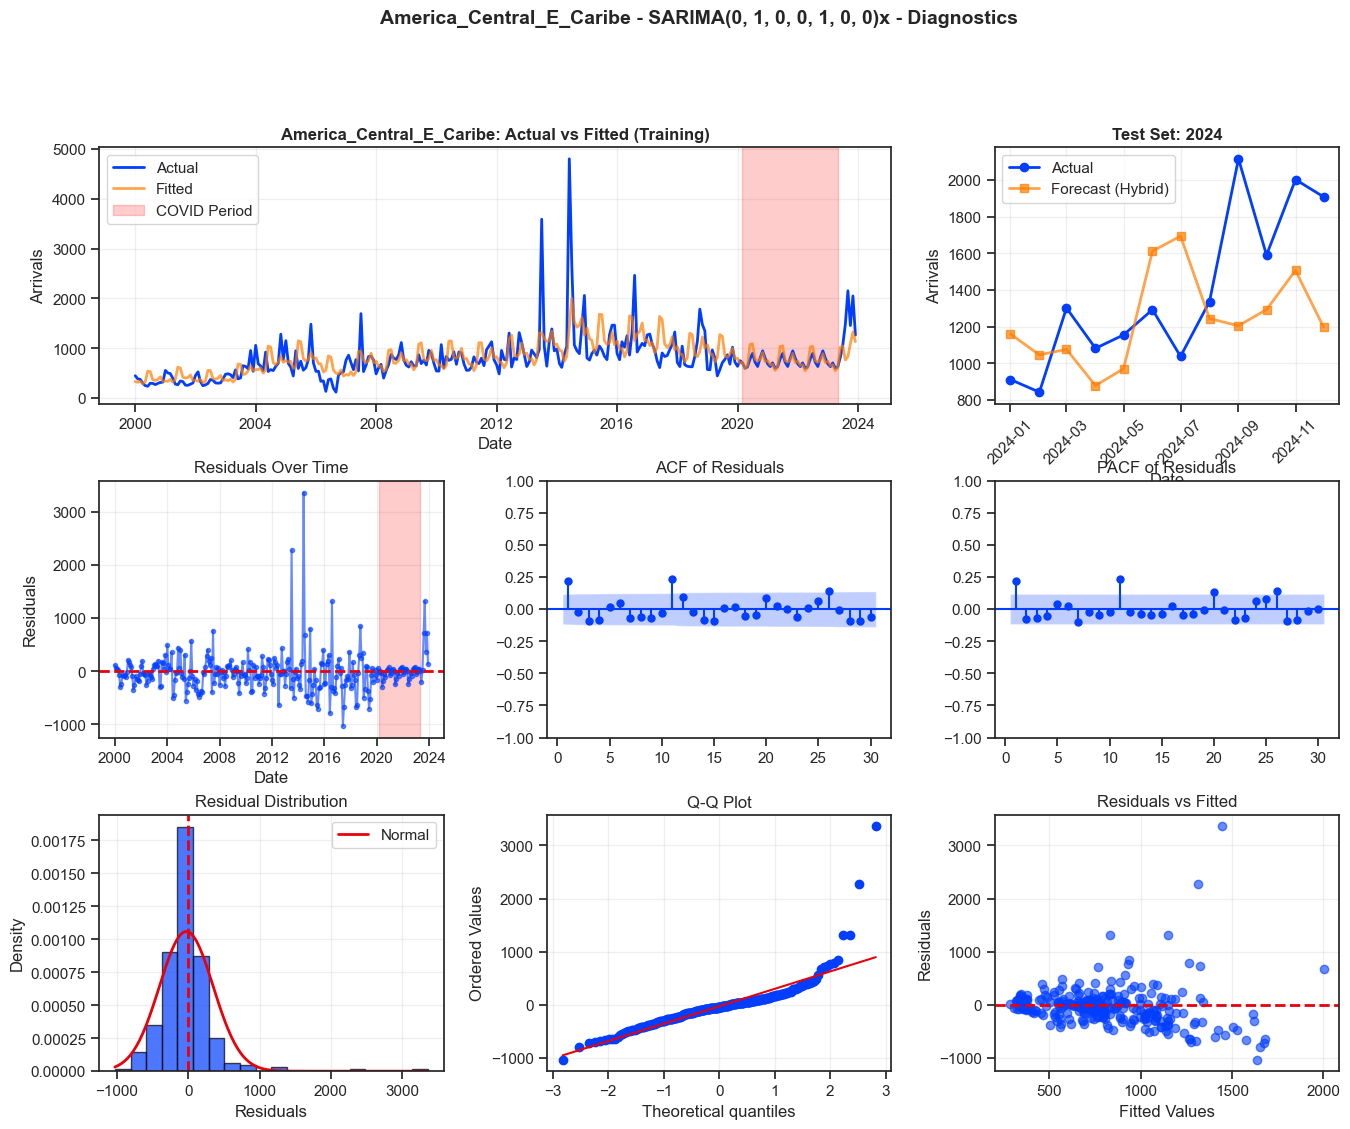


--- Diagnostics: america_do_norte ---
  Ljung-Box p-value (lag 12) for america_do_norte: 0.01147
  Não rejeita H0 (resíduos parecem ruído branco). Usando só AutoETS.


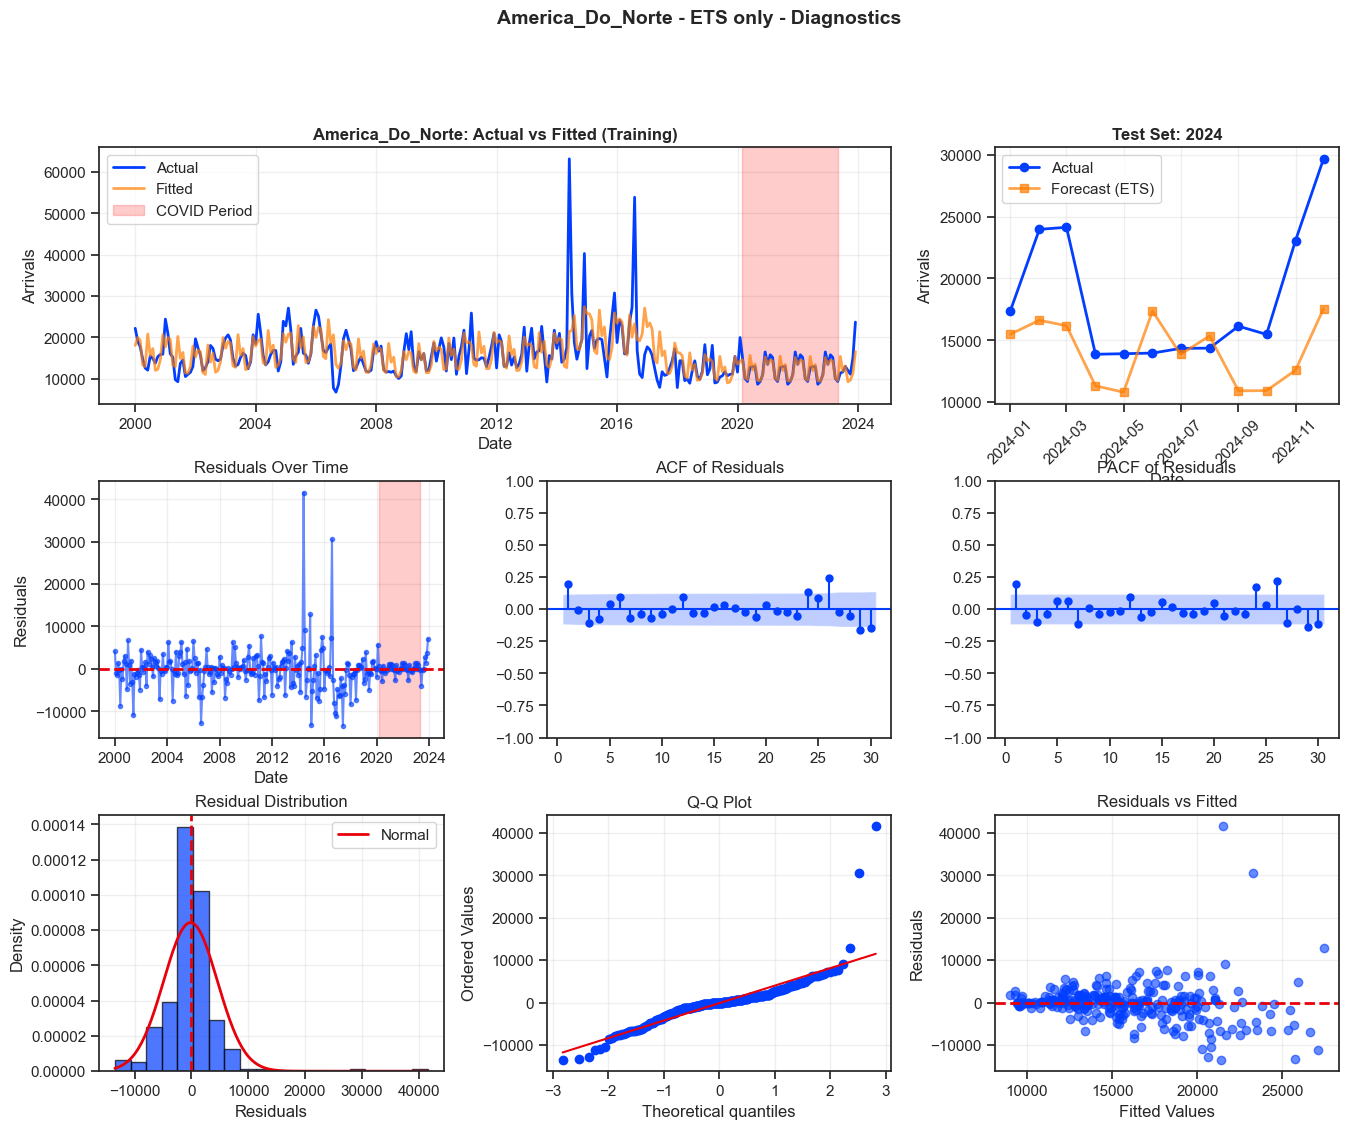


--- Diagnostics: america_do_sul ---
  Ljung-Box p-value (lag 12) for america_do_sul: 0.00000
  Rejeita H0 (alpha=0.01). Irá ajustar AutoARIMA nos resíduos.


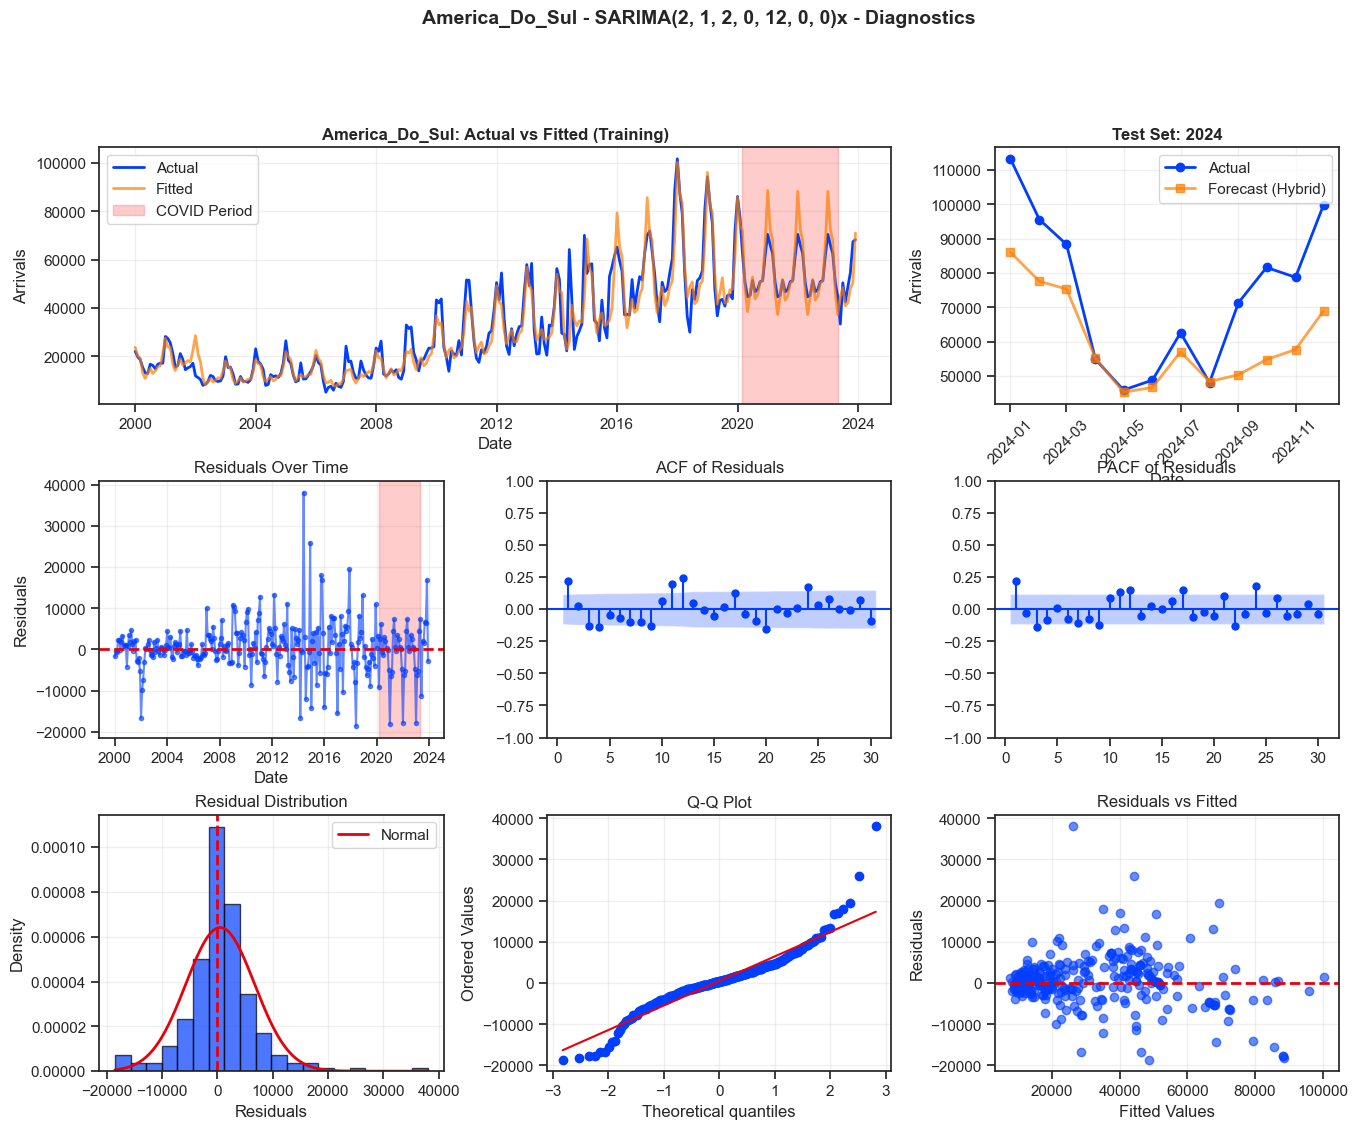


--- Diagnostics: asia ---
  Ljung-Box p-value (lag 12) for asia: 0.00000
  Rejeita H0 (alpha=0.01). Irá ajustar AutoARIMA nos resíduos.


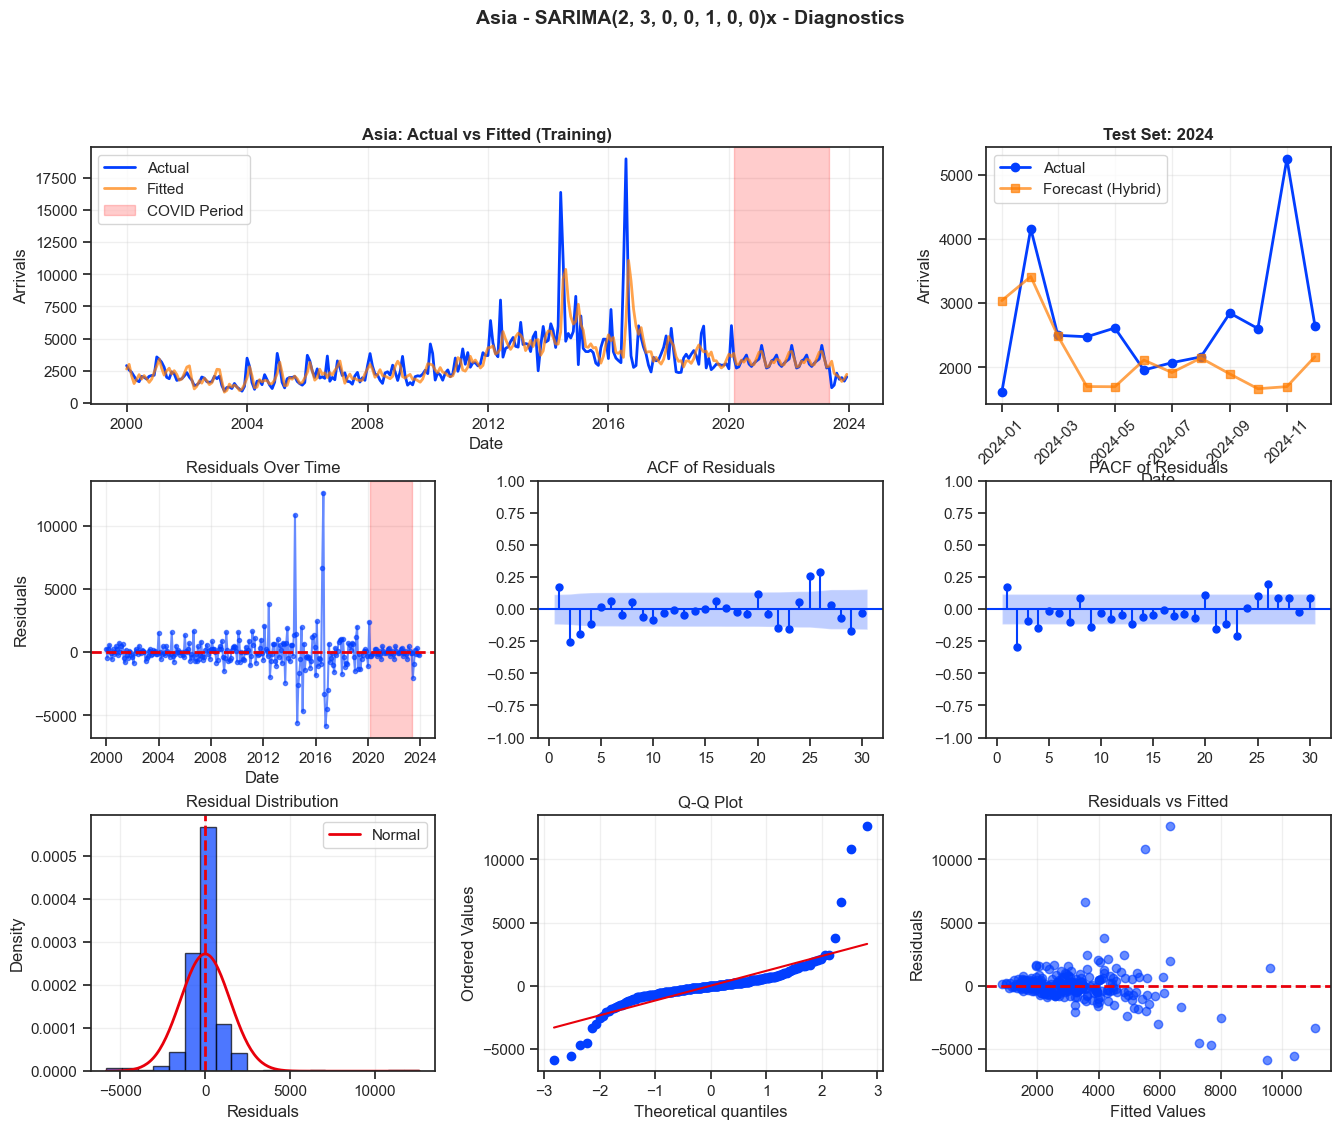


--- Diagnostics: europa ---
  Ljung-Box p-value (lag 12) for europa: 0.00709
  Rejeita H0 (alpha=0.01). Irá ajustar AutoARIMA nos resíduos.


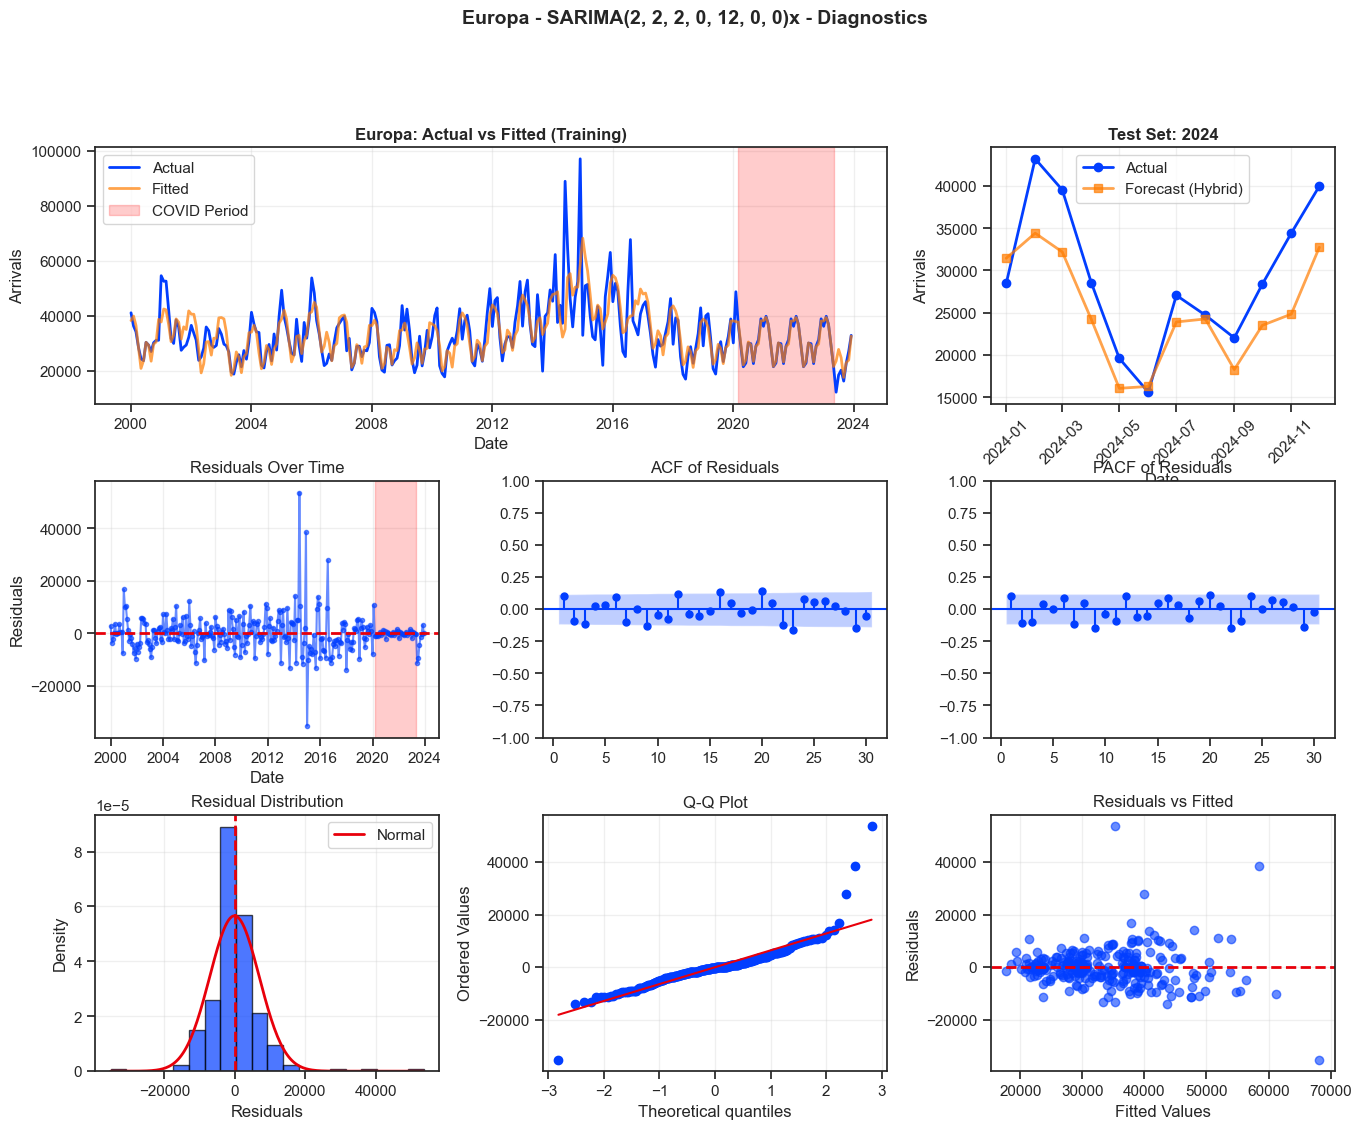


--- Diagnostics: oceania ---
  Ljung-Box p-value (lag 12) for oceania: 0.03194
  Não rejeita H0 (resíduos parecem ruído branco). Usando só AutoETS.


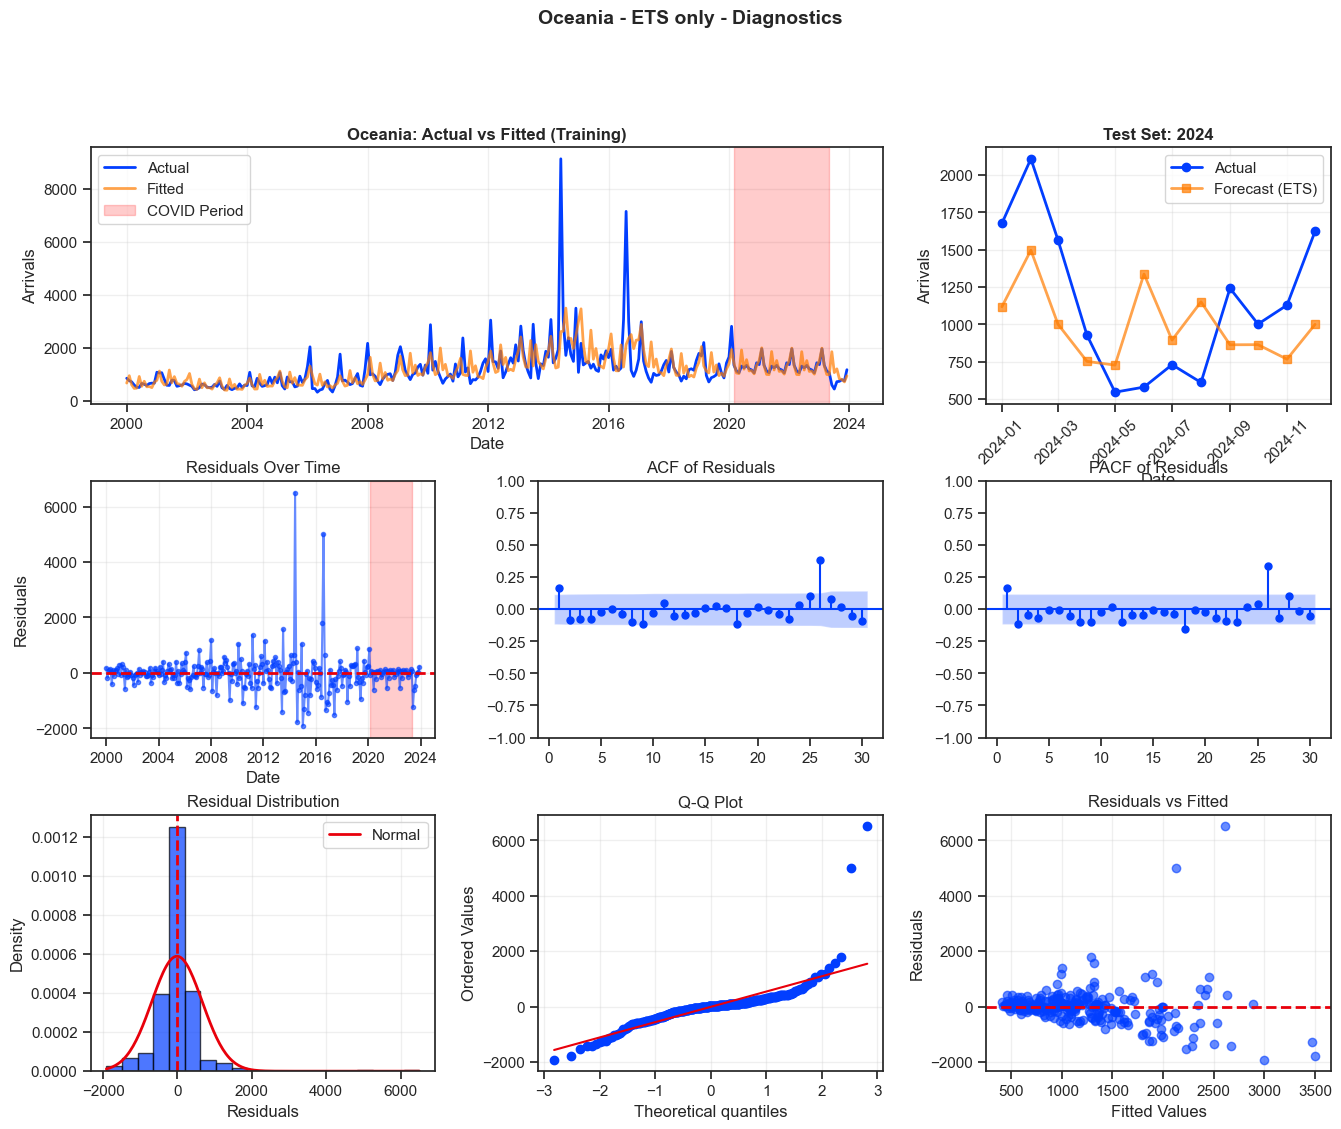

In [23]:
# Diagnostics plot por continente (gera gráficos de diagnóstico híbrido ETS + ARIMA nos resíduos)
# Usa variáveis já carregadas no notebook: Y_df_h_imputado, series_por_continente, train_end, test_start, test_end, COVID_START, COVID_END

from statsmodels.stats.diagnostic import acorr_ljungbox

for continent in Y_df_h_imputado['unique_id'].unique():
    try:
        print(f"\n--- Diagnostics: {continent} ---")
        # Dados de treino e teste
        train_df = Y_df_h_imputado[
            (Y_df_h_imputado['unique_id'] == continent) &
            (Y_df_h_imputado['ds'] <= train_end)
        ].copy()
        test_series = series_por_continente[continent].loc[test_start:test_end]
        h = len(test_series)

        # 1) Treina AutoETS no treino (imputado)
        sf_ets_local = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
        sf_ets_local.fit(df=train_df)
        forecast_ets = sf_ets_local.forecast(df=train_df, h=h, fitted=True)
        fitted_values_df = sf_ets_local.forecast_fitted_values()

        # Series fitted e treino alinhados
        fitted_series = pd.Series(fitted_values_df['AutoETS'].values, index=pd.to_datetime(fitted_values_df['ds']))
        y_train_series = pd.Series(train_df['y'].values, index=pd.to_datetime(train_df['ds']))

        common_idx = y_train_series.index.intersection(fitted_series.index)
        if len(common_idx) == 0:
            print(f"  Aviso: sem pontos alinhados fitted x treino para {continent}. Pulando.")
            continue

        y_train_aligned = y_train_series.loc[common_idx]
        fitted_aligned = fitted_series.loc[common_idx]

        residuals = (y_train_aligned - fitted_aligned).dropna()

        # 2) Teste de Ljung-Box nos resíduos do AutoETS (decidir usar AutoARIMA somente se falhar)
        df_resid = pd.DataFrame({
            'unique_id': f'{continent}_resid',
            'ds': residuals.index,
            'y': residuals.values
        }).dropna()

        # Variáveis padrão caso não rode ARIMA
        forecast_ets_series = pd.Series(forecast_ets['AutoETS'].values, index=pd.to_datetime(forecast_ets['ds']))
        forecast_for_plot = forecast_ets_series
        arima_info = "n/a"

        try:
            resid_vals = residuals.dropna()
            use_arima = False

            # Só realiza Ljung-Box se tivermos dados suficientes
            if resid_vals.size >= 12:
                lb_df = acorr_ljungbox(resid_vals, lags=[12], return_df=True)
                pval_lag12 = lb_df['lb_pvalue'].iloc[-1]
                print(f"  Ljung-Box p-value (lag 12) for {continent}: {pval_lag12:.5f}")
                if pval_lag12 < 0.01:
                    use_arima = True
                    print(f"  Rejeita H0 (alpha=0.01). Irá ajustar AutoARIMA nos resíduos.")
                else:
                    print(f"  Não rejeita H0 (resíduos parecem ruído branco). Usando só AutoETS.")
            else:
                print(f"  Resíduos insuficientes para Ljung-Box (n={resid_vals.size}). Pulando AutoARIMA.")

            if use_arima:
                sf_arima_local = StatsForecast(models=[AutoARIMA(season_length=12)], freq='MS', n_jobs=1)
                sf_arima_local.fit(df=df_resid)
                forecast_resid = sf_arima_local.forecast(df=df_resid, h=h, fitted=True)

                # Previsão híbrida (ETS + ARIMA(resid))
                y_pred_ets = forecast_ets['AutoETS'].values
                y_pred_hybrid = y_pred_ets + forecast_resid['AutoARIMA'].values
                forecast_hybrid_series = pd.Series(y_pred_hybrid, index=pd.to_datetime(forecast_ets['ds']))
                forecast_for_plot = forecast_hybrid_series

                # tentar extrair info ARIMA para título
                try:
                    arima_info = sf_arima_local.fitted_[0][0].model_.get('arma', '')
                except Exception:
                    arima_info = "AutoARIMA"
            else:
                # mantém forecast_ets_series em forecast_for_plot (já setado)
                arima_info = "n/a"

        except Exception as e_ar:
            print(f"  Erro ao avaliar/ajustar ARIMA para {continent}: {e_ar}")
            # fallback: usar apenas ETS
            forecast_for_plot = forecast_ets_series
            arima_info = "error"

        # 3) Preparar variáveis para o plot
        covid_start = pd.to_datetime(COVID_START)
        covid_end = pd.to_datetime(COVID_END)
        y_test = test_series.copy()
        y_train = y_train_series.copy()
        fitted = fitted_aligned  # plotted aligned to available fitted points
        forecast = forecast_for_plot

        # extrair parâmetros SARIMA/ordem se disponível (fallback)
        try:
            best_order = tuple(arima_info.get('order')) if isinstance(arima_info, dict) and 'order' in arima_info else arima_info
            best_seasonal_order = arima_info.get('seasonal_order') if isinstance(arima_info, dict) and 'seasonal_order' in arima_info else ''
        except Exception:
            best_order = ''
            best_seasonal_order = ''

        # 4) Plot diagnostics (layout 3x3)
        fig = plt.figure(figsize=(16, 12))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        # Plot 1: Fitted vs Actual (Training)
        ax1 = fig.add_subplot(gs[0, :2])
        ax1.plot(y_train.index, y_train.values, label='Actual', linewidth=2)
        ax1.plot(fitted.index, fitted.values, label='Fitted', linewidth=2, alpha=0.7)
        ax1.axvspan(covid_start, covid_end, alpha=0.2, color='red', label='COVID Period')
        ax1.set_title(f'{continent.title()}: Actual vs Fitted (Training)', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Arrivals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Forecast vs Actual (Test)
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.plot(y_test.index, y_test.values, label='Actual', linewidth=2, marker='o')
        ax2.plot(forecast.index, forecast.values, label='Forecast (Hybrid)' if use_arima else 'Forecast (ETS)', linewidth=2, alpha=0.7, marker='s')
        ax2.set_title(f'Test Set: {test_start[:4]}', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Arrivals')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        # Plot 3: Residuals over time
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.plot(residuals.index, residuals.values, marker='o', markersize=3, alpha=0.6)
        ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax3.axvspan(covid_start, covid_end, alpha=0.2, color='red')
        ax3.set_title('Residuals Over Time')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Residuals')
        ax3.grid(True, alpha=0.3)

        # Plot 4: ACF of Residuals
        ax4 = fig.add_subplot(gs[1, 1])
        sm.graphics.tsa.plot_acf(residuals.dropna(), lags=min(30, max(1, len(residuals)//2)), ax=ax4, zero=False)
        ax4.set_title('ACF of Residuals')

        # Plot 5: PACF of Residuals
        ax5 = fig.add_subplot(gs[1, 2])
        sm.graphics.tsa.plot_pacf(residuals.dropna(), lags=min(30, max(1, len(residuals)//2)), ax=ax5, zero=False, method='ywm')
        ax5.set_title('PACF of Residuals')

        # Plot 6: Histogram of Residuals
        ax6 = fig.add_subplot(gs[2, 0])
        resid_vals = residuals.dropna().values
        if resid_vals.size > 0:
            ax6.hist(resid_vals, bins=20, alpha=0.7, edgecolor='black', density=True)
            ax6.axvline(x=0, color='r', linestyle='--', linewidth=2)
            mu, sigma = resid_vals.mean(), resid_vals.std()
            x_pdf = np.linspace(resid_vals.min(), resid_vals.max(), 200)
            ax6.plot(x_pdf, stats.norm.pdf(x_pdf, mu, sigma), 'r-', linewidth=2, label='Normal')
        ax6.set_title('Residual Distribution')
        ax6.set_xlabel('Residuals')
        ax6.set_ylabel('Density')
        ax6.legend()
        ax6.grid(True, alpha=0.3)

        # Plot 7: Q-Q Plot
        ax7 = fig.add_subplot(gs[2, 1])
        if resid_vals.size > 0:
            stats.probplot(resid_vals, dist="norm", plot=ax7)
        ax7.set_title('Q-Q Plot')
        ax7.grid(True, alpha=0.3)

        # Plot 8: Residuals vs Fitted
        ax8 = fig.add_subplot(gs[2, 2])
        if resid_vals.size > 0:
            # scatter using fitted values aligned with residuals index
            fitted_for_scatter = fitted.loc[residuals.index].values if any(idx in fitted.index for idx in residuals.index) else np.full(len(resid_vals), np.nan)
            ax8.scatter(fitted_for_scatter, resid_vals, alpha=0.6)
        ax8.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax8.set_xlabel('Fitted Values')
        ax8.set_ylabel('Residuals')
        ax8.set_title('Residuals vs Fitted')
        ax8.grid(True, alpha=0.3)

        title_arima = f"SARIMA{best_order}x{best_seasonal_order}" if best_order and best_order != "n/a" else f"Hybrid ({arima_info})" if use_arima else "ETS only"
        plt.suptitle(f'{continent.title()} - {title_arima} - Diagnostics', fontsize=14, fontweight='bold', y=0.995)
        plt.show()

    except Exception as e:
        print(f"Erro ao gerar diagnostics para {continent}: {e}")
        continue